# Enable Inline Display in Jupyter
For displaying plots inline in the notebook, enable inline plotting

In [35]:
%matplotlib inline

# Preliminary settings

Libraries imported.

TensorFlow, Keras, and other relevant libraries for building the image captioning model.

In [36]:
import os
import re
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

from datetime import datetime
seed = int(round(datetime.now().timestamp()))
np.random.seed(seed)
tf.random.set_seed(seed)

Path to data.

In [37]:
dx = "/data/train/rxxch9vw59.2/"

Important constants.

In [38]:
# Path to the images
IMAGES_PATH = dx+"images"

# Desired image dimensions
# IMAGE_SIZE = (224, 224)
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 6000
# later to be updated to VOCAB_SIZE = len(filtered_words) + 2

# Fixed length allowed for any sequence
SEQ_LENGTH = 8
# SEQ_LENGTH = 10
# SEQ_LENGTH = 12

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 256
# EMBED_DIM = 512
# EMBED_DIM = 768

# Per-layer units in the feed-forward network
FF_DIM = 256
# FF_DIM = 1024
# FF_DIM = 2048

# Other training parameters
BATCH_SIZE = 25
# BATCH_SIZE = 64

# EPOCHS = 20
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

# Dataset creation

The image files are loaded. Each image is paired with two captions.
The pairs are shuffled and split into 20% test and 80% train set.

* Loading caption data from JSON.
* Mapping captions to images and splitting the data into training and validation sets.

In [39]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """
    with open(filename, encoding="utf8") as caption_file:
        caption_data = json.load(caption_file)
        caption_mapping = {}
        text_data = []

        for item in caption_data:  # Iterate over the list of dictionaries
            img_name = os.path.join(IMAGES_PATH, item['filename'].strip())  # Access 'filename'
            caption_mapping[img_name] = ["<start> " + caption.strip() + " <end>" for caption in item['caption']]  # Access 'caption'
            text_data.extend(caption_mapping[img_name])

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Training and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data(dx + "captions.json")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  7323
Number of validation samples:  1831


# Analyze Word Frequency Distribution
* After tokenizing the dataset, count the frequency of each word. This can be done using libraries like `collections.Counter`
* Plot a word frequency distribution to visualize how many words appear frequently and how many appear only a few times (the latter are often noise).

In [40]:
# Import necessary libraries
from collections import Counter
import json
import matplotlib.pyplot as plt

# Load the captions data from the file
captions_path = dx + "captions.json"
with open(captions_path, 'r', encoding='utf-8') as f:
    captions_data = json.load(f)

# Flatten all captions into a single list
captions = []
for item in captions_data:
    captions.extend(item['caption'])

# Tokenize the captions by splitting on spaces
all_words = ' '.join(captions).split()

# Count the frequency of each word
word_freq = Counter(all_words)

# Visualize the word frequency distribution
plt.figure(figsize=(10,6))
plt.hist(list(word_freq.values()), bins=50)
plt.yscale('log')
plt.title('Word Frequency Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Save the visualization as an image
visualization_path = '/results/' + "word_frequency_distribution.png"
plt.savefig(visualization_path)
plt.close()
print(f"Visualization saved at {visualization_path}")

# Save word frequencies to a CSV file
csv_path = '/results/' + "word_frequencies.csv"
with open(csv_path, 'w', encoding='utf-8') as f:
    f.write("Word,Frequency\n")
    for word, freq in sorted(word_freq.items(), key=lambda item: item[1], reverse=True):
        f.write(f"{word},{freq}\n")
print(f"Word frequencies saved at {csv_path}")

# Show the 10 most common words for reference
print("Top 10 most common words:", word_freq.most_common(10))

# Tokenize captions for sequence length analysis
tokenized_captions = [caption.split() for caption in captions]
seq_lengths = [len(tokens) for tokens in tokenized_captions]

# Analyze length statistics
max_seq_length = max(seq_lengths)
mean_seq_length = int(np.mean(seq_lengths))
seq_length_95th = int(np.percentile(seq_lengths, 95))
seq_length_99th = int(np.percentile(seq_lengths, 99))
print(f"Max Sequence Length: {max_seq_length}")
print(f"Mean Sequence Length: {mean_seq_length}")
print(f"95th Percentile Sequence Length: {seq_length_95th}")
print(f"99th Percentile Sequence Length: {seq_length_99th}")

# Dynamically set SEQ_LENGTH based on 99th percentile
# SEQ_LENGTH = seq_length_99th
# print(f"Adjusted SEQ_LENGTH: {SEQ_LENGTH}")

Visualization saved at /results/word_frequency_distribution.png
Word frequencies saved at /results/word_frequencies.csv
Top 10 most common words: [('আছে।', 9264), ('একজন', 8775), ('একটি', 6006), ('পুরুষ', 4564), ('মানুষ', 4091), ('দাড়িয়ে', 3489), ('বসে', 3379), ('ও', 2350), ('দিয়ে', 2223), ('জন', 2201)]
Max Sequence Length: 38
Mean Sequence Length: 8
95th Percentile Sequence Length: 17
99th Percentile Sequence Length: 22


# Inspect Rare Tokens
* Review the least frequent tokens to ensure they're relevant

In [41]:
rare_tokens = [word for word, freq in word_freq.items() if freq == 1]
print(f"Rare tokens ({len(rare_tokens)}):", rare_tokens[:10])


Rare tokens (2840): ['পিটানোর', 'ঘুরানো,', 'গুলোর', 'ঢুল', 'অফ', 'হুয়াট', 'প্রনে', 'ঝার', 'বসতি', 'বানিয়ে,']


# Set a Minimum Word Frequency Threshold
* Set a threshold to eliminate words that appear too infrequently (e.g., words appearing less than 2 times). These words don’t contribute much to the model and might be considered noise.

In [42]:
# Token frequency adjustment for balanced coverage
rare_threshold = 2  # Minimum count for inclusion
frequent_threshold = float('inf')  # No upper limit on frequency
filtered_words = {word: freq for word, freq in word_freq.items()
                  if rare_threshold <= freq <= frequent_threshold}

# Check how many words have left after filtering
print(f"Number of filtered words: {len(filtered_words)}")

Number of filtered words: 3136


# Review and Fine-Tune the Vocabulary Size
* Based on the frequency analysis, adjust the `VOCAB_SIZE` parameter to ensure it matches the number of words that appear frequently.

In [43]:
# Determine the vocabulary size with a buffer for special tokens
VOCAB_SIZE = len(filtered_words) + 2 # Adding 2 for `""` and `[UNK]`
print(f"Balanced Vocabulary Size: {VOCAB_SIZE}")

Balanced Vocabulary Size: 3138


In [44]:
text_data[:3]

['<start> তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে। <end>',
 '<start> একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে। <end>',
 '<start> অনেক মেয়ে মানুষ বসে আছে। <end>']

The captions are vectorised

# Update the Vocabulary
* Use the filtered frequent words as the vocabulary when building the `TextVectorization` layer.

In [45]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


# Using raw string for strip_chars
strip_chars = r"!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

# List of words to include in the final vocabulary
final_vocab = list(filtered_words.keys())
print(f"Final Vocabulary Length: {len(final_vocab)}")

# Initialize the TextVectorization layer with the final vocabulary
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.set_vocabulary(final_vocab)

# Adapting the vectorization layer
# vectorization.adapt(text_data)

# Save the vocabulary to a JSON file after training
vocab = vectorization.get_vocabulary()
with open('/results/vocab.json', 'w', encoding='utf-8') as f:
    json.dump(vocab, f, ensure_ascii=False, indent=4)
print(f"Vocabulary saved with {len(vocab)} tokens.")


Final Vocabulary Length: 3136
Vocabulary saved with 3138 tokens.


Image augmentation is performed

Image augmentation using Keras' `Sequential` API.

In [46]:
# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1), # Reduced rotation for faster preprocessing
        layers.RandomContrast(0.2), # Lighter contrast adjustment
        # layers.RandomTranslation(0.1, 0.1),
    ]
)


# Verify Vocabulary Coverage
* Check the coverage of the final vocabulary on the captions dataset to ensure that important words are not being filtered out.

In [47]:
covered = sum(word_freq[word] for word in final_vocab)
total = sum(word_freq.values())
print(f"Coverage: {covered / total * 100:.2f}%")

Coverage: 98.17%


A function to expand the dataset such that each image is paired with each caption separately.

In [48]:
def flatten_dataset(caption_mapping):
    """Flattens the dataset by creating separate (image, caption) pairs for each caption of an image.

    Args:
        caption_mapping: Dictionary mapping image names to a list of captions.

    Returns:
        images: List of image paths (repeated for each caption).
        captions: List of corresponding captions (each caption as a string).
    """
    images = []
    captions = []

    # For each image, repeat the image path for each caption and append to the lists
    for img_path, caption_list in caption_mapping.items():
        for caption in caption_list:
            images.append(img_path)
            captions.append(caption)

    return images, captions


The train and test datasets are created using TensorFlow Dataset.

# Creating TensorFlow Datasets
* Images and captions are processed into TensorFlow datasets using the `tf.data.Dataset` API.

## Group Captions by Image

The `group_captions_by_image` function organizes multiple captions for each image into a list. This ensures the dataset aligns with the expected model input shape.

## Caption Padding or Truncation

To maintain consistent input shapes, captions are padded (with `<pad>` tokens) or truncated to match `NUM_CAPTIONS_PER_IMAGE`.

## Vectorization

Captions are vectorized in grouped form (e.g., a batch shape of `[batch_size, num_captions_per_image, SEQ_LENGTH]`).

## TensorFlow Dataset Mapping

The dataset maps images and grouped captions to the desired processed format.

## Dataset Batching

The dataset batches are formed after grouping captions and images.

In [49]:
from collections import defaultdict
from PIL import Image
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Constants
# Number of captions per image to use
NUM_CAPTIONS_PER_IMAGE = 2

# Suppress PNG warnings using PIL
def preprocess_image(image_path):
    """Preprocess image to suppress warnings."""
    try:
        with Image.open(image_path) as img:
            img = img.convert("RGB")  # Strip unnecessary metadata
            img.save(image_path, "PNG", icc_profile=None)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Decode, resize, and preprocess images
def decode_and_resize(img_path):
    try:
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
    except Exception as e:
        print(f"Error in decoding and resizing image {img_path}: {e}")

def process_input(img_path, caption):
    img = decode_and_resize(img_path)
    
    # Vectorize the caption
    captions_vectorized = vectorization(caption)
    
    return img, captions_vectorized

# Function to group captions by image
# Group captions by image
def group_captions_by_image(images, captions):
    grouped_data = defaultdict(list)
    for img, cap in zip(images, captions):
        grouped_data[img].append(cap)

    grouped_images = []
    grouped_captions = []

    for img, caps in grouped_data.items():
        grouped_images.append(img)
        grouped_captions.append(
            caps[:NUM_CAPTIONS_PER_IMAGE] + ["<pad>"] * (NUM_CAPTIONS_PER_IMAGE - len(caps))
        )

    print(f"Grouped {len(grouped_images)} images with captions.")
    return grouped_images, grouped_captions

# Process images and captions
def process_input(img_path, captions):
    img = decode_and_resize(img_path)
    captions_vectorized = vectorization(captions)
    captions_padded = pad_sequences(captions_vectorized, maxlen=SEQ_LENGTH, padding="post")
    return img, captions_padded

# Function for dataset creation
# Create a TensorFlow Dataset
def make_dataset(images, captions, num_captions_per_image):
    # Group captions by image
    grouped_images, grouped_captions = group_captions_by_image(images, captions)

    # Ensure all groups have a consistent number of captions (pad/truncate)
    padded_captions = [
        caps[:num_captions_per_image] + ["<pad>"] * (num_captions_per_image - len(caps))
        if len(caps) < num_captions_per_image else caps[:num_captions_per_image]
        for caps in grouped_captions
    ]

    # Create a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((grouped_images, padded_captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)

    # Map images and captions to processed inputs
    dataset = dataset.map(
        lambda img, caps: (decode_and_resize(img), vectorization(caps)),
        num_parallel_calls=AUTOTUNE
    )

    for img, cap in dataset.take(1):
        print(f"Image and grouped caption shape: {img.shape, cap.shape} \n")

    # Batch and prefetch the dataset
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# def make_dataset(images, captions):
#     print([len(i) for i in images[:5]])
#     print([len(i) for i in captions[:5]])

# Dataset Preparation
# Flatten the training data and create datasets
train_images, train_captions = flatten_dataset(train_data)
valid_images, valid_captions = flatten_dataset(valid_data)

# Pass the list of images and the list of corresponding captions
# Create train and validation datasets
print("Creating training dataset... \n")
train_dataset = make_dataset(train_images, train_captions, NUM_CAPTIONS_PER_IMAGE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Creating validation dataset... \n")
valid_dataset = make_dataset(valid_images, valid_captions, NUM_CAPTIONS_PER_IMAGE)

# Print the shapes of the datasets
# Debugging shapes
for img_batch, cap_batch in train_dataset.take(1):
    print(f"Training batch image shape: {img_batch.shape}, Caption shape: {cap_batch.shape}")
for img_batch, cap_batch in valid_dataset.take(1):
    print(f"Validation batch image shape: {img_batch.shape}, Caption shape: {cap_batch.shape}")

Creating training dataset... 

Grouped 7323 images with captions.
Image and grouped caption shape: (TensorShape([299, 299, 3]), TensorShape([2, 8])) 

Creating validation dataset... 

Grouped 1831 images with captions.
Image and grouped caption shape: (TensorShape([299, 299, 3]), TensorShape([2, 8])) 



2024-12-20 09:13:31.016128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:31.134878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:31.150598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:31.300257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:31.494896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Training batch image shape: (25, 299, 299, 3), Caption shape: (25, 2, 8)
Validation batch image shape: (25, 299, 299, 3), Caption shape: (25, 2, 8)


2024-12-20 09:13:31.611328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:31.629945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


# Dataset Statistics
* A helper function to compute and display statistics about the dataset.

In [50]:
def compute_dataset_statistics(captions):
    """Print statistics for the caption dataset."""
    caption_lengths = [len(cap.split()) for cap in captions]
    print(f"Total Captions: {len(captions)}")
    print(f"Max Caption Length: {max(caption_lengths)}")
    print(f"Min Caption Length: {min(caption_lengths)}")
    print(f"Mean Caption Length: {sum(caption_lengths) / len(caption_lengths):.2f}")

# Compute statistics
print("Training Dataset Statistics:")
compute_dataset_statistics(train_captions)

print("Validation Dataset Statistics:")
compute_dataset_statistics(valid_captions)


Training Dataset Statistics:
Total Captions: 14646
Max Caption Length: 37
Min Caption Length: 4
Mean Caption Length: 10.48
Validation Dataset Statistics:
Total Captions: 3662
Max Caption Length: 40
Min Caption Length: 4
Mean Caption Length: 10.44


# Transformer model creation

The Transformer uses the EfficientNetB0 CNN.
The Encoder and Decoder block and Positional Embedding layer is seperately created by inheriting the Layer class.
The Transformer model is created by compiling the layers and inheriting the Model class.

# Model Creation
* EfficientNetB0 as the feature extractor for image embeddings.
* Custom layers for Transformer-based encoder and decoder blocks.
* Positional embedding is used to encode positional information for the sequences.

# Training the Model
* Loss and accuracy are tracked across each training step.
* Gradient updates are performed via `tf.GradientTape`.

In [51]:
# Defining the Model
# CNN
def get_cnn_model():
    try:
        base_model = efficientnet.EfficientNetB0(
            input_shape=(*IMAGE_SIZE, 3),
            include_top=False,
            weights="imagenet",
        )
        # We freeze our feature extractor
        base_model.trainable = False
        base_model_out = base_model.output
        
        # Reduce the sequence length using a pooling operation
        # Using GlobalAveragePooling2D to reduce the spatial dimensions
        base_model_out = layers.GlobalAveragePooling2D()(base_model_out)
        
        # Project the output to match the embedding size
        base_model_out = layers.Dense(EMBED_DIM)(base_model_out)
        
        cnn_model = keras.models.Model(base_model.input, base_model_out)
        
        # Print CNN Model Summary
        # print("\nCNN Model Summary:")
        # cnn_model.summary()
        
        return cnn_model
    except Exception as e:
        logger.error(f"Error loading CNN model: {e}")

# Positional Encoding and Encoder/Decoder

# Encoder
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0 # previously 0.1
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        # Input shape
        # print(f"Encoder Input Shape: {inputs.shape}")

        # print(f"Encoder Input Shape before LayerNorm: {inputs.shape}")
        inputs = self.layernorm_1(inputs)
        # print(f"Encoder Input Shape after LayerNorm: {inputs.shape}")
        
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        
        out_1 = self.layernorm_2(inputs + attention_output_1)

        # Output shape
        # print(f"Encoder Output Shape: {out_1.shape}")
        return out_1


# Positional Encoding
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        # print(f"Positional Embedding Input Shape: {inputs.shape}")
        
        # Get input shape and positions
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        
        # Embed tokens and positions
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale # Apply scaling
        embedded_positions = self.position_embeddings(positions)
        
        # Embeddings shape
        # print(f"Positional Embedding Output Shape: {embedded_tokens.shape}")
        # print(f"embedded_tokens dtype: {embedded_tokens.dtype}")
        # print(f"embedded_positions dtype: {embedded_positions.dtype}")
        
        # Return combined embeddings
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

# Decoder
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        
        # Attention layers
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        # Feed-forward layers
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        # Layer normalizations
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        # Output layers
        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        # Dropout layers
        self.dropout_1 = layers.Dropout(0.3) # previously 0.1
        self.dropout_2 = layers.Dropout(0.5) # previously 0.1
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        """
        Args:
            inputs: Tokenized inputs to the decoder (batch_size, sequence_length).
            encoder_outputs: Outputs from the encoder (batch_size, seq_len, embed_dim).
            training: Boolean indicating whether it's training or inference.
            mask: Mask for padded tokens (batch_size, sequence_length).
        
        Returns:
            preds: Decoder output predictions (batch_size, seq_len, vocab_size).
        """
        # print(f"Decoder Input Shape: {inputs.shape}")
        
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        # Self-attention
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        # Cross-attention with encoder outputs
        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        # Feed-forward network
        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        
        # print(f"Decoder Output Shape: {preds.shape}")
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

# Model definition
class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=2, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        # print(f"Image Embedding Input Shape before passing to Encoder: {img_embed.shape}")
        
        # batch_seq = tf.expand_dims(batch_seq, axis=1)
        # print(f"Batch Sequence Input Shape before slicing: {batch_seq.shape}")
        
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1] # Input sequence (without the last token)

        # print(f"Batch Sequence Input Shape before target sequence: {batch_seq_inp.shape}")
        
        batch_seq_true = batch_seq[:, 1:] # Target sequence (without the first token)
        mask = tf.math.not_equal(batch_seq_true, 0)
        
        # print(f"Batch Sequence Input Shape: {batch_seq_inp.shape}")
        # print(f"Batch Sequence True Shape: {batch_seq_true.shape}")
        
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )

        # print(f"Batch Sequence Predicted Shape: {batch_seq_pred.shape}")
        
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data

        # batch_seq = tf.expand_dims(batch_seq, axis=1)

        # print(f"Training Image Batch Shape before passing to CNN: {batch_img.shape}")
        total_loss = 0
        total_acc = 0
    
        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # print(f"Training Image Batch Shape: {batch_img.shape}")
        # print(f"Training Sequence Batch Shape: {batch_seq.shape}")
        
        # 1. Get image embeddings from CNN
        img_embed = self.cnn_model(batch_img)
        # print(f"Image Embeddings Shape: {img_embed.shape}")

        # 2. Reshape CNN output to (batch_size, 1, embedding_dim)
        img_embed = tf.expand_dims(img_embed, axis=1)  # It should be (None, 1, 1024)

        # print(f"Reshaped Image Embeddings for Encoder: {img_embed.shape}")
        
        # 3. Make sure batch_seq has 3 dimensions
        if batch_seq.shape.ndims == 2:
            # Reshape the sequence to have a third dimension (e.g., 1 caption per image)
            batch_seq = tf.expand_dims(batch_seq, axis=1)
        
        # print(f"Updated Sequence Shape: {batch_seq.shape}")

        # 4. Accumulate loss and accuracy for each caption
        with tf.GradientTape() as tape:
            # Loop through each caption (batch_seq should be (batch_size, num_captions, sequence_length))
            num_captions_per_image = batch_seq.shape[1] # Extract the num_captions dimension
            
            for i in range(self.num_captions_per_image):
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )
                total_loss += loss
                total_acc += acc

            # 5. Compute the mean loss and accuracy
            avg_loss = total_loss / tf.cast(self.num_captions_per_image, dtype=tf.float32)
            avg_acc = total_acc / tf.cast(self.num_captions_per_image, dtype=tf.float32)

        # Backpropagation
        # 6. Get the list of all the trainable weights
        train_vars = self.encoder.trainable_variables + self.decoder.trainable_variables
        
        # 7. Get the gradients (from the accumulated loss)
        grads = tape.gradient(avg_loss, train_vars)
    
        # 8. Update the trainable weights
        self.optimizer.apply_gradients(zip(grads, train_vars))
    
        # 9. Update the trackers
        self.loss_tracker.update_state(avg_loss)
        self.acc_tracker.update_state(avg_acc)
    
        # 10. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        # print(f"Validation Image Batch Shape: {batch_img.shape}")
        # print(f"Validation Sequence Batch Shape: {batch_seq.shape}")

        # batch_seq = tf.expand_dims(batch_seq, axis=1)

        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)
        # print(f"Image Embeddings Shape: {img_embed.shape}")
        img_embed = tf.expand_dims(img_embed, axis=1)
        # print(f"Reshaped Image Embeddings Shape: {img_embed.shape}")

        # 2. Pass each of the captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        # Loop through captions
        for i in range(self.num_captions_per_image):
            batch_seq_inp = batch_seq[:, i, :-1]
            batch_seq_true = batch_seq[:, i, 1:]
            # print(f"Validation Sequence Input Shape: {batch_seq_inp.shape}")
            # print(f"Validation Sequence True Shape: {batch_seq_true.shape}")
        
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]

# Model construction

# Initialize components
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)

# Create the ImageCaptioningModel
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

The loss function and early stopping is defined. The model is compiled with the same.

# Early Stopping and Loss Function
* Early stopping is implemented to prevent overfitting.
* Loss function is sparse categorical cross-entropy.

In [52]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [53]:
# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        # Cast variables to float32
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        
        # Calculate warmup progress
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        
        # Return the appropriate learning rate based on the current step
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

In [54]:
# # Learning Rate Scheduler using Exponential Decay
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,  # Initial learning rate
#     decay_steps=1000,            # Decay after 1000 steps
#     decay_rate=0.95,             # Reduce learning rate by 5% after each decay step
#     staircase=True               # Apply decay in discrete steps
# )

# # Learning Rate Scheduler using Exponential Decay
# initial_learning_rate = 1e-4
# decay_steps = 586  # Approximately 2 epochs worth of steps
# decay_rate = 0.96  # Slower decay for gradual adjustment

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=decay_steps,
#     decay_rate=decay_rate,
# )

# # Define the optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# # Compile the model
# caption_model.compile(
#     optimizer=optimizer,
#     loss=cross_entropy
# )


In [55]:
# Take a single batch from the validation dataset
for img_batch, cap_batch in valid_dataset.take(1):
    print(f"Validation batch image shape: {img_batch.shape}, Caption shape: {cap_batch.shape}")
    caption_model.test_step((img_batch, cap_batch))


Validation batch image shape: (25, 299, 299, 3), Caption shape: (25, 2, 8)


2024-12-20 09:13:33.577859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:33.611445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


# Model training and testing

Sets the version and checks if the model has been previously trained or being trained for the first time. If saved weights are found, they're loaded.

In [56]:
mdx = '231005'  # Sets the version
tmpx = f'/results/Model_weights/{mdx}/Temp/'

# Check if the directory exists
if not os.path.exists(tmpx):
    print(f"Directory {tmpx} does not exist. Creating the directory.")
    os.makedirs(tmpx)  # Create the directory if it doesn't exist

# Now check for the files
try:
    # Loading weights
    weight_path = f'{tmpx}imgcap_{mdx}.h5'
    
    if tf.io.gfile.exists(weight_path):
        print("Found saved weights, loading them now...")
        caption_model.load_weights(weight_path)
        print("Saved weights loaded successfully")
    else:
        print("No saved weights found, training from scratch")
except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Directory /results/Model_weights/231005/Temp/ does not exist. Creating the directory.
No saved weights found, training from scratch


Lookup dictionary created and output sequence length is set.

In [57]:
# Load the vocabulary during inference
# Vocabulary set
with open('/results/vocab.json', 'r', encoding='utf-8') as f:
    vocab = json.load(f)

# Recreate the vectorization object and set its vocabulary
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)

# Set the vocabulary during inference
vectorization.set_vocabulary(vocab)

print(f"Vocabulary loaded with {len(vocab)} tokens.")

index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

Vocabulary loaded with 3138 tokens.


# Save Images Selectively and Limit Display
Saves only a subset of images and captions to a designated directory.
* Avoids memory issues by clearing figures after saving.
* Displays only a few images inline (e.g., the first 5).
* Allows to view the rest of the generated images in a lightweight HTML report.

In [58]:
import os
import gc
from matplotlib import pyplot as plt
from IPython.display import display, HTML

# Output directories
output_dir = "/results/generated_images/"
html_report_path = "/results/generated_captions_report.html"
os.makedirs(output_dir, exist_ok=True)

# Initialize HTML content for the report
html_content = "<html><body><h1>Generated Captions</h1>"

# Subset limit for inline display
display_count = 5
save_count = 20  # Max number of images to save

In [59]:
saved_image_count = 0  # Counter for the number of saved images

The function reads an image from the given path. It uses the image to generate an caption. The same are displayed.

In [60]:
from PIL import Image
import io

# Handle invalid token indices
def generate_caption(dt, ix, save_dir=None, save_idx=None, display_count=None, display_counter=[0]):
    """
    Generate a caption for a given image using a fixed SEQ_LENGTH.

    Args:
    - dt (str): Path to the dataset directory.
    - ix (str): Image filename.
    - save_dir (str, optional): Directory to save the image and caption. Default is None.
    - save_idx (str, optional): Identifier to append to the saved file. Default is None.
    - display_count (int, optional): Number of images to display. Default is None.
    - display_counter (list): A mutable counter for tracking displays. Default is [0].

    Returns:
    - str: Generated caption.
    """
    
    # Select and read the image
    # Select a random image from the validation dataset
    sample_img = f'{dt}images/{ix}'

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.axis('off')

    # Display logic: Show only up to 'display_count' images
    if display_count is None or display_counter[0] < display_count:
        plt.imshow(img)
        plt.title("Generated Image")
        plt.show()
        display_counter[0] += 1
        plt.close()
    
    # Pass the image to the CNN
    img_tensor = tf.expand_dims(sample_img, 0)
    img_features = caption_model.cnn_model(img_tensor)

    # Expand dimensions to make it compatible with the encoder
    img_features = tf.expand_dims(img_features, 1)  # Adding sequence dimension, shape becomes (batch_size, 1, embed_dim)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img_features, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        # Ensure decoded_caption is passed as a list of strings
        tokenized_caption = vectorization(tf.constant([decoded_caption]))[:, :-1]
        
        # Create mask for the tokenized caption
        mask = tf.math.not_equal(tokenized_caption, 0)

        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )

        # Get the predicted token
        sampled_token_index = np.argmax(predictions[0, i, :])

        # Check if sampled_token_index is in the vocabulary range
        if sampled_token_index >= len(vocab):
            print(f"Warning: Token index {sampled_token_index} out of range")
            continue  # Skip to the next iteration if the token is out of range

        sampled_token = index_lookup[sampled_token_index]

        if sampled_token == "[UNK]":
            continue  # Skip unknown tokens

        # Handle noisy or unknown tokens
        if sampled_token in ("[UNK]", ""):
            print(f"Warning: Encountered noisy token '{sampled_token}'. Skipping.")
            continue  # Skip this token

        if sampled_token == "<end>":
            break

        decoded_caption += " " + sampled_token

    # Clean up the decoded caption
    decoded_caption = (
        decoded_caption.replace("<start> ", "")
        .replace(" <end>", "")
        .replace("[UNK]", "")
        .strip()
    )

    print("\nPredicted Caption: ", decoded_caption)
    
    # Conditional save or display
    if save_dir and save_idx:
        global saved_image_count
        if saved_image_count < save_count:  # Check if we are within the save limit
            # Convert the image to a thumbnail and save it
            thumbnail_size = (120, 120)  # Thumbnail size
            img_pil = Image.fromarray(img)
            img_pil.thumbnail(thumbnail_size)  # Create a thumbnail
            
            # Save the image to the output directory
            save_path = os.path.join(save_dir, f"image_{save_idx}.png")
            img_pil.save(save_path)  # Save the thumbnail
            
            # Increment the saved image count
            saved_image_count += 1  # Increment the counter

            # Generate relative path for the HTML
            relative_path = os.path.relpath(save_path, os.path.dirname(html_report_path))
            
            # Generate HTML
            # Add the image and caption to the HTML content
            global html_content
            html_content += f"<div><h3>Image {save_idx}: {decoded_caption}</h3>"
            html_content += f'<img src="{relative_path}" width="300"></div>'
        else:
            # If image limit is exceeded, save only the caption
            html_content += f"<div><h3>Image {save_idx}: {decoded_caption}</h3></div>"
    gc.collect()  # Free up memory
    return decoded_caption


In [61]:
# # Handle invalid token indices
# def generate_caption(dt, ix):
#     # Select a random image from the validation dataset
#     sample_img = f'{dt}images/{ix}'

#     # Read the image from the disk
#     sample_img = decode_and_resize(sample_img)
#     img = sample_img.numpy().clip(0, 255).astype(np.uint8)
#     plt.axis('off')
#     plt.imshow(img)
#     plt.show()
#     plt.close()
    
#     # Pass the image to the CNN
#     img = tf.expand_dims(sample_img, 0)
#     img = caption_model.cnn_model(img)

#     # Expand dimensions to make it compatible with the encoder
#     img = tf.expand_dims(img, 1)  # Adding sequence dimension, shape becomes (batch_size, 1, embed_dim)

#     # Pass the image features to the Transformer encoder
#     encoded_img = caption_model.encoder(img, training=False)

#     # Generate the caption using the Transformer decoder with beam search
#     decoded_caption = beam_search_decoder(encoded_img)

#     # Clean up the decoded caption
#     decoded_caption = (
#         decoded_caption.replace("<start> ", "")
#         .replace(" <end>", "")
#         .replace("[UNK]", "")
#         .strip()
#     )
#     print("\nPredicted Caption: ", decoded_caption)
#     print()

# def beam_search_decoder(encoded_img, beam_width=3):
#     sequences = [["<start>", 1.0]]  # Initialize sequences with the start token and a score of 1.0
#     for _ in range(max_decoded_sentence_length):
#         all_candidates = []
#         for seq, score in sequences:
#             # Tokenize the current sequence
#             tokenized_caption = vectorization(tf.constant([seq]))[:, :-1]
            
#             # Create mask for the tokenized caption
#             mask = tf.math.not_equal(tokenized_caption, 0)

#             # Get predictions from the decoder
#             predictions = caption_model.decoder(
#                 tokenized_caption, encoded_img, training=False, mask=mask
#             )

#             # Select top beam_width tokens
#             top_indices = tf.math.top_k(predictions[0, -1, :], k=beam_width).indices.numpy()
#             top_scores = tf.math.top_k(predictions[0, -1, :], k=beam_width).values.numpy()

#             # Expand each current sequence with the top tokens
#             for i, token_index in enumerate(top_indices):
#                 if token_index >= len(vocab):
#                     continue  # Skip out-of-range tokens
#                 token = index_lookup[token_index]
#                 candidate = (
#                     seq + " " + token,
#                     score * top_scores[i],  # Update score
#                 )
#                 all_candidates.append(candidate)

#         # Sort candidates by score and select the top beam_width sequences
#         ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
#         sequences = ordered[:beam_width]

#         # Stop if all sequences end with the end token
#         if all(seq[-1] == "<end>" for seq, _ in sequences):
#             break

#     # Return the highest scoring sequence without the start/end tokens
#     return max(sequences, key=lambda tup: tup[1])[0].replace("<start> ", "").replace(" <end>", "").strip()


The model is trained.

Epoch 1/30


2024-12-20 09:13:39.897849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:39.920227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:39.937615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:39.943247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:40.021043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:40.050708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:40.257049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:40.271893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:40.337527: W tensorflow/core/lib/png/png_io.cc:88] PNG 

  2/293 [..............................] - ETA: 1:05 - loss: 8.1913 - acc: 8.2781e-04 

2024-12-20 09:13:42.594524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:04 - loss: 8.1747 - acc: 0.0011    

2024-12-20 09:13:42.989194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:04 - loss: 8.1765 - acc: 0.0011

2024-12-20 09:13:43.421387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:43.465125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:03 - loss: 8.1837 - acc: 0.0011

2024-12-20 09:13:43.669348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:03 - loss: 8.1854 - acc: 0.0010

2024-12-20 09:13:43.871817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:02 - loss: 8.1843 - acc: 0.0010

2024-12-20 09:13:44.307339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:44.527484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:44.528336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:44.538634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:02 - loss: 8.1842 - acc: 9.8377e-04

2024-12-20 09:13:44.990795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:44.993734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:45.008539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:01 - loss: 8.1872 - acc: 9.2050e-04

2024-12-20 09:13:45.664854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:45.674451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:01 - loss: 8.1908 - acc: 8.7964e-04

2024-12-20 09:13:46.083239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:00 - loss: 8.1884 - acc: 8.4128e-04

2024-12-20 09:13:46.571590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 1:00 - loss: 8.1866 - acc: 8.2314e-04

2024-12-20 09:13:46.976996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:46.990509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 59s - loss: 8.1871 - acc: 7.5739e-04 

2024-12-20 09:13:47.679128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 57s - loss: 8.1869 - acc: 6.8726e-04

2024-12-20 09:13:48.962827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:49.030877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 55s - loss: 8.1799 - acc: 6.7022e-04

2024-12-20 09:13:50.189862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:50.209771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 55s - loss: 8.1787 - acc: 6.6638e-04

2024-12-20 09:13:50.629435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:50.817567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 54s - loss: 8.1784 - acc: 6.6435e-04

2024-12-20 09:13:51.239462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 53s - loss: 8.1766 - acc: 6.6147e-04

2024-12-20 09:13:51.731328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 53s - loss: 8.1746 - acc: 6.5993e-04

2024-12-20 09:13:52.268862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 52s - loss: 8.1729 - acc: 6.5766e-04

2024-12-20 09:13:52.884988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 52s - loss: 8.1706 - acc: 6.5463e-04

2024-12-20 09:13:53.173488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 51s - loss: 8.1683 - acc: 6.4899e-04

2024-12-20 09:13:53.736845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:53.932099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 50s - loss: 8.1662 - acc: 6.4002e-04

2024-12-20 09:13:54.608397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:54.803832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 49s - loss: 8.1593 - acc: 6.3188e-04

2024-12-20 09:13:55.634962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 48s - loss: 8.1567 - acc: 6.2963e-04

2024-12-20 09:13:56.012971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:56.067427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 47s - loss: 8.1500 - acc: 6.3140e-04

2024-12-20 09:13:57.047562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 47s - loss: 8.1482 - acc: 6.3157e-04

2024-12-20 09:13:57.262036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:57.269237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 47s - loss: 8.1469 - acc: 6.3160e-04

2024-12-20 09:13:57.570414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:57.672000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:57.672284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 46s - loss: 8.1444 - acc: 6.3133e-04

2024-12-20 09:13:57.885952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 46s - loss: 8.1390 - acc: 6.3166e-04

2024-12-20 09:13:58.558051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:13:58.573908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 44s - loss: 8.1291 - acc: 6.3754e-04

2024-12-20 09:13:59.771275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 43s - loss: 8.1220 - acc: 6.4592e-04

2024-12-20 09:14:00.653875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:00.659116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 43s - loss: 8.1186 - acc: 6.5156e-04

2024-12-20 09:14:01.203366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:01.250337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 42s - loss: 8.1133 - acc: 6.6092e-04

2024-12-20 09:14:01.774311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 42s - loss: 8.1099 - acc: 6.6813e-04

2024-12-20 09:14:02.121270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:14:02.130467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 41s - loss: 8.0999 - acc: 6.9099e-04

2024-12-20 09:14:03.413579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 40s - loss: 8.0968 - acc: 6.9923e-04

2024-12-20 09:14:03.861135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:04.032026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 39s - loss: 8.0887 - acc: 7.1808e-04

2024-12-20 09:14:04.662431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 38s - loss: 8.0729 - acc: 7.6640e-04

2024-12-20 09:14:06.119693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 37s - loss: 8.0693 - acc: 7.8475e-04

2024-12-20 09:14:06.489432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 37s - loss: 8.0647 - acc: 8.0421e-04

2024-12-20 09:14:06.921427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:06.930597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 35s - loss: 8.0477 - acc: 8.9074e-04

2024-12-20 09:14:08.110729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 35s - loss: 8.0368 - acc: 9.7320e-04

2024-12-20 09:14:08.988842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 34s - loss: 8.0342 - acc: 9.9772e-04

2024-12-20 09:14:09.242046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 34s - loss: 8.0284 - acc: 0.0011    

2024-12-20 09:14:09.631190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 33s - loss: 8.0137 - acc: 0.0012

2024-12-20 09:14:10.630064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 33s - loss: 8.0108 - acc: 0.0013

2024-12-20 09:14:10.875556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 7.9911 - acc: 0.0015

2024-12-20 09:14:12.051735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 31s - loss: 7.9878 - acc: 0.0016

2024-12-20 09:14:12.406619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 31s - loss: 7.9776 - acc: 0.0017

2024-12-20 09:14:12.915016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 30s - loss: 7.9662 - acc: 0.0019

2024-12-20 09:14:13.563963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:13.577668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:13.587276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:13.595284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 29s - loss: 7.9562 - acc: 0.0022

2024-12-20 09:14:14.233895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:14.386323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 29s - loss: 7.9481 - acc: 0.0023

2024-12-20 09:14:14.557356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 7.9403 - acc: 0.0025

2024-12-20 09:14:15.000925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:15.005539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:15.057026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 7.9359 - acc: 0.0026

2024-12-20 09:14:15.214833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:15.260605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 28s - loss: 7.9321 - acc: 0.0026

2024-12-20 09:14:15.439949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:15.445202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 28s - loss: 7.9282 - acc: 0.0027

2024-12-20 09:14:15.662676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 7.9201 - acc: 0.0029

2024-12-20 09:14:16.039890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 27s - loss: 7.9117 - acc: 0.0031

2024-12-20 09:14:16.436968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 27s - loss: 7.9079 - acc: 0.0032

2024-12-20 09:14:16.648869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:14:16.812337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 26s - loss: 7.8922 - acc: 0.0036

2024-12-20 09:14:17.459255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:17.631092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 25s - loss: 7.8806 - acc: 0.0040

2024-12-20 09:14:18.039860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:18.071462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:18.094370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 25s - loss: 7.8729 - acc: 0.0042

2024-12-20 09:14:18.547660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 24s - loss: 7.8573 - acc: 0.0047

2024-12-20 09:14:19.242804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 7.8491 - acc: 0.0049

2024-12-20 09:14:19.725347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 23s - loss: 7.8331 - acc: 0.0054

2024-12-20 09:14:20.492877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:20.658705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 7.8287 - acc: 0.0055

2024-12-20 09:14:20.717832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 7.8118 - acc: 0.0060

2024-12-20 09:14:21.456760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:21.478929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 21s - loss: 7.8023 - acc: 0.0063

2024-12-20 09:14:21.856138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:21.858962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


194/293 [==================>...........] - ETA: 20s - loss: 7.7844 - acc: 0.0068

2024-12-20 09:14:22.680535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:22.738036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 20s - loss: 7.7796 - acc: 0.0070

2024-12-20 09:14:22.919096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:23.097644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 20s - loss: 7.7754 - acc: 0.0071

2024-12-20 09:14:23.136609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 7.7407 - acc: 0.0082

2024-12-20 09:14:24.723371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 7.7363 - acc: 0.0084

2024-12-20 09:14:24.952594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 7.7224 - acc: 0.0088

2024-12-20 09:14:25.584544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:25.757700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 7.7173 - acc: 0.0089

2024-12-20 09:14:25.800343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:25.946922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:25.959378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 7.7029 - acc: 0.0094

2024-12-20 09:14:26.369279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:26.409748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 7.6984 - acc: 0.0095

2024-12-20 09:14:26.573239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:26.601239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 7.6939 - acc: 0.0097

2024-12-20 09:14:26.778541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 16s - loss: 7.6894 - acc: 0.0098

2024-12-20 09:14:27.015504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 7.6791 - acc: 0.0101

2024-12-20 09:14:27.435901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:27.610503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 7.6696 - acc: 0.0104

2024-12-20 09:14:27.808880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:27.985854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 7.6548 - acc: 0.0109

2024-12-20 09:14:28.431952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 7.6359 - acc: 0.0115

2024-12-20 09:14:29.196274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 7.6307 - acc: 0.0117

2024-12-20 09:14:29.422676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 7.6216 - acc: 0.0120

2024-12-20 09:14:29.880438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


232/293 [======================>.......] - ETA: 12s - loss: 7.6082 - acc: 0.0124

2024-12-20 09:14:30.500651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 7.5795 - acc: 0.0134

2024-12-20 09:14:31.692191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:31.727976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 11s - loss: 7.5706 - acc: 0.0137

2024-12-20 09:14:32.114099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:32.284123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 7.5662 - acc: 0.0138

2024-12-20 09:14:32.321598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:32.350097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 7.5562 - acc: 0.0141

2024-12-20 09:14:32.707486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 7.5422 - acc: 0.0146 

2024-12-20 09:14:33.317537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:33.372556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:33.383599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 7.5378 - acc: 0.0147

2024-12-20 09:14:33.710966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:33.712683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 7.5282 - acc: 0.0150

2024-12-20 09:14:33.941723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 7.5144 - acc: 0.0155

2024-12-20 09:14:34.575775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:34.765318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 8s - loss: 7.5048 - acc: 0.0158

2024-12-20 09:14:34.990400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 7.4956 - acc: 0.0161

2024-12-20 09:14:35.462814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 7.4859 - acc: 0.0164

2024-12-20 09:14:35.797645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 7.4760 - acc: 0.0167

2024-12-20 09:14:36.237693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:36.412650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 7.4671 - acc: 0.0170

2024-12-20 09:14:36.743127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:36.835564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 7.4534 - acc: 0.0174

2024-12-20 09:14:37.253719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:37.256630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:37.294185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:37.299485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:37.326563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 7.4485 - acc: 0.0175

2024-12-20 09:14:37.498880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:37.662289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 7.4342 - acc: 0.0180

2024-12-20 09:14:38.052156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 7.4297 - acc: 0.0181

2024-12-20 09:14:38.265112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:38.287576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:38.326487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 7.4105 - acc: 0.0187

2024-12-20 09:14:39.077169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:39.080664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 7.4061 - acc: 0.0188

2024-12-20 09:14:39.297524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 7.3972 - acc: 0.0191

2024-12-20 09:14:39.693589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:39.722167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 7.3786 - acc: 0.0197

2024-12-20 09:14:40.561593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:40.566614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:40.623758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 7.3227 - acc: 0.0214

2024-12-20 09:14:47.295948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:47.877632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:47.974743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:48.064146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:48.200591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:48.831248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:49.015508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:49.033126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:14:49.121662: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 87s 270ms/step - loss: 7.3227 - acc: 0.0215 - val_loss: 11.5666 - val_acc: 0.1423

Epoch 00001: val_loss improved from inf to 11.56660, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 2/30


2024-12-20 09:15:02.446134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:02.513095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:02.576957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:07 - loss: 5.9225 - acc: 0.1182

2024-12-20 09:15:02.849131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:02.873959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:02.888533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:02.936421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:08 - loss: 5.8550 - acc: 0.1236

2024-12-20 09:15:03.072115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:03.089866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:03.164886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:03.188387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:15 - loss: 5.8377 - acc: 0.1254

2024-12-20 09:15:03.442249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:14 - loss: 5.8340 - acc: 0.1264

2024-12-20 09:15:03.732594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:03.858831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:13 - loss: 5.8121 - acc: 0.1276

2024-12-20 09:15:04.060277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:04.163252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:12 - loss: 5.8278 - acc: 0.1278

2024-12-20 09:15:04.329804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:04.414281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:04.489664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:11 - loss: 5.8140 - acc: 0.1284

2024-12-20 09:15:04.672961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:10 - loss: 5.8211 - acc: 0.1287

2024-12-20 09:15:04.996644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:07 - loss: 5.8176 - acc: 0.1291

2024-12-20 09:15:05.277343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:06 - loss: 5.7928 - acc: 0.1295

2024-12-20 09:15:05.730721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:05.760199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:05.764757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:05.919004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:05 - loss: 5.7961 - acc: 0.1297

2024-12-20 09:15:05.939782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:04 - loss: 5.8139 - acc: 0.1297

2024-12-20 09:15:06.162781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:03 - loss: 5.8028 - acc: 0.1298

2024-12-20 09:15:06.515006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:01 - loss: 5.8000 - acc: 0.1297

2024-12-20 09:15:06.913029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:06.944952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:00 - loss: 5.7864 - acc: 0.1297

2024-12-20 09:15:07.320005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 1:00 - loss: 5.7860 - acc: 0.1297

2024-12-20 09:15:07.570776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 1:00 - loss: 5.7814 - acc: 0.1297

2024-12-20 09:15:07.816344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 58s - loss: 5.7696 - acc: 0.1298 

2024-12-20 09:15:08.570117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 58s - loss: 5.7724 - acc: 0.1299

2024-12-20 09:15:08.827440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:08.918274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 57s - loss: 5.7646 - acc: 0.1300

2024-12-20 09:15:09.537012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 56s - loss: 5.7606 - acc: 0.1301

2024-12-20 09:15:09.880668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 55s - loss: 5.7392 - acc: 0.1305

2024-12-20 09:15:10.922762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 53s - loss: 5.7226 - acc: 0.1309

2024-12-20 09:15:12.102830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:12.136204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 53s - loss: 5.7215 - acc: 0.1309

2024-12-20 09:15:12.372455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 51s - loss: 5.7058 - acc: 0.1311

2024-12-20 09:15:13.330988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 51s - loss: 5.7031 - acc: 0.1313

2024-12-20 09:15:13.973187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 50s - loss: 5.6984 - acc: 0.1314

2024-12-20 09:15:14.362688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 49s - loss: 5.6953 - acc: 0.1315

2024-12-20 09:15:14.945636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 48s - loss: 5.6837 - acc: 0.1316

2024-12-20 09:15:15.552466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 48s - loss: 5.6722 - acc: 0.1317

2024-12-20 09:15:16.404225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 5.6705 - acc: 0.1318

2024-12-20 09:15:16.643216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 47s - loss: 5.6674 - acc: 0.1319

2024-12-20 09:15:17.000140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 70/293 [======>.......................] - ETA: 47s - loss: 5.6616 - acc: 0.1320

2024-12-20 09:15:17.213607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 46s - loss: 5.6514 - acc: 0.1321

2024-12-20 09:15:18.005888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:18.049849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 45s - loss: 5.6421 - acc: 0.1323

2024-12-20 09:15:18.634572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:18.685247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 45s - loss: 5.6400 - acc: 0.1324

2024-12-20 09:15:18.846926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 45s - loss: 5.6367 - acc: 0.1324

2024-12-20 09:15:19.081591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 44s - loss: 5.6235 - acc: 0.1326

2024-12-20 09:15:19.770198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:19.862122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 44s - loss: 5.6187 - acc: 0.1327

2024-12-20 09:15:20.340061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 43s - loss: 5.6122 - acc: 0.1328

2024-12-20 09:15:20.608850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 43s - loss: 5.6107 - acc: 0.1330

2024-12-20 09:15:21.016603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 43s - loss: 5.6096 - acc: 0.1331

2024-12-20 09:15:21.302411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:21.464477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:21.472265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 42s - loss: 5.5967 - acc: 0.1334

2024-12-20 09:15:22.267723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 39s - loss: 5.5698 - acc: 0.1342

2024-12-20 09:15:24.693772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 39s - loss: 5.5671 - acc: 0.1343

2024-12-20 09:15:24.991561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 38s - loss: 5.5591 - acc: 0.1346

2024-12-20 09:15:25.721099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 37s - loss: 5.5495 - acc: 0.1348

2024-12-20 09:15:26.352426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:26.507132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:26.545941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 37s - loss: 5.5447 - acc: 0.1350

2024-12-20 09:15:26.763075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 36s - loss: 5.5293 - acc: 0.1353

2024-12-20 09:15:27.743568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 35s - loss: 5.5278 - acc: 0.1354

2024-12-20 09:15:27.955356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:28.002009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 35s - loss: 5.5247 - acc: 0.1355

2024-12-20 09:15:28.177908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 34s - loss: 5.5166 - acc: 0.1358

2024-12-20 09:15:28.852778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 5.5031 - acc: 0.1362

2024-12-20 09:15:29.858333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 5.5009 - acc: 0.1363

2024-12-20 09:15:30.091916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 33s - loss: 5.4986 - acc: 0.1363

2024-12-20 09:15:30.309286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 32s - loss: 5.4803 - acc: 0.1369

2024-12-20 09:15:31.816935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:31.910547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 5.4742 - acc: 0.1371

2024-12-20 09:15:32.094981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 31s - loss: 5.4711 - acc: 0.1373

2024-12-20 09:15:32.534439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:32.718497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 5.4680 - acc: 0.1374

2024-12-20 09:15:32.771224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 5.4619 - acc: 0.1375

2024-12-20 09:15:33.143594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 30s - loss: 5.4587 - acc: 0.1376

2024-12-20 09:15:33.355239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 29s - loss: 5.4548 - acc: 0.1378

2024-12-20 09:15:33.742999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:33.755846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:33.817371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 29s - loss: 5.4452 - acc: 0.1382

2024-12-20 09:15:34.561845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:15:34.623225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:34.639062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 5.4436 - acc: 0.1383

2024-12-20 09:15:34.783104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:15:34.784132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 5.4411 - acc: 0.1383

2024-12-20 09:15:35.045721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 5.4396 - acc: 0.1384

2024-12-20 09:15:35.257061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 5.4352 - acc: 0.1386

2024-12-20 09:15:35.625065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:35.803630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 27s - loss: 5.4294 - acc: 0.1389

2024-12-20 09:15:36.242744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:36.277235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 5.4242 - acc: 0.1391

2024-12-20 09:15:36.618044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:36.684458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 5.4191 - acc: 0.1393

2024-12-20 09:15:37.084297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:37.101824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 25s - loss: 5.4059 - acc: 0.1399

2024-12-20 09:15:38.457441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:38.488815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 24s - loss: 5.4019 - acc: 0.1402

2024-12-20 09:15:39.088108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:39.266156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 5.3976 - acc: 0.1405

2024-12-20 09:15:39.698408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 23s - loss: 5.3899 - acc: 0.1407

2024-12-20 09:15:40.370769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 5.3853 - acc: 0.1409

2024-12-20 09:15:40.781800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 22s - loss: 5.3823 - acc: 0.1411

2024-12-20 09:15:41.199494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:41.214553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 5.3799 - acc: 0.1413

2024-12-20 09:15:41.542347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 5.3784 - acc: 0.1414

2024-12-20 09:15:41.783311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:41.967245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 21s - loss: 5.3770 - acc: 0.1415

2024-12-20 09:15:41.993142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 5.3705 - acc: 0.1419

2024-12-20 09:15:42.781056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 5.3628 - acc: 0.1422

2024-12-20 09:15:43.538533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:43.606671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 5.3591 - acc: 0.1424

2024-12-20 09:15:43.950757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:44.005300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 5.3531 - acc: 0.1428

2024-12-20 09:15:44.744285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 18s - loss: 5.3510 - acc: 0.1430

2024-12-20 09:15:45.181745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:45.233147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 5.3488 - acc: 0.1431

2024-12-20 09:15:45.399690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 5.3457 - acc: 0.1433

2024-12-20 09:15:45.785430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:45.819937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 5.3437 - acc: 0.1434

2024-12-20 09:15:46.064670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 5.3378 - acc: 0.1436

2024-12-20 09:15:46.427229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:46.446058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 5.3325 - acc: 0.1438

2024-12-20 09:15:46.854390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:47.045401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 5.3279 - acc: 0.1439

2024-12-20 09:15:47.263604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 5.3245 - acc: 0.1440

2024-12-20 09:15:47.508304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 5.3205 - acc: 0.1442

2024-12-20 09:15:47.914711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 5.3155 - acc: 0.1445

2024-12-20 09:15:48.521469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:48.582162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 5.3103 - acc: 0.1447

2024-12-20 09:15:48.937521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 5.3066 - acc: 0.1451

2024-12-20 09:15:49.647360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:15:49.796614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 5.2990 - acc: 0.1455

2024-12-20 09:15:50.447385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 5.2965 - acc: 0.1456

2024-12-20 09:15:50.652079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 5.2893 - acc: 0.1460

2024-12-20 09:15:51.446901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:51.509777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 5.2864 - acc: 0.1462

2024-12-20 09:15:51.874624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:51.895901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 11s - loss: 5.2854 - acc: 0.1463

2024-12-20 09:15:52.083195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:52.094726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 5.2807 - acc: 0.1466

2024-12-20 09:15:52.715821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 5.2767 - acc: 0.1469 

2024-12-20 09:15:53.369078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 5.2753 - acc: 0.1470

2024-12-20 09:15:53.583397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 5.2696 - acc: 0.1475

2024-12-20 09:15:54.632267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 5.2686 - acc: 0.1476

2024-12-20 09:15:54.900800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:55.037731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 5.2615 - acc: 0.1480

2024-12-20 09:15:55.723508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:55.896770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 5.2593 - acc: 0.1481

2024-12-20 09:15:55.952077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:56.100448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 7s - loss: 5.2558 - acc: 0.1483

2024-12-20 09:15:56.297051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:56.314515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:56.346070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 5.2514 - acc: 0.1485

2024-12-20 09:15:56.738167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 5.2465 - acc: 0.1487

2024-12-20 09:15:57.081697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:57.114393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:57.144723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 6s - loss: 5.2446 - acc: 0.1488

2024-12-20 09:15:57.318151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 5.2428 - acc: 0.1489

2024-12-20 09:15:57.537482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:57.542486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:57.564546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 5.2417 - acc: 0.1490

2024-12-20 09:15:57.748808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:57.750106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 5.2337 - acc: 0.1494

2024-12-20 09:15:58.724765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 5.2311 - acc: 0.1495

2024-12-20 09:15:58.983549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 5.2289 - acc: 0.1497

2024-12-20 09:15:59.391147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:15:59.402690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 5.2274 - acc: 0.1498

2024-12-20 09:15:59.641689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 5.2235 - acc: 0.1500

2024-12-20 09:16:00.047083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:00.095148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 5.2205 - acc: 0.1502

2024-12-20 09:16:00.426735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 5.2192 - acc: 0.1503

2024-12-20 09:16:00.639765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 5.1979 - acc: 0.1516

2024-12-20 09:16:03.876428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:04.193965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:04.335603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:04.356154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:04.381538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:04.676777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:05.214206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:05.342123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:05.512136: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 74s 252ms/step - loss: 5.1979 - acc: 0.1517 - val_loss: 9.1395 - val_acc: 0.2508

Epoch 00002: val_loss improved from 11.56660 to 9.13954, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 3/30


2024-12-20 09:16:17.179256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:17.179623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:17.234903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:17.264392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:07 - loss: 4.6780 - acc: 0.2421

2024-12-20 09:16:17.547543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:17.554928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:17.613653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:17.645702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:06 - loss: 4.6180 - acc: 0.2428

2024-12-20 09:16:18.032308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:18.035171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:28 - loss: 4.6385 - acc: 0.2433

2024-12-20 09:16:18.250241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:22 - loss: 4.6227 - acc: 0.2445

2024-12-20 09:16:18.560309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:20 - loss: 4.6175 - acc: 0.2460

2024-12-20 09:16:18.881103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:18.951499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:18.977102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:18.979636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:19.035770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:19.043302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:20 - loss: 4.6465 - acc: 0.2457

2024-12-20 09:16:19.124186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:19.282293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:19.319240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:14 - loss: 4.6221 - acc: 0.2462

2024-12-20 09:16:19.688976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:12 - loss: 4.6283 - acc: 0.2462

2024-12-20 09:16:19.912071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:20.061660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:09 - loss: 4.6164 - acc: 0.2460

2024-12-20 09:16:20.510690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:20.532268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:20.682320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:06 - loss: 4.6302 - acc: 0.2463

2024-12-20 09:16:21.131385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:04 - loss: 4.6324 - acc: 0.2464

2024-12-20 09:16:21.565382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:21.567871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:02 - loss: 4.6379 - acc: 0.2463

2024-12-20 09:16:22.126969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:22.310777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 1:01 - loss: 4.6372 - acc: 0.2463

2024-12-20 09:16:22.592404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:22.760100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 58s - loss: 4.6304 - acc: 0.2460 

2024-12-20 09:16:23.852021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 57s - loss: 4.6206 - acc: 0.2459

2024-12-20 09:16:24.401874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:24.572597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 56s - loss: 4.6217 - acc: 0.2459

2024-12-20 09:16:24.976419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 56s - loss: 4.6239 - acc: 0.2459

2024-12-20 09:16:25.443668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 54s - loss: 4.6192 - acc: 0.2458

2024-12-20 09:16:26.500221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 54s - loss: 4.6191 - acc: 0.2457

2024-12-20 09:16:26.972067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 53s - loss: 4.6108 - acc: 0.2457

2024-12-20 09:16:27.574434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 51s - loss: 4.5991 - acc: 0.2457

2024-12-20 09:16:28.758764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:28.778765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 50s - loss: 4.6039 - acc: 0.2458

2024-12-20 09:16:29.341568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:29.366680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 50s - loss: 4.6015 - acc: 0.2458

2024-12-20 09:16:29.749420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 50s - loss: 4.5999 - acc: 0.2458

2024-12-20 09:16:30.220918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 49s - loss: 4.5991 - acc: 0.2459

2024-12-20 09:16:30.511517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:30.597908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:30.598715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 48s - loss: 4.5986 - acc: 0.2460

2024-12-20 09:16:31.423363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 48s - loss: 4.5990 - acc: 0.2460

2024-12-20 09:16:31.627209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 47s - loss: 4.5965 - acc: 0.2461

2024-12-20 09:16:32.123538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 47s - loss: 4.5970 - acc: 0.2462

2024-12-20 09:16:32.484538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:16:32.501543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 46s - loss: 4.5994 - acc: 0.2462

2024-12-20 09:16:33.074499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:33.271102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 46s - loss: 4.5986 - acc: 0.2463

2024-12-20 09:16:33.296070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 44s - loss: 4.5902 - acc: 0.2465

2024-12-20 09:16:34.879687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 43s - loss: 4.5988 - acc: 0.2466

2024-12-20 09:16:35.703535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:35.772167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 42s - loss: 4.5940 - acc: 0.2466

2024-12-20 09:16:36.438201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:36.560087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 42s - loss: 4.5889 - acc: 0.2467

2024-12-20 09:16:36.957957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:36.972114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 41s - loss: 4.5868 - acc: 0.2467

2024-12-20 09:16:37.194888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 41s - loss: 4.5843 - acc: 0.2468

2024-12-20 09:16:37.635205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 40s - loss: 4.5803 - acc: 0.2470

2024-12-20 09:16:38.776504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 39s - loss: 4.5820 - acc: 0.2470

2024-12-20 09:16:38.986974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 38s - loss: 4.5804 - acc: 0.2472

2024-12-20 09:16:40.661025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 37s - loss: 4.5807 - acc: 0.2472

2024-12-20 09:16:40.918778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 37s - loss: 4.5772 - acc: 0.2473

2024-12-20 09:16:41.679536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 36s - loss: 4.5761 - acc: 0.2473

2024-12-20 09:16:41.915136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 36s - loss: 4.5729 - acc: 0.2473

2024-12-20 09:16:42.500880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 35s - loss: 4.5673 - acc: 0.2474

2024-12-20 09:16:43.566119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 34s - loss: 4.5632 - acc: 0.2475

2024-12-20 09:16:44.199829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:44.357715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 34s - loss: 4.5604 - acc: 0.2475

2024-12-20 09:16:44.414419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 4.5561 - acc: 0.2476

2024-12-20 09:16:44.848023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 33s - loss: 4.5533 - acc: 0.2476

2024-12-20 09:16:45.201142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:45.394896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 32s - loss: 4.5443 - acc: 0.2478

2024-12-20 09:16:46.472304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 31s - loss: 4.5392 - acc: 0.2479

2024-12-20 09:16:47.309949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:47.348814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 30s - loss: 4.5368 - acc: 0.2480

2024-12-20 09:16:47.646558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 30s - loss: 4.5319 - acc: 0.2480

2024-12-20 09:16:48.083406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 30s - loss: 4.5304 - acc: 0.2481

2024-12-20 09:16:48.318757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:48.323481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 29s - loss: 4.5276 - acc: 0.2481

2024-12-20 09:16:48.577265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:48.735547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:48.738706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 29s - loss: 4.5266 - acc: 0.2482

2024-12-20 09:16:48.920940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 29s - loss: 4.5247 - acc: 0.2482

2024-12-20 09:16:49.151083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:16:49.317369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:16:49.341371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 4.5214 - acc: 0.2483

2024-12-20 09:16:49.953809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 28s - loss: 4.5203 - acc: 0.2484

2024-12-20 09:16:50.209929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:50.410839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 28s - loss: 4.5183 - acc: 0.2484

2024-12-20 09:16:50.445105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:50.582181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 4.5196 - acc: 0.2484

2024-12-20 09:16:50.669311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 27s - loss: 4.5152 - acc: 0.2486

2024-12-20 09:16:51.228147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:51.269427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 27s - loss: 4.5145 - acc: 0.2486

2024-12-20 09:16:51.436335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 26s - loss: 4.5129 - acc: 0.2486

2024-12-20 09:16:51.692031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 4.5099 - acc: 0.2488

2024-12-20 09:16:52.472787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 4.5102 - acc: 0.2488

2024-12-20 09:16:52.672883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:52.698910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 25s - loss: 4.5070 - acc: 0.2489

2024-12-20 09:16:53.346404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 24s - loss: 4.5033 - acc: 0.2491

2024-12-20 09:16:54.131458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:54.178771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 23s - loss: 4.5021 - acc: 0.2492

2024-12-20 09:16:54.758949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:54.952542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 23s - loss: 4.4993 - acc: 0.2493

2024-12-20 09:16:55.332213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 4.4991 - acc: 0.2494

2024-12-20 09:16:56.315986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 4.4989 - acc: 0.2495

2024-12-20 09:16:56.546231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 21s - loss: 4.4971 - acc: 0.2495

2024-12-20 09:16:57.134962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:57.146066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 4.4910 - acc: 0.2497

2024-12-20 09:16:58.450036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:58.629736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 4.4907 - acc: 0.2499

2024-12-20 09:16:59.444416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:59.445226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:16:59.513073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 18s - loss: 4.4887 - acc: 0.2500

2024-12-20 09:17:00.088810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 4.4883 - acc: 0.2500

2024-12-20 09:17:00.292601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 4.4868 - acc: 0.2501

2024-12-20 09:17:00.777059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:00.793162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:00.908355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:00.961220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 17s - loss: 4.4845 - acc: 0.2502

2024-12-20 09:17:01.188011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:01.384090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 4.4824 - acc: 0.2502

2024-12-20 09:17:01.400571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:01.533415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 16s - loss: 4.4797 - acc: 0.2503

2024-12-20 09:17:01.931296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 4.4774 - acc: 0.2503

2024-12-20 09:17:02.360132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:02.361103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:02.377310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 4.4778 - acc: 0.2504

2024-12-20 09:17:02.621900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 15s - loss: 4.4736 - acc: 0.2504

2024-12-20 09:17:02.982639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


221/293 [=====================>........] - ETA: 15s - loss: 4.4736 - acc: 0.2505

2024-12-20 09:17:03.210707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:03.213292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 4.4680 - acc: 0.2508

2024-12-20 09:17:04.854946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 13s - loss: 4.4661 - acc: 0.2508

2024-12-20 09:17:05.071232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 4.4656 - acc: 0.2508

2024-12-20 09:17:05.295461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 12s - loss: 4.4626 - acc: 0.2510

2024-12-20 09:17:06.093871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 4.4615 - acc: 0.2510

2024-12-20 09:17:06.319204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:06.331714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:06.512780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 4.4624 - acc: 0.2511

2024-12-20 09:17:06.680107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:06.687419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 4.4599 - acc: 0.2512

2024-12-20 09:17:07.514164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:07.516816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:07.573211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 4.4562 - acc: 0.2513

2024-12-20 09:17:07.941415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 4.4539 - acc: 0.2514 

2024-12-20 09:17:08.335609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 4.4526 - acc: 0.2514

2024-12-20 09:17:08.558175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 4.4529 - acc: 0.2514

2024-12-20 09:17:08.782580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 4.4506 - acc: 0.2515

2024-12-20 09:17:09.394972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:09.429441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 8s - loss: 4.4521 - acc: 0.2516

2024-12-20 09:17:10.042726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 4.4516 - acc: 0.2517

2024-12-20 09:17:10.276017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 4.4504 - acc: 0.2517

2024-12-20 09:17:10.705599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 7s - loss: 4.4478 - acc: 0.2518

2024-12-20 09:17:11.106041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:11.146918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 4.4459 - acc: 0.2519

2024-12-20 09:17:11.542765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:11.711656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:11.742939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 4.4456 - acc: 0.2519

2024-12-20 09:17:11.901147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:12.096037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 4.4417 - acc: 0.2520

2024-12-20 09:17:12.542494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:12.619187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 4.4411 - acc: 0.2520

2024-12-20 09:17:12.749133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 4.4394 - acc: 0.2521

2024-12-20 09:17:12.959606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:12.984457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 4.4385 - acc: 0.2521

2024-12-20 09:17:13.380959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 4.4366 - acc: 0.2522

2024-12-20 09:17:13.779553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:13.882567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 4.4370 - acc: 0.2522

2024-12-20 09:17:13.984756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 4.4335 - acc: 0.2523

2024-12-20 09:17:14.603696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:14.619437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 4.4328 - acc: 0.2524

2024-12-20 09:17:15.048520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 4.4324 - acc: 0.2524

2024-12-20 09:17:15.254093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:15.272721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 4.4298 - acc: 0.2525

2024-12-20 09:17:15.829794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 4.4201 - acc: 0.2529

2024-12-20 09:17:18.213925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:18.275679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:18.554695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:19.036427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:19.124205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:19.134190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:20.203039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:20.221882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:20.608005: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 74s 253ms/step - loss: 4.4201 - acc: 0.2529 - val_loss: 8.1946 - val_acc: 0.2903

Epoch 00003: val_loss improved from 9.13954 to 8.19457, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 4/30


2024-12-20 09:17:32.017673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:32.148055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:32.191858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:42 - loss: 4.3372 - acc: 0.2764

2024-12-20 09:17:32.222829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:32.276217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:32.311909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:08 - loss: 4.1570 - acc: 0.2859

2024-12-20 09:17:32.871780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:32.931012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:33.015566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:33.035725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:08 - loss: 4.1256 - acc: 0.2883

2024-12-20 09:17:33.250861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:33.441951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:06 - loss: 4.1081 - acc: 0.2922

2024-12-20 09:17:33.803317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:33.815206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:33.851032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:05 - loss: 4.0992 - acc: 0.2919

2024-12-20 09:17:34.278986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:34.287639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:02 - loss: 4.0990 - acc: 0.2910

2024-12-20 09:17:34.858338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:35.056135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:01 - loss: 4.1088 - acc: 0.2911

2024-12-20 09:17:35.290449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:00 - loss: 4.1068 - acc: 0.2911

2024-12-20 09:17:35.516202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 59s - loss: 4.0967 - acc: 0.2911 

2024-12-20 09:17:35.880173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:35.927372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 58s - loss: 4.1007 - acc: 0.2908

2024-12-20 09:17:36.669165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:36.704055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:36.730695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:36.869290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 57s - loss: 4.0959 - acc: 0.2907

2024-12-20 09:17:36.923512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:37.006151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:37.084028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:37.108227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 57s - loss: 4.0965 - acc: 0.2907

2024-12-20 09:17:37.163643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 56s - loss: 4.1123 - acc: 0.2904

2024-12-20 09:17:37.939639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 55s - loss: 4.1061 - acc: 0.2904

2024-12-20 09:17:38.316054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 55s - loss: 4.1047 - acc: 0.2905

2024-12-20 09:17:38.543352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:38.630692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 54s - loss: 4.1170 - acc: 0.2905

2024-12-20 09:17:39.194218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 54s - loss: 4.1087 - acc: 0.2906

2024-12-20 09:17:39.566292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 53s - loss: 4.1116 - acc: 0.2906

2024-12-20 09:17:40.204581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 52s - loss: 4.1206 - acc: 0.2905

2024-12-20 09:17:41.228303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 52s - loss: 4.1274 - acc: 0.2905

2024-12-20 09:17:41.440492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 51s - loss: 4.1252 - acc: 0.2904

2024-12-20 09:17:41.696092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 51s - loss: 4.1322 - acc: 0.2901

2024-12-20 09:17:42.733542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:42.904111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 50s - loss: 4.1358 - acc: 0.2901

2024-12-20 09:17:42.995349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 48s - loss: 4.1399 - acc: 0.2895

2024-12-20 09:17:44.766065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 48s - loss: 4.1401 - acc: 0.2894

2024-12-20 09:17:45.434058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:45.517551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:45.592229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 47s - loss: 4.1430 - acc: 0.2893

2024-12-20 09:17:45.793138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 47s - loss: 4.1464 - acc: 0.2892

2024-12-20 09:17:46.286664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:46.422229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 45s - loss: 4.1507 - acc: 0.2890

2024-12-20 09:17:47.446466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 76/293 [======>.......................] - ETA: 45s - loss: 4.1489 - acc: 0.2889

2024-12-20 09:17:47.853061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 44s - loss: 4.1476 - acc: 0.2888

2024-12-20 09:17:48.446865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 44s - loss: 4.1402 - acc: 0.2887

2024-12-20 09:17:49.061969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 43s - loss: 4.1369 - acc: 0.2887

2024-12-20 09:17:49.493359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 42s - loss: 4.1344 - acc: 0.2886

2024-12-20 09:17:50.952981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:51.006744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:51.152682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 41s - loss: 4.1347 - acc: 0.2886

2024-12-20 09:17:51.358273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 40s - loss: 4.1346 - acc: 0.2886

2024-12-20 09:17:52.353682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 40s - loss: 4.1374 - acc: 0.2886

2024-12-20 09:17:52.789484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:52.897960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 39s - loss: 4.1334 - acc: 0.2886

2024-12-20 09:17:53.188572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:53.190620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:53.230146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 39s - loss: 4.1328 - acc: 0.2886

2024-12-20 09:17:53.452395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:53.633039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 38s - loss: 4.1322 - acc: 0.2886

2024-12-20 09:17:54.254910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:54.432925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:54.432996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 37s - loss: 4.1256 - acc: 0.2887

2024-12-20 09:17:55.737184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 36s - loss: 4.1243 - acc: 0.2887

2024-12-20 09:17:56.334129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 4.1209 - acc: 0.2887

2024-12-20 09:17:56.911339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 4.1199 - acc: 0.2888

2024-12-20 09:17:57.919606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:57.995292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 34s - loss: 4.1141 - acc: 0.2889

2024-12-20 09:17:58.776994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 33s - loss: 4.1180 - acc: 0.2890

2024-12-20 09:17:59.624100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:17:59.764419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 33s - loss: 4.1173 - acc: 0.2890

2024-12-20 09:17:59.822167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 4.1145 - acc: 0.2890

2024-12-20 09:18:00.805572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:00.983260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 4.1034 - acc: 0.2891

2024-12-20 09:18:02.427020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:02.438063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:02.446010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 30s - loss: 4.1010 - acc: 0.2891

2024-12-20 09:18:02.702499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 4.0992 - acc: 0.2892

2024-12-20 09:18:03.010996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 29s - loss: 4.0975 - acc: 0.2892

2024-12-20 09:18:03.298310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:18:03.401864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 29s - loss: 4.0976 - acc: 0.2892

2024-12-20 09:18:03.646134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 29s - loss: 4.0952 - acc: 0.2892

2024-12-20 09:18:03.847287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:03.979183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


155/293 [==============>...............] - ETA: 28s - loss: 4.0922 - acc: 0.2893

2024-12-20 09:18:04.217627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 4.0904 - acc: 0.2893

2024-12-20 09:18:04.677714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:04.805778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 4.0882 - acc: 0.2893

2024-12-20 09:18:05.230675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:05.284969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 4.0888 - acc: 0.2894

2024-12-20 09:18:05.514897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:05.676474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 4.0894 - acc: 0.2894

2024-12-20 09:18:06.082690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:06.102801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 4.0889 - acc: 0.2895

2024-12-20 09:18:06.487310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:06.686250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 26s - loss: 4.0882 - acc: 0.2895

2024-12-20 09:18:06.715371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 4.0859 - acc: 0.2895

2024-12-20 09:18:07.165462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 25s - loss: 4.0842 - acc: 0.2896

2024-12-20 09:18:07.728940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:07.775575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 4.0852 - acc: 0.2896

2024-12-20 09:18:08.148798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 24s - loss: 4.0846 - acc: 0.2897

2024-12-20 09:18:08.856520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 23s - loss: 4.0827 - acc: 0.2897

2024-12-20 09:18:09.531643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 4.0799 - acc: 0.2898

2024-12-20 09:18:10.161861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 22s - loss: 4.0787 - acc: 0.2898

2024-12-20 09:18:10.790338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 22s - loss: 4.0792 - acc: 0.2898

2024-12-20 09:18:11.023256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 4.0802 - acc: 0.2898

2024-12-20 09:18:11.382250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 21s - loss: 4.0792 - acc: 0.2899

2024-12-20 09:18:11.862394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:12.004927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 4.0785 - acc: 0.2899

2024-12-20 09:18:12.430874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:12.470072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 20s - loss: 4.0806 - acc: 0.2900

2024-12-20 09:18:13.043751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 4.0773 - acc: 0.2900

2024-12-20 09:18:13.690070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:13.707959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:13.891823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 4.0745 - acc: 0.2901

2024-12-20 09:18:14.665928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 4.0737 - acc: 0.2902

2024-12-20 09:18:15.093408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:15.125392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:15.257188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 4.0722 - acc: 0.2902

2024-12-20 09:18:15.305605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 17s - loss: 4.0718 - acc: 0.2902

2024-12-20 09:18:15.870601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:15.899187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 4.0697 - acc: 0.2903

2024-12-20 09:18:16.357752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:16.491291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:16.522438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 16s - loss: 4.0686 - acc: 0.2903

2024-12-20 09:18:16.719630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 16s - loss: 4.0685 - acc: 0.2903

2024-12-20 09:18:16.928774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:16.983297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 4.0672 - acc: 0.2903

2024-12-20 09:18:17.157108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 4.0669 - acc: 0.2904

2024-12-20 09:18:17.365882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 4.0653 - acc: 0.2904

2024-12-20 09:18:17.593046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 14s - loss: 4.0610 - acc: 0.2905

2024-12-20 09:18:18.879125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 4.0609 - acc: 0.2906

2024-12-20 09:18:19.264642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


228/293 [======================>.......] - ETA: 13s - loss: 4.0618 - acc: 0.2906

2024-12-20 09:18:19.524210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 4.0609 - acc: 0.2906

2024-12-20 09:18:20.135142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:20.144545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 4.0612 - acc: 0.2907

2024-12-20 09:18:20.605800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:20.610689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 4.0602 - acc: 0.2907

2024-12-20 09:18:21.197735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 4.0593 - acc: 0.2908

2024-12-20 09:18:21.603944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 11s - loss: 4.0569 - acc: 0.2908

2024-12-20 09:18:22.088859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 4.0555 - acc: 0.2909

2024-12-20 09:18:22.450862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 4.0537 - acc: 0.2910 

2024-12-20 09:18:23.548996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 4.0534 - acc: 0.2910

2024-12-20 09:18:23.825373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:23.849226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:24.020715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 4.0534 - acc: 0.2910

2024-12-20 09:18:24.040640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 4.0540 - acc: 0.2911

2024-12-20 09:18:24.429176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 4.0535 - acc: 0.2911

2024-12-20 09:18:24.684923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:24.740403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 4.0532 - acc: 0.2911

2024-12-20 09:18:24.942612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:25.133817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 4.0490 - acc: 0.2912

2024-12-20 09:18:25.998985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 4.0485 - acc: 0.2912

2024-12-20 09:18:26.329468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 4.0477 - acc: 0.2913

2024-12-20 09:18:26.586876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 4.0471 - acc: 0.2913

2024-12-20 09:18:26.832844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:26.987943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 6s - loss: 4.0468 - acc: 0.2913

2024-12-20 09:18:27.199117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:27.369627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 4.0447 - acc: 0.2914

2024-12-20 09:18:28.006082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 4.0448 - acc: 0.2914

2024-12-20 09:18:28.419864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:28.448909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 4.0450 - acc: 0.2914

2024-12-20 09:18:28.640687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:28.760529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 4.0433 - acc: 0.2915

2024-12-20 09:18:29.145938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:29.291872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 4.0424 - acc: 0.2915

2024-12-20 09:18:29.527445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 4.0422 - acc: 0.2915

2024-12-20 09:18:29.747679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 4.0427 - acc: 0.2916

2024-12-20 09:18:29.952007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:29.988759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 4.0420 - acc: 0.2916

2024-12-20 09:18:30.178085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:30.249733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 4.0418 - acc: 0.2916

2024-12-20 09:18:30.785620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 4.0423 - acc: 0.2917

2024-12-20 09:18:31.179784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:31.217163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


284/293 [============================>.] - ETA: 1s - loss: 4.0412 - acc: 0.2917

2024-12-20 09:18:31.420130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:31.598148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 4.0363 - acc: 0.2918

2024-12-20 09:18:33.398629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:34.141932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:34.155682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:34.422427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:34.627878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:34.666978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:34.828910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:35.321099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:35.633419: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 74s 254ms/step - loss: 4.0363 - acc: 0.2919 - val_loss: 7.6670 - val_acc: 0.3209

Epoch 00004: val_loss improved from 8.19457 to 7.66699, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 5/30


2024-12-20 09:18:47.127321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:47.139590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:47.204036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:47.320865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:09 - loss: 3.6152 - acc: 0.3453

2024-12-20 09:18:47.798522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:47.888276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:08 - loss: 3.7810 - acc: 0.3410

2024-12-20 09:18:48.055069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:07 - loss: 3.8260 - acc: 0.3341

2024-12-20 09:18:48.450634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:48.567682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:04 - loss: 3.8287 - acc: 0.3298

2024-12-20 09:18:48.862005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:49.060911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:03 - loss: 3.8240 - acc: 0.3283

2024-12-20 09:18:49.067469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:02 - loss: 3.7984 - acc: 0.3268

2024-12-20 09:18:49.529100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:02 - loss: 3.7797 - acc: 0.3265

2024-12-20 09:18:49.772017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:49.904201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:49.923976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:49.962558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:01 - loss: 3.7832 - acc: 0.3262

2024-12-20 09:18:50.198278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:50.351812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:50.388350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:01 - loss: 3.7930 - acc: 0.3259

2024-12-20 09:18:50.498895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:00 - loss: 3.8134 - acc: 0.3251

2024-12-20 09:18:50.790279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:50.983416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 58s - loss: 3.8522 - acc: 0.3238 

2024-12-20 09:18:51.583333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:51.612879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 58s - loss: 3.8542 - acc: 0.3234

2024-12-20 09:18:51.787837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:51.834543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 57s - loss: 3.8491 - acc: 0.3231

2024-12-20 09:18:52.061650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 57s - loss: 3.8479 - acc: 0.3224

2024-12-20 09:18:52.420231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 56s - loss: 3.8338 - acc: 0.3221

2024-12-20 09:18:52.822514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:52.847516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 56s - loss: 3.8369 - acc: 0.3218

2024-12-20 09:18:53.305946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 55s - loss: 3.8354 - acc: 0.3216

2024-12-20 09:18:53.710093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 54s - loss: 3.8250 - acc: 0.3215

2024-12-20 09:18:54.560625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 53s - loss: 3.8328 - acc: 0.3214

2024-12-20 09:18:54.921245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 53s - loss: 3.8345 - acc: 0.3214

2024-12-20 09:18:55.260933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 53s - loss: 3.8357 - acc: 0.3213

2024-12-20 09:18:55.496948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 52s - loss: 3.8440 - acc: 0.3212

2024-12-20 09:18:55.908657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:55.933694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 52s - loss: 3.8516 - acc: 0.3211

2024-12-20 09:18:56.294805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 51s - loss: 3.8455 - acc: 0.3209

2024-12-20 09:18:56.708698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 50s - loss: 3.8521 - acc: 0.3204

2024-12-20 09:18:58.195417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 49s - loss: 3.8563 - acc: 0.3202

2024-12-20 09:18:58.770159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:18:58.800967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 49s - loss: 3.8567 - acc: 0.3201

2024-12-20 09:18:59.230660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 47s - loss: 3.8650 - acc: 0.3199

2024-12-20 09:19:00.419451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:00.457109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 47s - loss: 3.8629 - acc: 0.3198

2024-12-20 09:19:00.682676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 3.8630 - acc: 0.3198

2024-12-20 09:19:01.100126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 46s - loss: 3.8610 - acc: 0.3197

2024-12-20 09:19:01.768208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:01.887395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 45s - loss: 3.8632 - acc: 0.3195

2024-12-20 09:19:02.475178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:02.479433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 45s - loss: 3.8611 - acc: 0.3194

2024-12-20 09:19:02.886772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:03.081707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 44s - loss: 3.8640 - acc: 0.3193

2024-12-20 09:19:03.949330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 43s - loss: 3.8607 - acc: 0.3193

2024-12-20 09:19:04.365994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 43s - loss: 3.8615 - acc: 0.3193

2024-12-20 09:19:04.579379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:04.758439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 92/293 [========>.....................] - ETA: 41s - loss: 3.8578 - acc: 0.3192

2024-12-20 09:19:06.175197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 41s - loss: 3.8597 - acc: 0.3191

2024-12-20 09:19:06.423080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:06.435051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:06.487313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:06.594121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 41s - loss: 3.8611 - acc: 0.3191

2024-12-20 09:19:06.811863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 39s - loss: 3.8602 - acc: 0.3190

2024-12-20 09:19:08.290880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:08.479839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 39s - loss: 3.8592 - acc: 0.3189

2024-12-20 09:19:08.905023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:08.909475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 38s - loss: 3.8610 - acc: 0.3189

2024-12-20 09:19:09.835143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:09.976882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 3.8582 - acc: 0.3187

2024-12-20 09:19:12.060302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 35s - loss: 3.8552 - acc: 0.3187

2024-12-20 09:19:12.656145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 34s - loss: 3.8529 - acc: 0.3186

2024-12-20 09:19:13.850493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 3.8515 - acc: 0.3186

2024-12-20 09:19:14.062362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 3.8472 - acc: 0.3186

2024-12-20 09:19:14.852512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 32s - loss: 3.8432 - acc: 0.3185

2024-12-20 09:19:15.246612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 3.8432 - acc: 0.3185

2024-12-20 09:19:15.862147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 3.8432 - acc: 0.3185

2024-12-20 09:19:16.455548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 3.8427 - acc: 0.3185

2024-12-20 09:19:16.893991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:16.913894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 30s - loss: 3.8388 - acc: 0.3185

2024-12-20 09:19:17.298064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 3.8386 - acc: 0.3185

2024-12-20 09:19:17.501880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 3.8362 - acc: 0.3184

2024-12-20 09:19:17.894367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:17.902884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


150/293 [==============>...............] - ETA: 29s - loss: 3.8345 - acc: 0.3184

2024-12-20 09:19:18.109247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:18.305826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 29s - loss: 3.8325 - acc: 0.3184

2024-12-20 09:19:18.521023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:18.525845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 3.8315 - acc: 0.3184

2024-12-20 09:19:18.806234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:18.978333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


155/293 [==============>...............] - ETA: 28s - loss: 3.8289 - acc: 0.3184

2024-12-20 09:19:19.149302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:19.177529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 3.8279 - acc: 0.3184

2024-12-20 09:19:19.611454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 3.8265 - acc: 0.3184

2024-12-20 09:19:19.813684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:19.853780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 3.8267 - acc: 0.3184

2024-12-20 09:19:20.027805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 3.8245 - acc: 0.3184

2024-12-20 09:19:20.246604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:20.250555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 3.8244 - acc: 0.3184

2024-12-20 09:19:20.488608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:20.506044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 27s - loss: 3.8243 - acc: 0.3184

2024-12-20 09:19:20.812437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 3.8229 - acc: 0.3184

2024-12-20 09:19:21.075228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 3.8205 - acc: 0.3184

2024-12-20 09:19:21.552201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 26s - loss: 3.8199 - acc: 0.3184

2024-12-20 09:19:21.771586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 3.8182 - acc: 0.3185

2024-12-20 09:19:22.375958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 3.8214 - acc: 0.3185

2024-12-20 09:19:23.030446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:23.032911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 3.8242 - acc: 0.3185

2024-12-20 09:19:23.396085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 3.8230 - acc: 0.3185

2024-12-20 09:19:23.978008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:24.041766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 3.8215 - acc: 0.3185

2024-12-20 09:19:24.640343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 3.8233 - acc: 0.3185

2024-12-20 09:19:25.011930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 3.8219 - acc: 0.3185

2024-12-20 09:19:25.215543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 22s - loss: 3.8203 - acc: 0.3185

2024-12-20 09:19:25.669759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 3.8174 - acc: 0.3185

2024-12-20 09:19:27.222253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 3.8174 - acc: 0.3185

2024-12-20 09:19:27.846360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:27.923028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 3.8178 - acc: 0.3185

2024-12-20 09:19:28.894456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:28.914849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:28.916144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 3.8169 - acc: 0.3185

2024-12-20 09:19:29.123594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 3.8166 - acc: 0.3185

2024-12-20 09:19:29.470717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:29.485538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 3.8157 - acc: 0.3185

2024-12-20 09:19:30.125100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 3.8142 - acc: 0.3185

2024-12-20 09:19:30.557285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 3.8140 - acc: 0.3185

2024-12-20 09:19:30.785016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:30.916719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:30.975314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 3.8124 - acc: 0.3185

2024-12-20 09:19:31.422981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:31.439698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 3.8123 - acc: 0.3185

2024-12-20 09:19:31.746493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:31.749576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:31.778765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:31.803036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 3.8120 - acc: 0.3185

2024-12-20 09:19:31.990519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:32.012285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:32.175420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 3.8081 - acc: 0.3185

2024-12-20 09:19:32.787055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:32.983708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 3.8064 - acc: 0.3186

2024-12-20 09:19:33.183455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 3.8059 - acc: 0.3186

2024-12-20 09:19:33.398080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 3.8062 - acc: 0.3186

2024-12-20 09:19:33.899480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 3.8043 - acc: 0.3186

2024-12-20 09:19:34.255947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:34.453344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 13s - loss: 3.8048 - acc: 0.3186

2024-12-20 09:19:34.662884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


235/293 [=======================>......] - ETA: 11s - loss: 3.8049 - acc: 0.3187

2024-12-20 09:19:35.681167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:35.692711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 11s - loss: 3.8018 - acc: 0.3187

2024-12-20 09:19:36.527112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:36.699946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 3.8012 - acc: 0.3188

2024-12-20 09:19:37.308819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:37.504643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 3.8005 - acc: 0.3188 

2024-12-20 09:19:37.787357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:37.935963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 3.7998 - acc: 0.3188

2024-12-20 09:19:38.326787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:38.333263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:38.523025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 3.8002 - acc: 0.3188

2024-12-20 09:19:38.765358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:38.943915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:38.958905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 3.8004 - acc: 0.3189

2024-12-20 09:19:39.856033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 3.8004 - acc: 0.3189

2024-12-20 09:19:40.248643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 3.8002 - acc: 0.3189

2024-12-20 09:19:40.504311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 3.7979 - acc: 0.3189

2024-12-20 09:19:41.526165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:41.535585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 6s - loss: 3.7975 - acc: 0.3189

2024-12-20 09:19:41.727771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 3.7977 - acc: 0.3189

2024-12-20 09:19:41.945954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 3.7980 - acc: 0.3189

2024-12-20 09:19:42.202923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:42.253408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 3.7965 - acc: 0.3190

2024-12-20 09:19:42.847054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:42.861022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:42.891188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 3.7965 - acc: 0.3190

2024-12-20 09:19:43.075175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 3.7945 - acc: 0.3190

2024-12-20 09:19:43.585377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:43.770985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 3.7947 - acc: 0.3190

2024-12-20 09:19:44.265332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:44.400496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:44.404479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 3.7934 - acc: 0.3190

2024-12-20 09:19:44.623346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:44.776949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 3.7931 - acc: 0.3190

2024-12-20 09:19:44.832283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:45.018668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 3.7932 - acc: 0.3190

2024-12-20 09:19:45.178483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 3.7927 - acc: 0.3191

2024-12-20 09:19:45.431828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 3.7923 - acc: 0.3191

2024-12-20 09:19:45.794084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.7889 - acc: 0.3191

2024-12-20 09:19:48.019662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:48.439306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:48.486430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:48.487622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:48.925009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:49.139351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:49.684443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:49.918029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:19:50.093788: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 74s 252ms/step - loss: 3.7889 - acc: 0.3191 - val_loss: 7.3357 - val_acc: 0.3369

Epoch 00005: val_loss improved from 7.66699 to 7.33572, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 6/30


2024-12-20 09:20:01.745155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:01.789209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:01.937654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:04 - loss: 3.3118 - acc: 0.3347

2024-12-20 09:20:02.154387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:02.349676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:07 - loss: 3.4658 - acc: 0.3442

2024-12-20 09:20:02.550095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:02.575395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:02.588738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:02.714219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:04 - loss: 3.5491 - acc: 0.3474

2024-12-20 09:20:03.197753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:03 - loss: 3.5430 - acc: 0.3477

2024-12-20 09:20:03.407950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:02 - loss: 3.5619 - acc: 0.3484

2024-12-20 09:20:03.826585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:04.007995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:04.016067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:04.016621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:02 - loss: 3.5920 - acc: 0.3479

2024-12-20 09:20:04.147774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:04.265538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:01 - loss: 3.6110 - acc: 0.3468

2024-12-20 09:20:04.483575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:04.672427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:00 - loss: 3.5957 - acc: 0.3465

2024-12-20 09:20:04.686453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:04.842512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:04.869927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 58s - loss: 3.6038 - acc: 0.3451 

2024-12-20 09:20:05.705328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:05.853557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 57s - loss: 3.5943 - acc: 0.3445

2024-12-20 09:20:06.289547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:06.469958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 57s - loss: 3.6043 - acc: 0.3442

2024-12-20 09:20:06.665802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:06.767739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 56s - loss: 3.6076 - acc: 0.3440

2024-12-20 09:20:06.945141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:07.099922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 56s - loss: 3.6084 - acc: 0.3438

2024-12-20 09:20:07.209451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:07.339495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 56s - loss: 3.6059 - acc: 0.3435

2024-12-20 09:20:07.759566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 55s - loss: 3.6149 - acc: 0.3434

2024-12-20 09:20:08.007315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 55s - loss: 3.6167 - acc: 0.3431

2024-12-20 09:20:08.469047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:08.634606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 54s - loss: 3.6369 - acc: 0.3425

2024-12-20 09:20:09.559434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:09.741955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 54s - loss: 3.6393 - acc: 0.3421

2024-12-20 09:20:10.188264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 53s - loss: 3.6423 - acc: 0.3414

2024-12-20 09:20:11.266889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 50s - loss: 3.6518 - acc: 0.3404

2024-12-20 09:20:12.863700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:12.876265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 49s - loss: 3.6582 - acc: 0.3400

2024-12-20 09:20:13.640423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 49s - loss: 3.6609 - acc: 0.3398

2024-12-20 09:20:14.063043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 49s - loss: 3.6619 - acc: 0.3397

2024-12-20 09:20:14.519708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 48s - loss: 3.6553 - acc: 0.3395

2024-12-20 09:20:14.906428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:14.933615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 48s - loss: 3.6600 - acc: 0.3395

2024-12-20 09:20:15.169448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 47s - loss: 3.6637 - acc: 0.3390

2024-12-20 09:20:16.540112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 46s - loss: 3.6637 - acc: 0.3389

2024-12-20 09:20:16.801378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:16.807656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 44s - loss: 3.6635 - acc: 0.3383

2024-12-20 09:20:18.722722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 44s - loss: 3.6644 - acc: 0.3382

2024-12-20 09:20:19.093908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 43s - loss: 3.6629 - acc: 0.3381

2024-12-20 09:20:19.503787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:19.559422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 43s - loss: 3.6676 - acc: 0.3379

2024-12-20 09:20:20.115049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 42s - loss: 3.6726 - acc: 0.3378

2024-12-20 09:20:20.538028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 42s - loss: 3.6763 - acc: 0.3378

2024-12-20 09:20:20.745323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:20.826378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 42s - loss: 3.6766 - acc: 0.3377

2024-12-20 09:20:20.997268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 94/293 [========>.....................] - ETA: 41s - loss: 3.6697 - acc: 0.3376

2024-12-20 09:20:21.469130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:21.473712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:21.474422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 41s - loss: 3.6666 - acc: 0.3376

2024-12-20 09:20:21.680583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:21.730197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 41s - loss: 3.6685 - acc: 0.3375

2024-12-20 09:20:21.923411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 40s - loss: 3.6668 - acc: 0.3374

2024-12-20 09:20:22.522692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 39s - loss: 3.6678 - acc: 0.3372

2024-12-20 09:20:23.828187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 39s - loss: 3.6711 - acc: 0.3371

2024-12-20 09:20:24.195220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 39s - loss: 3.6707 - acc: 0.3371

2024-12-20 09:20:24.408310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:24.414450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 37s - loss: 3.6717 - acc: 0.3369

2024-12-20 09:20:25.500380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 37s - loss: 3.6740 - acc: 0.3369

2024-12-20 09:20:25.829413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 36s - loss: 3.6691 - acc: 0.3367

2024-12-20 09:20:26.885349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 34s - loss: 3.6688 - acc: 0.3365

2024-12-20 09:20:28.300178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:28.326502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 3.6635 - acc: 0.3364

2024-12-20 09:20:29.282291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 33s - loss: 3.6627 - acc: 0.3363

2024-12-20 09:20:29.672857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 32s - loss: 3.6607 - acc: 0.3363

2024-12-20 09:20:30.346821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:30.386912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:30.523410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 3.6567 - acc: 0.3362

2024-12-20 09:20:31.130716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:31.136904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 3.6566 - acc: 0.3362

2024-12-20 09:20:31.336369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 31s - loss: 3.6576 - acc: 0.3362

2024-12-20 09:20:31.599259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 3.6554 - acc: 0.3361

2024-12-20 09:20:31.995216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 3.6526 - acc: 0.3361

2024-12-20 09:20:32.503444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 30s - loss: 3.6501 - acc: 0.3361

2024-12-20 09:20:32.788413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 29s - loss: 3.6496 - acc: 0.3361

2024-12-20 09:20:33.192397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:33.246244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 29s - loss: 3.6452 - acc: 0.3361

2024-12-20 09:20:33.641439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:33.811008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:33.835404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 3.6439 - acc: 0.3360

2024-12-20 09:20:34.251789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:34.276657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


158/293 [===============>..............] - ETA: 28s - loss: 3.6428 - acc: 0.3360

2024-12-20 09:20:34.654610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:34.682733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:34.687559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 28s - loss: 3.6417 - acc: 0.3360

2024-12-20 09:20:34.899532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:35.029525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 3.6411 - acc: 0.3360

2024-12-20 09:20:35.295742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 3.6399 - acc: 0.3360

2024-12-20 09:20:35.905435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 3.6399 - acc: 0.3360

2024-12-20 09:20:36.343040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 26s - loss: 3.6394 - acc: 0.3360

2024-12-20 09:20:36.737225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:36.936071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 3.6365 - acc: 0.3360

2024-12-20 09:20:37.081176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 25s - loss: 3.6345 - acc: 0.3360

2024-12-20 09:20:37.781778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:37.802819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 3.6374 - acc: 0.3359

2024-12-20 09:20:38.134083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 24s - loss: 3.6390 - acc: 0.3359

2024-12-20 09:20:38.370978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


179/293 [=================>............] - ETA: 23s - loss: 3.6383 - acc: 0.3359

2024-12-20 09:20:38.953043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 3.6395 - acc: 0.3359

2024-12-20 09:20:39.808817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 3.6395 - acc: 0.3359

2024-12-20 09:20:40.069811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 22s - loss: 3.6402 - acc: 0.3359

2024-12-20 09:20:40.455114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 3.6366 - acc: 0.3359

2024-12-20 09:20:41.885431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 20s - loss: 3.6361 - acc: 0.3358

2024-12-20 09:20:42.234331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:42.274710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 3.6353 - acc: 0.3358

2024-12-20 09:20:42.660444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 3.6345 - acc: 0.3358

2024-12-20 09:20:42.914536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:43.082868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 3.6383 - acc: 0.3358

2024-12-20 09:20:44.042406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:44.044258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:44.083052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 18s - loss: 3.6380 - acc: 0.3358

2024-12-20 09:20:44.461189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:44.660744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 3.6384 - acc: 0.3358

2024-12-20 09:20:44.731694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 3.6378 - acc: 0.3358

2024-12-20 09:20:45.090981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 17s - loss: 3.6387 - acc: 0.3358

2024-12-20 09:20:45.481934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:45.519617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 3.6369 - acc: 0.3358

2024-12-20 09:20:45.905766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 3.6369 - acc: 0.3358

2024-12-20 09:20:46.112766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 16s - loss: 3.6359 - acc: 0.3358

2024-12-20 09:20:46.545625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:46.580865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 3.6343 - acc: 0.3358

2024-12-20 09:20:46.769919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:46.819137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 15s - loss: 3.6306 - acc: 0.3358

2024-12-20 09:20:47.377723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 3.6306 - acc: 0.3358

2024-12-20 09:20:47.803088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:47.813880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:47.877913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:20:47.906033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 3.6300 - acc: 0.3358

2024-12-20 09:20:48.059938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:48.261250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 3.6290 - acc: 0.3358

2024-12-20 09:20:48.279686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:48.461234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 3.6248 - acc: 0.3359

2024-12-20 09:20:50.344226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 3.6253 - acc: 0.3359

2024-12-20 09:20:50.746717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 3.6255 - acc: 0.3359

2024-12-20 09:20:50.962033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 11s - loss: 3.6262 - acc: 0.3359

2024-12-20 09:20:51.426243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 11s - loss: 3.6269 - acc: 0.3359

2024-12-20 09:20:51.649637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 3.6279 - acc: 0.3359

2024-12-20 09:20:52.244741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:52.249250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:52.267237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 3.6286 - acc: 0.3359

2024-12-20 09:20:52.463412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 3.6270 - acc: 0.3359 

2024-12-20 09:20:52.823784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 3.6258 - acc: 0.3359

2024-12-20 09:20:53.062563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 3.6252 - acc: 0.3359

2024-12-20 09:20:53.270385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 3.6255 - acc: 0.3359

2024-12-20 09:20:53.482245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 3.6255 - acc: 0.3359

2024-12-20 09:20:53.868981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 3.6258 - acc: 0.3359

2024-12-20 09:20:54.094244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:54.101294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 8s - loss: 3.6247 - acc: 0.3359

2024-12-20 09:20:54.477851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 3.6236 - acc: 0.3359

2024-12-20 09:20:54.708045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 3.6231 - acc: 0.3360

2024-12-20 09:20:55.681783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.6228 - acc: 0.3360

2024-12-20 09:20:55.929928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 3.6219 - acc: 0.3360

2024-12-20 09:20:57.091314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:57.280358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:57.282220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 3.6214 - acc: 0.3360

2024-12-20 09:20:57.297347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:57.319957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:57.338842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 3.6218 - acc: 0.3360

2024-12-20 09:20:57.519940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:57.705417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 3.6215 - acc: 0.3360

2024-12-20 09:20:57.728400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:57.768381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 3.6203 - acc: 0.3360

2024-12-20 09:20:58.450622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:58.518355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 3.6179 - acc: 0.3360

2024-12-20 09:20:58.983030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:58.983120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 3.6180 - acc: 0.3361

2024-12-20 09:20:59.346960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:20:59.424539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 3.6175 - acc: 0.3361

2024-12-20 09:20:59.558107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 3.6157 - acc: 0.3361

2024-12-20 09:21:00.179015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


284/293 [============================>.] - ETA: 1s - loss: 3.6171 - acc: 0.3361

2024-12-20 09:21:00.605190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/293 [============================>.] - ETA: 1s - loss: 3.6174 - acc: 0.3361

2024-12-20 09:21:00.867214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:00.887550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.6151 - acc: 0.3361

2024-12-20 09:21:02.699214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:03.162688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:03.293910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:03.903711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:03.944147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:04.294927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:04.445089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:04.451744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:04.648192: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 74s 252ms/step - loss: 3.6151 - acc: 0.3361 - val_loss: 7.1104 - val_acc: 0.3462

Epoch 00006: val_loss improved from 7.33572 to 7.11040, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 7/30


2024-12-20 09:21:16.319757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:16.403883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:16.456726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:16.481320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:16.700355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:16.723517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:16.738710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:16.768696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:16.906126: W tensorflow/core/lib/png/png_io.cc:88] PNG 

  1/293 [..............................] - ETA: 4:32 - loss: 3.6825 - acc: 0.3358

2024-12-20 09:21:17.054284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:11 - loss: 3.5390 - acc: 0.3363

2024-12-20 09:21:17.371271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:17.500972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:03 - loss: 3.4685 - acc: 0.3479

2024-12-20 09:21:18.317074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:18.330467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:01 - loss: 3.4655 - acc: 0.3508

2024-12-20 09:21:18.753736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:01 - loss: 3.4818 - acc: 0.3512

2024-12-20 09:21:18.984831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:19.171431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:00 - loss: 3.4714 - acc: 0.3518

2024-12-20 09:21:19.221482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:19.356092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:19.369558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 59s - loss: 3.4399 - acc: 0.3531 

2024-12-20 09:21:19.560345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:19.582627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:19.599109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 59s - loss: 3.4486 - acc: 0.3540

2024-12-20 09:21:20.036368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 58s - loss: 3.4527 - acc: 0.3548

2024-12-20 09:21:20.408191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 58s - loss: 3.4504 - acc: 0.3552

2024-12-20 09:21:20.612851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:20.626882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 58s - loss: 3.4430 - acc: 0.3558

2024-12-20 09:21:21.119509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 57s - loss: 3.4497 - acc: 0.3563

2024-12-20 09:21:21.562031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:21.705897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:21.715962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 56s - loss: 3.4713 - acc: 0.3565

2024-12-20 09:21:22.554277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 54s - loss: 3.4772 - acc: 0.3557

2024-12-20 09:21:24.229346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:24.310539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:24.394879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 54s - loss: 3.4672 - acc: 0.3555

2024-12-20 09:21:24.631414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 53s - loss: 3.4664 - acc: 0.3554

2024-12-20 09:21:25.328498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:25.528632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 53s - loss: 3.4861 - acc: 0.3550

2024-12-20 09:21:26.930618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 52s - loss: 3.4956 - acc: 0.3548

2024-12-20 09:21:27.275035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 51s - loss: 3.5022 - acc: 0.3543

2024-12-20 09:21:28.167137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 51s - loss: 3.5045 - acc: 0.3542

2024-12-20 09:21:28.438250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:28.598402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 50s - loss: 3.5093 - acc: 0.3540

2024-12-20 09:21:28.779864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 49s - loss: 3.5158 - acc: 0.3536

2024-12-20 09:21:29.647284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 49s - loss: 3.5151 - acc: 0.3534

2024-12-20 09:21:30.037663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:30.038332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 48s - loss: 3.5161 - acc: 0.3531

2024-12-20 09:21:30.646781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:30.660680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 47s - loss: 3.5177 - acc: 0.3529

2024-12-20 09:21:31.244766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:31.254353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 47s - loss: 3.5149 - acc: 0.3527

2024-12-20 09:21:31.693020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 46s - loss: 3.5186 - acc: 0.3526

2024-12-20 09:21:32.090279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 74/293 [======>.......................] - ETA: 46s - loss: 3.5157 - acc: 0.3524

2024-12-20 09:21:32.507510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:32.576822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 46s - loss: 3.5220 - acc: 0.3523

2024-12-20 09:21:33.024769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:33.117614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 45s - loss: 3.5245 - acc: 0.3521

2024-12-20 09:21:33.565324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 43s - loss: 3.5221 - acc: 0.3518

2024-12-20 09:21:34.753902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 43s - loss: 3.5232 - acc: 0.3517

2024-12-20 09:21:35.608448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 42s - loss: 3.5262 - acc: 0.3515

2024-12-20 09:21:36.202616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:36.290423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 41s - loss: 3.5250 - acc: 0.3514

2024-12-20 09:21:37.046615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:37.196802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 41s - loss: 3.5254 - acc: 0.3513

2024-12-20 09:21:37.436248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 40s - loss: 3.5189 - acc: 0.3512

2024-12-20 09:21:38.243528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 39s - loss: 3.5184 - acc: 0.3511

2024-12-20 09:21:38.645233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 39s - loss: 3.5186 - acc: 0.3511

2024-12-20 09:21:39.040508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 39s - loss: 3.5174 - acc: 0.3511

2024-12-20 09:21:39.244228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 38s - loss: 3.5187 - acc: 0.3510

2024-12-20 09:21:39.460934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 38s - loss: 3.5183 - acc: 0.3510

2024-12-20 09:21:39.936144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 36s - loss: 3.5143 - acc: 0.3507

2024-12-20 09:21:41.966919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 36s - loss: 3.5140 - acc: 0.3507

2024-12-20 09:21:42.174148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 35s - loss: 3.5135 - acc: 0.3507

2024-12-20 09:21:42.588935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 35s - loss: 3.5136 - acc: 0.3506

2024-12-20 09:21:42.877603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:42.904667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 35s - loss: 3.5127 - acc: 0.3506

2024-12-20 09:21:43.087985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 34s - loss: 3.5093 - acc: 0.3505

2024-12-20 09:21:43.670208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 34s - loss: 3.5109 - acc: 0.3505

2024-12-20 09:21:43.882647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:44.068800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 3.5137 - acc: 0.3504

2024-12-20 09:21:44.461701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 32s - loss: 3.5080 - acc: 0.3503

2024-12-20 09:21:45.645489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:45.646063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 3.5079 - acc: 0.3502

2024-12-20 09:21:46.372120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 31s - loss: 3.5069 - acc: 0.3502

2024-12-20 09:21:46.676134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 31s - loss: 3.5060 - acc: 0.3502

2024-12-20 09:21:46.886148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:46.888322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


145/293 [=============>................] - ETA: 30s - loss: 3.5058 - acc: 0.3502

2024-12-20 09:21:47.088315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 30s - loss: 3.5007 - acc: 0.3501

2024-12-20 09:21:47.891444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 29s - loss: 3.4979 - acc: 0.3501

2024-12-20 09:21:48.320858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:48.325740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:48.393113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 29s - loss: 3.4971 - acc: 0.3501

2024-12-20 09:21:48.565451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 29s - loss: 3.4964 - acc: 0.3501

2024-12-20 09:21:48.801266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:48.984606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 3.4950 - acc: 0.3501

2024-12-20 09:21:49.141071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:21:49.152735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 3.4963 - acc: 0.3501

2024-12-20 09:21:49.572858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 3.4939 - acc: 0.3500

2024-12-20 09:21:50.404938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:50.438514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 27s - loss: 3.4926 - acc: 0.3500

2024-12-20 09:21:50.621132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:50.669942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 3.4915 - acc: 0.3500

2024-12-20 09:21:51.046838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 26s - loss: 3.4924 - acc: 0.3500

2024-12-20 09:21:51.640831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:51.641915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 26s - loss: 3.4917 - acc: 0.3500

2024-12-20 09:21:51.856519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:51.886682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 25s - loss: 3.4950 - acc: 0.3500

2024-12-20 09:21:52.723042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 3.4966 - acc: 0.3499

2024-12-20 09:21:53.225311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:53.401415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 24s - loss: 3.4952 - acc: 0.3499

2024-12-20 09:21:53.862386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:53.866020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 3.4938 - acc: 0.3499

2024-12-20 09:21:54.672271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 22s - loss: 3.4956 - acc: 0.3498

2024-12-20 09:21:55.914883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:55.915646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 21s - loss: 3.4973 - acc: 0.3498

2024-12-20 09:21:56.531667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 21s - loss: 3.4968 - acc: 0.3498

2024-12-20 09:21:56.979138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 20s - loss: 3.4966 - acc: 0.3497

2024-12-20 09:21:57.772372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:57.931923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 3.4963 - acc: 0.3497

2024-12-20 09:21:58.127904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 3.4969 - acc: 0.3496

2024-12-20 09:21:59.185376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 18s - loss: 3.4948 - acc: 0.3496

2024-12-20 09:21:59.829128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:21:59.962564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 3.4957 - acc: 0.3496

2024-12-20 09:22:00.164778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:00.220488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 3.4949 - acc: 0.3496

2024-12-20 09:22:00.435434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:00.572861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 17s - loss: 3.4952 - acc: 0.3496

2024-12-20 09:22:00.841710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:00.881164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 16s - loss: 3.4942 - acc: 0.3495

2024-12-20 09:22:01.697311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:01.750541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 3.4913 - acc: 0.3495

2024-12-20 09:22:02.066700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:02.067565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 3.4909 - acc: 0.3495

2024-12-20 09:22:02.347746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:02.485220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:02.517189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 3.4886 - acc: 0.3494

2024-12-20 09:22:03.325179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 3.4881 - acc: 0.3494

2024-12-20 09:22:03.547281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:03.557354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


225/293 [======================>.......] - ETA: 14s - loss: 3.4886 - acc: 0.3494

2024-12-20 09:22:03.797442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:03.800327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 3.4845 - acc: 0.3494

2024-12-20 09:22:04.232136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 3.4836 - acc: 0.3494

2024-12-20 09:22:05.007429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:05.207783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 3.4847 - acc: 0.3494

2024-12-20 09:22:05.395644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 12s - loss: 3.4847 - acc: 0.3494

2024-12-20 09:22:05.811557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:05.884743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 3.4844 - acc: 0.3494

2024-12-20 09:22:06.017897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 3.4866 - acc: 0.3494

2024-12-20 09:22:06.425826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 11s - loss: 3.4864 - acc: 0.3494

2024-12-20 09:22:06.674190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 3.4848 - acc: 0.3494

2024-12-20 09:22:07.491933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:07.637622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 3.4852 - acc: 0.3493 

2024-12-20 09:22:08.508610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:08.635375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:08.690556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 3.4844 - acc: 0.3493

2024-12-20 09:22:08.865142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:08.899301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 3.4854 - acc: 0.3493

2024-12-20 09:22:09.295491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:09.306218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 8s - loss: 3.4848 - acc: 0.3493

2024-12-20 09:22:09.789157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 3.4840 - acc: 0.3493

2024-12-20 09:22:10.744687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:10.922032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 7s - loss: 3.4832 - acc: 0.3493

2024-12-20 09:22:10.963451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:11.110257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.4822 - acc: 0.3493

2024-12-20 09:22:11.291837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:11.296280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:11.364073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 3.4824 - acc: 0.3493

2024-12-20 09:22:11.557399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 3.4808 - acc: 0.3493

2024-12-20 09:22:12.364277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 3.4816 - acc: 0.3492

2024-12-20 09:22:12.836207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:12.840865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 3.4792 - acc: 0.3492

2024-12-20 09:22:13.461728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 3.4785 - acc: 0.3492

2024-12-20 09:22:14.043248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:14.232937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 3.4792 - acc: 0.3492

2024-12-20 09:22:14.290695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:14.295546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:14.455772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:14.458198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 3.4783 - acc: 0.3492

2024-12-20 09:22:14.507718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:14.660507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:14.704747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 3.4780 - acc: 0.3492

2024-12-20 09:22:15.078141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 3.4774 - acc: 0.3492

2024-12-20 09:22:15.329248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 3.4784 - acc: 0.3492

2024-12-20 09:22:15.721197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:15.796658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.4758 - acc: 0.3492

2024-12-20 09:22:18.147305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:18.551339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:18.932836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:18.968667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:18.988325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:19.254038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:19.293064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:19.336108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:19.977378: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 75s 254ms/step - loss: 3.4758 - acc: 0.3492 - val_loss: 6.9095 - val_acc: 0.3579

Epoch 00007: val_loss improved from 7.11040 to 6.90951, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 8/30


2024-12-20 09:22:32.169006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:32.184294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:32.238953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:32.329042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:21 - loss: 3.4780 - acc: 0.3886

2024-12-20 09:22:32.550408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:08 - loss: 3.4672 - acc: 0.3811

2024-12-20 09:22:32.763653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:09 - loss: 3.3909 - acc: 0.3816

2024-12-20 09:22:33.066445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:10 - loss: 3.3034 - acc: 0.3810

2024-12-20 09:22:33.580377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:33.587189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:33.672959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:33.779867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:10 - loss: 3.3161 - acc: 0.3801

2024-12-20 09:22:33.797758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:33.867523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:10 - loss: 3.3118 - acc: 0.3794

2024-12-20 09:22:34.008434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:34.090701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:34.116434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:34.200224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:08 - loss: 3.3503 - acc: 0.3780

2024-12-20 09:22:34.345608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:34.375184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:06 - loss: 3.3322 - acc: 0.3773

2024-12-20 09:22:34.842196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:34.998920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:04 - loss: 3.3623 - acc: 0.3764

2024-12-20 09:22:35.221152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:35.248617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:35.399404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:02 - loss: 3.3313 - acc: 0.3755

2024-12-20 09:22:35.799301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:01 - loss: 3.3503 - acc: 0.3750

2024-12-20 09:22:36.202461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:36.261207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:00 - loss: 3.3586 - acc: 0.3748

2024-12-20 09:22:36.448595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 59s - loss: 3.3510 - acc: 0.3744 

2024-12-20 09:22:36.869748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 59s - loss: 3.3550 - acc: 0.3742

2024-12-20 09:22:37.094504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 58s - loss: 3.3440 - acc: 0.3740

2024-12-20 09:22:37.503743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 58s - loss: 3.3437 - acc: 0.3738

2024-12-20 09:22:37.902034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:37.917410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 57s - loss: 3.3359 - acc: 0.3737

2024-12-20 09:22:38.135859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:38.298559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 55s - loss: 3.3327 - acc: 0.3734

2024-12-20 09:22:39.313307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 55s - loss: 3.3407 - acc: 0.3733

2024-12-20 09:22:39.576921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 55s - loss: 3.3407 - acc: 0.3732

2024-12-20 09:22:39.832105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:39.922317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 54s - loss: 3.3507 - acc: 0.3729

2024-12-20 09:22:41.063860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 52s - loss: 3.3661 - acc: 0.3724

2024-12-20 09:22:42.069826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 51s - loss: 3.3692 - acc: 0.3720

2024-12-20 09:22:42.655882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 51s - loss: 3.3602 - acc: 0.3718

2024-12-20 09:22:43.032464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 50s - loss: 3.3638 - acc: 0.3716

2024-12-20 09:22:43.491451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 48s - loss: 3.3772 - acc: 0.3707

2024-12-20 09:22:45.115038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:45.139021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 48s - loss: 3.3776 - acc: 0.3706

2024-12-20 09:22:45.422775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 48s - loss: 3.3815 - acc: 0.3704

2024-12-20 09:22:45.689688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 3.3923 - acc: 0.3701

2024-12-20 09:22:46.316442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 47s - loss: 3.3929 - acc: 0.3699

2024-12-20 09:22:46.777460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:46.930122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 46s - loss: 3.3934 - acc: 0.3695

2024-12-20 09:22:47.560552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:22:47.719013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 45s - loss: 3.3907 - acc: 0.3694

2024-12-20 09:22:47.770751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 45s - loss: 3.3902 - acc: 0.3693

2024-12-20 09:22:48.124440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:48.142967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 45s - loss: 3.3941 - acc: 0.3691

2024-12-20 09:22:48.600744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 44s - loss: 3.3998 - acc: 0.3690

2024-12-20 09:22:48.970350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 43s - loss: 3.3945 - acc: 0.3686

2024-12-20 09:22:50.041729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 42s - loss: 3.3930 - acc: 0.3684

2024-12-20 09:22:50.620289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 42s - loss: 3.3947 - acc: 0.3682

2024-12-20 09:22:51.238260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 42s - loss: 3.3960 - acc: 0.3681

2024-12-20 09:22:51.547148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:51.721202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 41s - loss: 3.3945 - acc: 0.3680

2024-12-20 09:22:51.801390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:51.883441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:51.909596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 41s - loss: 3.3946 - acc: 0.3679

2024-12-20 09:22:52.311654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:52.369288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 40s - loss: 3.3920 - acc: 0.3677

2024-12-20 09:22:53.152037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 39s - loss: 3.3909 - acc: 0.3676

2024-12-20 09:22:53.586883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 38s - loss: 3.3952 - acc: 0.3673

2024-12-20 09:22:54.801512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 37s - loss: 3.3951 - acc: 0.3670

2024-12-20 09:22:56.057575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 3.3973 - acc: 0.3670

2024-12-20 09:22:56.458406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 36s - loss: 3.3990 - acc: 0.3669

2024-12-20 09:22:56.675675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 34s - loss: 3.3974 - acc: 0.3665

2024-12-20 09:22:58.562631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 34s - loss: 3.3956 - acc: 0.3665

2024-12-20 09:22:58.778943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 34s - loss: 3.3923 - acc: 0.3664

2024-12-20 09:22:59.139151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:22:59.196151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 34s - loss: 3.3927 - acc: 0.3663

2024-12-20 09:22:59.429447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 33s - loss: 3.3945 - acc: 0.3662

2024-12-20 09:23:00.298385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 32s - loss: 3.3864 - acc: 0.3659

2024-12-20 09:23:01.717766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:01.723152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 3.3845 - acc: 0.3658

2024-12-20 09:23:02.045723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:02.225983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 31s - loss: 3.3845 - acc: 0.3658

2024-12-20 09:23:02.434131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 30s - loss: 3.3840 - acc: 0.3657

2024-12-20 09:23:02.831008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 30s - loss: 3.3811 - acc: 0.3656

2024-12-20 09:23:03.275473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:03.475509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 29s - loss: 3.3796 - acc: 0.3656

2024-12-20 09:23:03.648557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:03.653266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 29s - loss: 3.3746 - acc: 0.3655

2024-12-20 09:23:04.303507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:04.497279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 3.3759 - acc: 0.3654

2024-12-20 09:23:04.667147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 3.3760 - acc: 0.3654

2024-12-20 09:23:04.887694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 28s - loss: 3.3761 - acc: 0.3653

2024-12-20 09:23:05.321878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 3.3754 - acc: 0.3653

2024-12-20 09:23:05.723597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:05.888121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 27s - loss: 3.3752 - acc: 0.3652

2024-12-20 09:23:06.088428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


163/293 [===============>..............] - ETA: 27s - loss: 3.3744 - acc: 0.3652

2024-12-20 09:23:06.343490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


165/293 [===============>..............] - ETA: 26s - loss: 3.3750 - acc: 0.3652

2024-12-20 09:23:06.711378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 26s - loss: 3.3754 - acc: 0.3651

2024-12-20 09:23:07.145495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:07.162248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:07.165712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 26s - loss: 3.3766 - acc: 0.3651

2024-12-20 09:23:07.389783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:07.557050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 3.3778 - acc: 0.3651

2024-12-20 09:23:07.611891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 25s - loss: 3.3779 - acc: 0.3650

2024-12-20 09:23:08.444691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:08.498952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 3.3790 - acc: 0.3649

2024-12-20 09:23:08.862349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 24s - loss: 3.3772 - acc: 0.3649

2024-12-20 09:23:09.359109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:09.533004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 3.3775 - acc: 0.3648

2024-12-20 09:23:09.679097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 3.3790 - acc: 0.3648

2024-12-20 09:23:10.190367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:10.357683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 23s - loss: 3.3782 - acc: 0.3647

2024-12-20 09:23:10.546062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 3.3769 - acc: 0.3646

2024-12-20 09:23:11.825023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:12.003136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 21s - loss: 3.3781 - acc: 0.3645

2024-12-20 09:23:12.418789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 20s - loss: 3.3772 - acc: 0.3645

2024-12-20 09:23:13.466779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 3.3776 - acc: 0.3644

2024-12-20 09:23:13.711159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 3.3798 - acc: 0.3644

2024-12-20 09:23:14.122198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 3.3803 - acc: 0.3643

2024-12-20 09:23:14.692493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 3.3807 - acc: 0.3643

2024-12-20 09:23:15.108584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:15.175423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 18s - loss: 3.3804 - acc: 0.3643

2024-12-20 09:23:15.372927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:15.516429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 3.3797 - acc: 0.3643

2024-12-20 09:23:15.581317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 3.3771 - acc: 0.3642

2024-12-20 09:23:15.936457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:15.947310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 3.3769 - acc: 0.3642

2024-12-20 09:23:16.189960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:16.387522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:16.389090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 17s - loss: 3.3764 - acc: 0.3642

2024-12-20 09:23:16.434094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:16.567116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:16.570320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 3.3782 - acc: 0.3642

2024-12-20 09:23:16.797743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 16s - loss: 3.3766 - acc: 0.3641

2024-12-20 09:23:17.239845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 3.3755 - acc: 0.3641

2024-12-20 09:23:17.627869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:17.665142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 3.3750 - acc: 0.3641

2024-12-20 09:23:17.834567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:17.859641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 15s - loss: 3.3740 - acc: 0.3640

2024-12-20 09:23:18.511811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:18.691434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:18.702130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 3.3747 - acc: 0.3640

2024-12-20 09:23:18.740709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:23:18.748060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 14s - loss: 3.3730 - acc: 0.3640

2024-12-20 09:23:19.339022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 3.3744 - acc: 0.3638

2024-12-20 09:23:22.028311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:22.180872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 3.3729 - acc: 0.3638

2024-12-20 09:23:22.615119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:22.616933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:22.633697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:22.651696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 3.3741 - acc: 0.3637

2024-12-20 09:23:23.052634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 3.3730 - acc: 0.3637 

2024-12-20 09:23:23.804077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 3.3727 - acc: 0.3637

2024-12-20 09:23:24.017175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 3.3721 - acc: 0.3637

2024-12-20 09:23:24.228418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 3.3724 - acc: 0.3637

2024-12-20 09:23:24.439335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 8s - loss: 3.3730 - acc: 0.3636

2024-12-20 09:23:25.280791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:25.297860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 3.3739 - acc: 0.3636

2024-12-20 09:23:25.717461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:25.869052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 3.3741 - acc: 0.3636

2024-12-20 09:23:26.155807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:26.347117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 3.3733 - acc: 0.3635

2024-12-20 09:23:26.945212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 6s - loss: 3.3723 - acc: 0.3635

2024-12-20 09:23:27.386025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:27.432665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:27.432923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 3.3707 - acc: 0.3635

2024-12-20 09:23:28.005639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:28.014871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:28.203383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 3.3709 - acc: 0.3635

2024-12-20 09:23:28.241831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:28.417408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 5s - loss: 3.3705 - acc: 0.3634

2024-12-20 09:23:28.480444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:28.651936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:28.656829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 3.3711 - acc: 0.3634

2024-12-20 09:23:28.713299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 3.3703 - acc: 0.3634

2024-12-20 09:23:29.071050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:29.193907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 3.3697 - acc: 0.3634

2024-12-20 09:23:30.585259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 3.3695 - acc: 0.3633

2024-12-20 09:23:30.824390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 3.3707 - acc: 0.3633

2024-12-20 09:23:31.250987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:31.378893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:31.443319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:31.444357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.3662 - acc: 0.3632

2024-12-20 09:23:33.613733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:33.936671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:34.144919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:34.550259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:34.830280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:35.186545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:35.734392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:35.765743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:36.034007: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 74s 253ms/step - loss: 3.3662 - acc: 0.3632 - val_loss: 6.7708 - val_acc: 0.3641

Epoch 00008: val_loss improved from 6.90951 to 6.77079, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 9/30


2024-12-20 09:23:47.415544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:47.500243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:47.544972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:47.551643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:37 - loss: 3.2970 - acc: 0.4037

2024-12-20 09:23:47.725813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:09 - loss: 3.2695 - acc: 0.4007

2024-12-20 09:23:47.953461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:47.992024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:09 - loss: 3.3095 - acc: 0.3907

2024-12-20 09:23:48.563180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:48.630541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:09 - loss: 3.2603 - acc: 0.3900

2024-12-20 09:23:48.807365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:48.838296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:09 - loss: 3.2509 - acc: 0.3893

2024-12-20 09:23:49.108406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:49.298716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:09 - loss: 3.2520 - acc: 0.3887

2024-12-20 09:23:49.341519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:49.426438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:49.466502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:08 - loss: 3.2242 - acc: 0.3882

2024-12-20 09:23:49.705326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:49.845866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:08 - loss: 3.2369 - acc: 0.3870

2024-12-20 09:23:50.082911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:06 - loss: 3.2288 - acc: 0.3853

2024-12-20 09:23:50.635011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:50.677041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:05 - loss: 3.2215 - acc: 0.3847

2024-12-20 09:23:50.860820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:50.866172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:50.882171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:04 - loss: 3.2185 - acc: 0.3843

2024-12-20 09:23:51.099727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:51.287008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:03 - loss: 3.2467 - acc: 0.3831

2024-12-20 09:23:51.459384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:51.497368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:02 - loss: 3.2469 - acc: 0.3826

2024-12-20 09:23:51.699741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:51.873374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 1:01 - loss: 3.2542 - acc: 0.3817

2024-12-20 09:23:52.130472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:52.297295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 1:00 - loss: 3.2483 - acc: 0.3805

2024-12-20 09:23:52.963075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 58s - loss: 3.2539 - acc: 0.3796 

2024-12-20 09:23:53.539897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:53.592024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 58s - loss: 3.2602 - acc: 0.3792

2024-12-20 09:23:53.798127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:53.844386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 57s - loss: 3.2671 - acc: 0.3786

2024-12-20 09:23:54.182551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 56s - loss: 3.2612 - acc: 0.3778

2024-12-20 09:23:54.838651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 54s - loss: 3.2687 - acc: 0.3765

2024-12-20 09:23:56.308228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 53s - loss: 3.2661 - acc: 0.3760

2024-12-20 09:23:56.863379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:23:57.054380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 53s - loss: 3.2665 - acc: 0.3757

2024-12-20 09:23:57.272017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 51s - loss: 3.2802 - acc: 0.3747

2024-12-20 09:23:58.898761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 50s - loss: 3.2796 - acc: 0.3745

2024-12-20 09:23:59.173232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 49s - loss: 3.2838 - acc: 0.3739

2024-12-20 09:24:00.185461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 49s - loss: 3.2926 - acc: 0.3738

2024-12-20 09:24:00.387166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 49s - loss: 3.2978 - acc: 0.3736

2024-12-20 09:24:00.767088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 48s - loss: 3.2990 - acc: 0.3734

2024-12-20 09:24:00.968644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 48s - loss: 3.2985 - acc: 0.3733

2024-12-20 09:24:01.193344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:01.290387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 48s - loss: 3.2981 - acc: 0.3732

2024-12-20 09:24:01.451186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 48s - loss: 3.2976 - acc: 0.3731

2024-12-20 09:24:01.684091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:01.865676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 46s - loss: 3.3085 - acc: 0.3725

2024-12-20 09:24:02.918424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 46s - loss: 3.3116 - acc: 0.3723

2024-12-20 09:24:03.320449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:03.525198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 45s - loss: 3.3101 - acc: 0.3720

2024-12-20 09:24:04.010564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 81/293 [=======>......................] - ETA: 45s - loss: 3.3088 - acc: 0.3717

2024-12-20 09:24:04.554323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 43s - loss: 3.3029 - acc: 0.3713

2024-12-20 09:24:05.854512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 43s - loss: 3.3035 - acc: 0.3712

2024-12-20 09:24:06.248658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:06.421660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 42s - loss: 3.3001 - acc: 0.3711

2024-12-20 09:24:06.621614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:06.685026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 42s - loss: 3.3014 - acc: 0.3710

2024-12-20 09:24:06.838756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 41s - loss: 3.3020 - acc: 0.3708

2024-12-20 09:24:07.741630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:07.872943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 41s - loss: 3.2976 - acc: 0.3707

2024-12-20 09:24:08.621503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:08.798250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 40s - loss: 3.2944 - acc: 0.3705

2024-12-20 09:24:09.494072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 39s - loss: 3.2971 - acc: 0.3705

2024-12-20 09:24:09.857483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 37s - loss: 3.3018 - acc: 0.3701

2024-12-20 09:24:12.330284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:12.486363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 37s - loss: 3.3006 - acc: 0.3701

2024-12-20 09:24:12.712346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 36s - loss: 3.3000 - acc: 0.3700

2024-12-20 09:24:13.156831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 35s - loss: 3.2985 - acc: 0.3699

2024-12-20 09:24:13.975769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 35s - loss: 3.2976 - acc: 0.3699

2024-12-20 09:24:14.433699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 34s - loss: 3.2957 - acc: 0.3698

2024-12-20 09:24:14.988795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 34s - loss: 3.2941 - acc: 0.3697

2024-12-20 09:24:15.406997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:15.489094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 33s - loss: 3.2936 - acc: 0.3697

2024-12-20 09:24:15.818005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 33s - loss: 3.2928 - acc: 0.3696

2024-12-20 09:24:16.460121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 32s - loss: 3.2889 - acc: 0.3696

2024-12-20 09:24:17.079312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 32s - loss: 3.2909 - acc: 0.3695

2024-12-20 09:24:17.529505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:17.689981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


144/293 [=============>................] - ETA: 31s - loss: 3.2921 - acc: 0.3695

2024-12-20 09:24:17.938125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 3.2900 - acc: 0.3694

2024-12-20 09:24:18.523066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:18.527673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:18.564126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:18.702537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 30s - loss: 3.2867 - acc: 0.3694

2024-12-20 09:24:18.945878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 29s - loss: 3.2844 - acc: 0.3693

2024-12-20 09:24:19.784991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:19.807650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


154/293 [==============>...............] - ETA: 29s - loss: 3.2827 - acc: 0.3693

2024-12-20 09:24:19.996195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 29s - loss: 3.2836 - acc: 0.3693

2024-12-20 09:24:20.306007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 29s - loss: 3.2844 - acc: 0.3692

2024-12-20 09:24:20.508460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:20.677086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 3.2843 - acc: 0.3692

2024-12-20 09:24:20.724634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:20.895674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:20.922012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 28s - loss: 3.2828 - acc: 0.3692

2024-12-20 09:24:21.117751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:21.251855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 28s - loss: 3.2814 - acc: 0.3692

2024-12-20 09:24:21.374206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 28s - loss: 3.2814 - acc: 0.3691

2024-12-20 09:24:21.610230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 27s - loss: 3.2824 - acc: 0.3691

2024-12-20 09:24:21.942348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 3.2807 - acc: 0.3691

2024-12-20 09:24:22.566190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 26s - loss: 3.2795 - acc: 0.3691

2024-12-20 09:24:22.830776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 26s - loss: 3.2787 - acc: 0.3690

2024-12-20 09:24:23.209154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:23.258825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:23.393984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 25s - loss: 3.2789 - acc: 0.3690

2024-12-20 09:24:23.709613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 25s - loss: 3.2798 - acc: 0.3690

2024-12-20 09:24:24.239749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 3.2801 - acc: 0.3689

2024-12-20 09:24:25.741089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 23s - loss: 3.2805 - acc: 0.3689

2024-12-20 09:24:26.092988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:26.108295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 22s - loss: 3.2820 - acc: 0.3688

2024-12-20 09:24:27.381045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 21s - loss: 3.2808 - acc: 0.3688

2024-12-20 09:24:27.763055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:27.797021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 21s - loss: 3.2810 - acc: 0.3688

2024-12-20 09:24:27.980323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 20s - loss: 3.2825 - acc: 0.3687

2024-12-20 09:24:28.874656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:29.004536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 20s - loss: 3.2826 - acc: 0.3687

2024-12-20 09:24:29.218086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 19s - loss: 3.2834 - acc: 0.3686

2024-12-20 09:24:29.862980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 19s - loss: 3.2838 - acc: 0.3686

2024-12-20 09:24:30.116440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 3.2824 - acc: 0.3686

2024-12-20 09:24:30.660288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:30.710592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 18s - loss: 3.2815 - acc: 0.3686

2024-12-20 09:24:30.897927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:30.945041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:31.098097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 3.2803 - acc: 0.3686

2024-12-20 09:24:31.569148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 17s - loss: 3.2812 - acc: 0.3686

2024-12-20 09:24:31.955510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 3.2789 - acc: 0.3685

2024-12-20 09:24:32.382728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:32.577310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 3.2786 - acc: 0.3685

2024-12-20 09:24:32.670506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:32.839136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 16s - loss: 3.2777 - acc: 0.3685

2024-12-20 09:24:33.204502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 3.2780 - acc: 0.3685

2024-12-20 09:24:33.692277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:33.832340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:33.892794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 15s - loss: 3.2740 - acc: 0.3685

2024-12-20 09:24:34.319175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 3.2752 - acc: 0.3685

2024-12-20 09:24:34.669196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:34.688066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 14s - loss: 3.2745 - acc: 0.3685

2024-12-20 09:24:35.156938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


229/293 [======================>.......] - ETA: 13s - loss: 3.2740 - acc: 0.3685

2024-12-20 09:24:35.763511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 13s - loss: 3.2726 - acc: 0.3685

2024-12-20 09:24:36.150593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 3.2726 - acc: 0.3685

2024-12-20 09:24:36.430336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 12s - loss: 3.2730 - acc: 0.3685

2024-12-20 09:24:37.284228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:37.299457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:37.472556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 3.2746 - acc: 0.3685

2024-12-20 09:24:37.765276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 3.2748 - acc: 0.3684

2024-12-20 09:24:38.480555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:38.515567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 3.2749 - acc: 0.3684

2024-12-20 09:24:38.694346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:38.703119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 3.2743 - acc: 0.3684 

2024-12-20 09:24:39.836358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 3.2752 - acc: 0.3684

2024-12-20 09:24:40.062078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:40.240707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 3.2752 - acc: 0.3684

2024-12-20 09:24:40.433722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:40.483912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 3.2745 - acc: 0.3684

2024-12-20 09:24:40.648217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 3.2746 - acc: 0.3684

2024-12-20 09:24:40.851986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 3.2736 - acc: 0.3684

2024-12-20 09:24:41.752536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 3.2731 - acc: 0.3684

2024-12-20 09:24:41.983369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:42.055761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 3.2722 - acc: 0.3684

2024-12-20 09:24:42.367134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.2721 - acc: 0.3684

2024-12-20 09:24:42.627669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 3.2716 - acc: 0.3684

2024-12-20 09:24:43.076988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:43.230505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:43.236040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 3.2713 - acc: 0.3684

2024-12-20 09:24:43.920462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:43.928101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:44.102467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 3.2720 - acc: 0.3684

2024-12-20 09:24:44.152049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:44.180609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:44.234163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:44.319636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:44.320933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 5s - loss: 3.2718 - acc: 0.3684

2024-12-20 09:24:44.359109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 3.2717 - acc: 0.3684

2024-12-20 09:24:44.821598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 3.2709 - acc: 0.3684

2024-12-20 09:24:45.174027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 3.2703 - acc: 0.3684

2024-12-20 09:24:45.580139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 3.2699 - acc: 0.3684

2024-12-20 09:24:46.035002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 3.2712 - acc: 0.3684

2024-12-20 09:24:47.225721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:47.269298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:47.284432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.2692 - acc: 0.3683

2024-12-20 09:24:49.934333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:50.073359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:50.293854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:50.611833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:50.958049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:51.043477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:51.131803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:51.254135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:24:51.537605: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 75s 256ms/step - loss: 3.2692 - acc: 0.3683 - val_loss: 6.6755 - val_acc: 0.3686

Epoch 00009: val_loss improved from 6.77079 to 6.67553, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 10/30
  2/293 [..............................] - ETA: 1:09 - loss: 3.1034 - acc: 0.4096

2024-12-20 09:25:03.827061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:03.852309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:04.016137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:04.279230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:04.295248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:04.476743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:41 - loss: 3.0995 - acc: 0.3971

2024-12-20 09:25:04.691930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:04.803081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:04.859446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:33 - loss: 3.1383 - acc: 0.3936

2024-12-20 09:25:04.989279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:05.008467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:05.027058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:05.112844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:05.126327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:29 - loss: 3.1370 - acc: 0.3914

2024-12-20 09:25:05.307029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:05.326537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:05.368543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:26 - loss: 3.1145 - acc: 0.3902

2024-12-20 09:25:05.536756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:05.537797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:05.585519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:05.639666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:20 - loss: 3.1160 - acc: 0.3891

2024-12-20 09:25:05.798930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:14 - loss: 3.1257 - acc: 0.3881

2024-12-20 09:25:06.452024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:11 - loss: 3.1391 - acc: 0.3878

2024-12-20 09:25:06.841572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:09 - loss: 3.1464 - acc: 0.3876

2024-12-20 09:25:07.065606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:05 - loss: 3.1475 - acc: 0.3867

2024-12-20 09:25:07.887434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:07.890203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 1:04 - loss: 3.1566 - acc: 0.3860

2024-12-20 09:25:08.263785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:08.318201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:08.464592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:03 - loss: 3.1526 - acc: 0.3858

2024-12-20 09:25:08.494635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 1:02 - loss: 3.1561 - acc: 0.3853

2024-12-20 09:25:08.967072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 1:01 - loss: 3.1609 - acc: 0.3850

2024-12-20 09:25:09.295774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 58s - loss: 3.1670 - acc: 0.3840 

2024-12-20 09:25:10.792997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:10.877807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 57s - loss: 3.1657 - acc: 0.3837

2024-12-20 09:25:11.468335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:11.613463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 56s - loss: 3.1669 - acc: 0.3835

2024-12-20 09:25:12.228278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 55s - loss: 3.1653 - acc: 0.3833

2024-12-20 09:25:12.653217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 54s - loss: 3.1728 - acc: 0.3831

2024-12-20 09:25:13.258068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 53s - loss: 3.1830 - acc: 0.3827

2024-12-20 09:25:14.078106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 53s - loss: 3.1828 - acc: 0.3825

2024-12-20 09:25:14.481421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 52s - loss: 3.1807 - acc: 0.3824

2024-12-20 09:25:14.957615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 52s - loss: 3.1798 - acc: 0.3822

2024-12-20 09:25:15.423479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:15.558012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 51s - loss: 3.1830 - acc: 0.3821

2024-12-20 09:25:15.633813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 50s - loss: 3.1990 - acc: 0.3818

2024-12-20 09:25:16.407739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 50s - loss: 3.1992 - acc: 0.3816

2024-12-20 09:25:16.823443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:16.848960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:17.023239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:17.024559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 49s - loss: 3.2130 - acc: 0.3812

2024-12-20 09:25:17.674500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:17.708522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 48s - loss: 3.2137 - acc: 0.3809

2024-12-20 09:25:18.509547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 72/293 [======>.......................] - ETA: 47s - loss: 3.2131 - acc: 0.3807

2024-12-20 09:25:18.939166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:18.967658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 47s - loss: 3.2124 - acc: 0.3805

2024-12-20 09:25:19.697896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 46s - loss: 3.2134 - acc: 0.3802

2024-12-20 09:25:20.229343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 45s - loss: 3.2150 - acc: 0.3801

2024-12-20 09:25:20.877160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 45s - loss: 3.2137 - acc: 0.3800

2024-12-20 09:25:21.081106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 45s - loss: 3.2148 - acc: 0.3799

2024-12-20 09:25:21.516067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 43s - loss: 3.2120 - acc: 0.3797

2024-12-20 09:25:22.576398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:22.706359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 43s - loss: 3.2122 - acc: 0.3796

2024-12-20 09:25:22.894144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:22.939482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 41s - loss: 3.2101 - acc: 0.3794

2024-12-20 09:25:24.552110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:24.600212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 40s - loss: 3.2098 - acc: 0.3792

2024-12-20 09:25:25.366838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 39s - loss: 3.2096 - acc: 0.3791

2024-12-20 09:25:26.561147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:26.761922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 39s - loss: 3.2101 - acc: 0.3790

2024-12-20 09:25:26.816350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 38s - loss: 3.2110 - acc: 0.3790

2024-12-20 09:25:27.195223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 38s - loss: 3.2102 - acc: 0.3789

2024-12-20 09:25:27.459601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 37s - loss: 3.2089 - acc: 0.3788

2024-12-20 09:25:28.468704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 36s - loss: 3.2102 - acc: 0.3788

2024-12-20 09:25:28.862987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 35s - loss: 3.2105 - acc: 0.3786

2024-12-20 09:25:30.134317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 35s - loss: 3.2096 - acc: 0.3786

2024-12-20 09:25:30.535730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 34s - loss: 3.2087 - acc: 0.3785

2024-12-20 09:25:30.797961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 34s - loss: 3.2085 - acc: 0.3785

2024-12-20 09:25:31.362972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:31.365718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 34s - loss: 3.2080 - acc: 0.3784

2024-12-20 09:25:31.625518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 33s - loss: 3.2084 - acc: 0.3784

2024-12-20 09:25:31.830049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 33s - loss: 3.2063 - acc: 0.3784

2024-12-20 09:25:32.441101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 32s - loss: 3.2070 - acc: 0.3783

2024-12-20 09:25:32.884490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 32s - loss: 3.2061 - acc: 0.3783

2024-12-20 09:25:33.223502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 31s - loss: 3.2083 - acc: 0.3782

2024-12-20 09:25:34.037930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:34.072482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 3.2068 - acc: 0.3782

2024-12-20 09:25:34.452340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


149/293 [==============>...............] - ETA: 30s - loss: 3.2039 - acc: 0.3781

2024-12-20 09:25:35.020281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 29s - loss: 3.2004 - acc: 0.3781

2024-12-20 09:25:35.584682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 29s - loss: 3.1975 - acc: 0.3780

2024-12-20 09:25:35.940913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:35.963673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:36.131014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 3.1964 - acc: 0.3780

2024-12-20 09:25:36.316378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 28s - loss: 3.1966 - acc: 0.3780

2024-12-20 09:25:36.922961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 28s - loss: 3.1964 - acc: 0.3780

2024-12-20 09:25:37.124044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:37.144768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 3.1974 - acc: 0.3779

2024-12-20 09:25:37.396667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:37.538751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 27s - loss: 3.1956 - acc: 0.3779

2024-12-20 09:25:37.988420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:38.014939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 3.1964 - acc: 0.3779

2024-12-20 09:25:38.442602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:38.606250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 26s - loss: 3.1955 - acc: 0.3779

2024-12-20 09:25:39.009765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:39.043643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 25s - loss: 3.1954 - acc: 0.3778

2024-12-20 09:25:39.602126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


175/293 [================>.............] - ETA: 24s - loss: 3.1982 - acc: 0.3778

2024-12-20 09:25:40.377939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:40.493554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 24s - loss: 3.1983 - acc: 0.3778

2024-12-20 09:25:40.927183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:40.938863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 23s - loss: 3.1954 - acc: 0.3778

2024-12-20 09:25:41.368863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 23s - loss: 3.1952 - acc: 0.3777

2024-12-20 09:25:41.840515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:41.981042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 23s - loss: 3.1966 - acc: 0.3777

2024-12-20 09:25:42.068903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 22s - loss: 3.1992 - acc: 0.3777

2024-12-20 09:25:42.460280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 22s - loss: 3.1990 - acc: 0.3777

2024-12-20 09:25:42.828113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:42.891931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 21s - loss: 3.1990 - acc: 0.3776

2024-12-20 09:25:43.888384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 3.1986 - acc: 0.3776

2024-12-20 09:25:44.348061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:44.507279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 20s - loss: 3.1976 - acc: 0.3776

2024-12-20 09:25:44.559436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 3.1982 - acc: 0.3776

2024-12-20 09:25:45.349735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:45.352969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 19s - loss: 3.1979 - acc: 0.3776

2024-12-20 09:25:45.751161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:45.792440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:45.809701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 3.1986 - acc: 0.3775

2024-12-20 09:25:46.571240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 18s - loss: 3.2001 - acc: 0.3775

2024-12-20 09:25:47.023479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 3.2000 - acc: 0.3775

2024-12-20 09:25:47.436864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:47.462325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:47.487018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:47.632981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 3.2006 - acc: 0.3775

2024-12-20 09:25:47.640907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 17s - loss: 3.1997 - acc: 0.3775

2024-12-20 09:25:47.951226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 16s - loss: 3.1995 - acc: 0.3775

2024-12-20 09:25:48.797648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 3.1957 - acc: 0.3774

2024-12-20 09:25:49.406116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 3.1959 - acc: 0.3774

2024-12-20 09:25:49.636250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 15s - loss: 3.1955 - acc: 0.3774

2024-12-20 09:25:50.223124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:50.280489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 3.1951 - acc: 0.3774

2024-12-20 09:25:50.427176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:50.486002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 3.1943 - acc: 0.3774

2024-12-20 09:25:50.706790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 14s - loss: 3.1935 - acc: 0.3774

2024-12-20 09:25:51.078940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:51.274796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 3.1929 - acc: 0.3774

2024-12-20 09:25:51.286415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


228/293 [======================>.......] - ETA: 13s - loss: 3.1926 - acc: 0.3774

2024-12-20 09:25:51.548415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 3.1927 - acc: 0.3774

2024-12-20 09:25:52.754446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 12s - loss: 3.1929 - acc: 0.3774

2024-12-20 09:25:53.203623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:53.359417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 3.1934 - acc: 0.3774

2024-12-20 09:25:53.576714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 11s - loss: 3.1931 - acc: 0.3774

2024-12-20 09:25:53.979093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 3.1931 - acc: 0.3774

2024-12-20 09:25:54.569955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 3.1938 - acc: 0.3774

2024-12-20 09:25:54.800687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 3.1931 - acc: 0.3774 

2024-12-20 09:25:55.417502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:55.425823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 3.1916 - acc: 0.3774

2024-12-20 09:25:55.817604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:55.867181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:55.896787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 9s - loss: 3.1911 - acc: 0.3774

2024-12-20 09:25:56.058629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 3.1915 - acc: 0.3774

2024-12-20 09:25:56.274008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 8s - loss: 3.1897 - acc: 0.3773

2024-12-20 09:25:57.089455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 3.1897 - acc: 0.3773

2024-12-20 09:25:57.331430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 3.1897 - acc: 0.3773

2024-12-20 09:25:57.574891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:57.772708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 7s - loss: 3.1891 - acc: 0.3773

2024-12-20 09:25:57.932600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:57.949475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.1894 - acc: 0.3773

2024-12-20 09:25:58.356410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:58.539243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 3.1884 - acc: 0.3773

2024-12-20 09:25:58.797494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 3.1884 - acc: 0.3773

2024-12-20 09:25:59.170725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 3.1889 - acc: 0.3773

2024-12-20 09:25:59.382021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:59.426760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 3.1886 - acc: 0.3773

2024-12-20 09:25:59.588167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:59.648672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 3.1876 - acc: 0.3773

2024-12-20 09:25:59.848518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:25:59.945271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 3.1878 - acc: 0.3773

2024-12-20 09:26:00.280669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:00.317815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 4s - loss: 3.1882 - acc: 0.3773

2024-12-20 09:26:01.148306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:01.151890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 3.1876 - acc: 0.3773

2024-12-20 09:26:01.536554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 3.1888 - acc: 0.3773

2024-12-20 09:26:01.974255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 3.1887 - acc: 0.3773

2024-12-20 09:26:02.740914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:02.792974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:02.794636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.1870 - acc: 0.3773

2024-12-20 09:26:05.145079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:05.397337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:05.730634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:06.306088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:06.385470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:06.724301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:06.747207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:06.812558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:06.846837: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 75s 255ms/step - loss: 3.1870 - acc: 0.3773 - val_loss: 6.5711 - val_acc: 0.3758

Epoch 00010: val_loss improved from 6.67553 to 6.57107, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 11/30


2024-12-20 09:26:19.442215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:19.600431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:08 - loss: 3.1865 - acc: 0.3617

2024-12-20 09:26:19.799726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:15 - loss: 3.1721 - acc: 0.3743

2024-12-20 09:26:20.282392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:20.437267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:14 - loss: 3.0334 - acc: 0.3848

2024-12-20 09:26:20.630492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:20.703541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:09 - loss: 3.1026 - acc: 0.3870

2024-12-20 09:26:21.052799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:08 - loss: 3.1244 - acc: 0.3878

2024-12-20 09:26:21.398652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:21.452161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:21.534450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:21.538092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:05 - loss: 3.1229 - acc: 0.3896

2024-12-20 09:26:21.931905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:21.952469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:04 - loss: 3.1006 - acc: 0.3898

2024-12-20 09:26:22.171023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:22.289298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:22.331587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:03 - loss: 3.1005 - acc: 0.3894

2024-12-20 09:26:22.535555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:22.620954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:03 - loss: 3.0893 - acc: 0.3893

2024-12-20 09:26:22.921869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:22.963837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:23.024126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:02 - loss: 3.0929 - acc: 0.3888

2024-12-20 09:26:23.268652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:02 - loss: 3.0919 - acc: 0.3886

2024-12-20 09:26:23.627141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:01 - loss: 3.0928 - acc: 0.3885

2024-12-20 09:26:23.875982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:23.897866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 59s - loss: 3.0887 - acc: 0.3883 

2024-12-20 09:26:24.736041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:24.897686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:24.931431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 59s - loss: 3.1044 - acc: 0.3881

2024-12-20 09:26:25.335199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:25.386818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 58s - loss: 3.0990 - acc: 0.3879

2024-12-20 09:26:25.738834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 57s - loss: 3.1059 - acc: 0.3878

2024-12-20 09:26:26.157606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:26.221325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:26.232214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 56s - loss: 3.1077 - acc: 0.3877

2024-12-20 09:26:26.633923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 56s - loss: 3.0973 - acc: 0.3877

2024-12-20 09:26:26.977434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:27.033640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:27.126695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 54s - loss: 3.1042 - acc: 0.3875

2024-12-20 09:26:28.085230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 51s - loss: 3.1202 - acc: 0.3869

2024-12-20 09:26:30.313912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 51s - loss: 3.1212 - acc: 0.3868

2024-12-20 09:26:30.731351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 51s - loss: 3.1245 - acc: 0.3867

2024-12-20 09:26:31.186841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 50s - loss: 3.1319 - acc: 0.3864

2024-12-20 09:26:32.023824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:32.179262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 49s - loss: 3.1347 - acc: 0.3863

2024-12-20 09:26:32.462879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:32.617044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 49s - loss: 3.1350 - acc: 0.3862

2024-12-20 09:26:32.821159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:32.875314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 48s - loss: 3.1366 - acc: 0.3861

2024-12-20 09:26:33.025282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 48s - loss: 3.1406 - acc: 0.3860

2024-12-20 09:26:33.469771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:33.506300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 47s - loss: 3.1421 - acc: 0.3859

2024-12-20 09:26:33.987369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 47s - loss: 3.1506 - acc: 0.3856

2024-12-20 09:26:34.698717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 46s - loss: 3.1513 - acc: 0.3855

2024-12-20 09:26:34.939634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 77/293 [======>.......................] - ETA: 45s - loss: 3.1506 - acc: 0.3852

2024-12-20 09:26:35.713200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:35.760851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:35.892962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 44s - loss: 3.1512 - acc: 0.3850

2024-12-20 09:26:36.754642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 43s - loss: 3.1513 - acc: 0.3849

2024-12-20 09:26:37.770277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 42s - loss: 3.1503 - acc: 0.3847

2024-12-20 09:26:39.060206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 41s - loss: 3.1490 - acc: 0.3847

2024-12-20 09:26:39.393443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 41s - loss: 3.1515 - acc: 0.3846

2024-12-20 09:26:39.630206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 41s - loss: 3.1518 - acc: 0.3846

2024-12-20 09:26:40.044210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 40s - loss: 3.1515 - acc: 0.3845

2024-12-20 09:26:40.471693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 40s - loss: 3.1504 - acc: 0.3845

2024-12-20 09:26:41.026055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:41.062362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 39s - loss: 3.1480 - acc: 0.3844

2024-12-20 09:26:41.314154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:41.359822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:41.479900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 39s - loss: 3.1465 - acc: 0.3844

2024-12-20 09:26:41.763252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 38s - loss: 3.1495 - acc: 0.3842

2024-12-20 09:26:43.010386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 36s - loss: 3.1512 - acc: 0.3840

2024-12-20 09:26:44.589574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:44.788818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 35s - loss: 3.1502 - acc: 0.3839

2024-12-20 09:26:45.042797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 34s - loss: 3.1482 - acc: 0.3838

2024-12-20 09:26:46.072443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 34s - loss: 3.1477 - acc: 0.3838

2024-12-20 09:26:46.678489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 33s - loss: 3.1468 - acc: 0.3837

2024-12-20 09:26:47.311905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 33s - loss: 3.1439 - acc: 0.3837

2024-12-20 09:26:47.742977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 32s - loss: 3.1427 - acc: 0.3836

2024-12-20 09:26:48.214967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 32s - loss: 3.1405 - acc: 0.3836

2024-12-20 09:26:48.498567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:48.499766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 32s - loss: 3.1406 - acc: 0.3836

2024-12-20 09:26:48.708566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 3.1406 - acc: 0.3836

2024-12-20 09:26:48.954024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 3.1363 - acc: 0.3835

2024-12-20 09:26:50.202558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 30s - loss: 3.1344 - acc: 0.3835

2024-12-20 09:26:50.547917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:50.587356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:50.607175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 29s - loss: 3.1329 - acc: 0.3835

2024-12-20 09:26:51.211538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 29s - loss: 3.1315 - acc: 0.3835

2024-12-20 09:26:51.450393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:51.590666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


155/293 [==============>...............] - ETA: 28s - loss: 3.1324 - acc: 0.3835

2024-12-20 09:26:51.864488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:51.892354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 28s - loss: 3.1305 - acc: 0.3834

2024-12-20 09:26:52.418101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:52.421987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 3.1287 - acc: 0.3834

2024-12-20 09:26:52.838453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 27s - loss: 3.1257 - acc: 0.3834

2024-12-20 09:26:53.456881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 3.1255 - acc: 0.3834

2024-12-20 09:26:53.706149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:53.870659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 26s - loss: 3.1272 - acc: 0.3834

2024-12-20 09:26:54.512893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:54.551941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 3.1276 - acc: 0.3834

2024-12-20 09:26:54.773825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:26:54.804575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:54.931221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 25s - loss: 3.1278 - acc: 0.3834

2024-12-20 09:26:55.140599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:55.175685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:55.270858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 3.1283 - acc: 0.3833

2024-12-20 09:26:55.854430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 24s - loss: 3.1297 - acc: 0.3833

2024-12-20 09:26:56.508135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 3.1302 - acc: 0.3833

2024-12-20 09:26:56.872195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:56.933596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 3.1296 - acc: 0.3833

2024-12-20 09:26:57.295140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:26:57.320416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 21s - loss: 3.1280 - acc: 0.3832

2024-12-20 09:26:59.316045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 20s - loss: 3.1292 - acc: 0.3832

2024-12-20 09:27:00.353447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 3.1302 - acc: 0.3832

2024-12-20 09:27:00.804623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 3.1312 - acc: 0.3831

2024-12-20 09:27:01.191732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 3.1291 - acc: 0.3831

2024-12-20 09:27:01.793310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:01.972257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 3.1289 - acc: 0.3831

2024-12-20 09:27:02.026894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:02.178781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 18s - loss: 3.1298 - acc: 0.3831

2024-12-20 09:27:02.389795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 3.1292 - acc: 0.3831

2024-12-20 09:27:02.614636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 3.1308 - acc: 0.3831

2024-12-20 09:27:03.219658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 17s - loss: 3.1306 - acc: 0.3831

2024-12-20 09:27:03.425542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:03.437285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:03.532447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 3.1307 - acc: 0.3831

2024-12-20 09:27:03.644792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:03.733909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 3.1308 - acc: 0.3831

2024-12-20 09:27:03.901880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:04.093843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 16s - loss: 3.1295 - acc: 0.3831

2024-12-20 09:27:04.516408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:04.554635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 3.1299 - acc: 0.3831

2024-12-20 09:27:04.720929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 3.1293 - acc: 0.3831

2024-12-20 09:27:04.956456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:04.959456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 15s - loss: 3.1280 - acc: 0.3831

2024-12-20 09:27:05.388850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:05.398364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 3.1284 - acc: 0.3831

2024-12-20 09:27:05.790978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:05.801663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 3.1271 - acc: 0.3831

2024-12-20 09:27:06.177472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:27:06.221790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 14s - loss: 3.1265 - acc: 0.3831

2024-12-20 09:27:06.389288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 3.1250 - acc: 0.3831

2024-12-20 09:27:07.265077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 3.1251 - acc: 0.3831

2024-12-20 09:27:08.086799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 12s - loss: 3.1241 - acc: 0.3831

2024-12-20 09:27:08.494056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 3.1243 - acc: 0.3832

2024-12-20 09:27:09.102211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 11s - loss: 3.1249 - acc: 0.3832

2024-12-20 09:27:09.566156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 3.1265 - acc: 0.3832

2024-12-20 09:27:10.125079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:10.193435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 3.1263 - acc: 0.3832

2024-12-20 09:27:10.350851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:10.381692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:10.397443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 3.1260 - acc: 0.3832 

2024-12-20 09:27:10.950897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 3.1262 - acc: 0.3832

2024-12-20 09:27:11.249750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:11.378727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 3.1250 - acc: 0.3832

2024-12-20 09:27:11.605287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 3.1253 - acc: 0.3832

2024-12-20 09:27:13.129751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:13.286092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 3.1226 - acc: 0.3832

2024-12-20 09:27:13.698363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:13.725040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:13.777719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:13.894531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 6s - loss: 3.1216 - acc: 0.3832

2024-12-20 09:27:14.535279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 5s - loss: 3.1218 - acc: 0.3832

2024-12-20 09:27:15.524229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:15.548682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:15.591696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 3.1226 - acc: 0.3832

2024-12-20 09:27:16.139915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 3.1211 - acc: 0.3832

2024-12-20 09:27:16.379960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:16.386246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:16.470583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 3.1212 - acc: 0.3833

2024-12-20 09:27:16.972099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:17.025379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:17.026120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 3.1210 - acc: 0.3833

2024-12-20 09:27:17.185462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 3.1204 - acc: 0.3833

2024-12-20 09:27:17.773589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:17.801422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 3.1206 - acc: 0.3833

2024-12-20 09:27:18.393719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:18.414676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


284/293 [============================>.] - ETA: 1s - loss: 3.1210 - acc: 0.3833

2024-12-20 09:27:18.610205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:18.613205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:18.627716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


286/293 [============================>.] - ETA: 1s - loss: 3.1198 - acc: 0.3833

2024-12-20 09:27:19.015121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:19.019179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:19.024535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.1190 - acc: 0.3833

2024-12-20 09:27:20.657243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:20.737443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:21.041397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:21.185935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:21.308652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:21.456882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:21.705845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:22.063545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:22.652260: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 74s 253ms/step - loss: 3.1190 - acc: 0.3833 - val_loss: 6.4764 - val_acc: 0.3795

Epoch 00011: val_loss improved from 6.57107 to 6.47636, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 12/30


2024-12-20 09:27:34.793367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:34.811762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:34.867874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:34.886383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:34.897435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:35.173340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:35.527735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:35.584490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 5:55 - loss: 2.8683 - acc: 0.4177

2024-12-20 09:27:35.767064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:29 - loss: 2.9786 - acc: 0.4197

2024-12-20 09:27:36.155988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:36.200900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:32 - loss: 3.0146 - acc: 0.4172

2024-12-20 09:27:36.381297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:29 - loss: 3.0062 - acc: 0.4128

2024-12-20 09:27:37.134981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:18 - loss: 2.9855 - acc: 0.4111

2024-12-20 09:27:37.612869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:15 - loss: 2.9961 - acc: 0.4108

2024-12-20 09:27:37.817528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:37.846988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:13 - loss: 3.0008 - acc: 0.4106

2024-12-20 09:27:38.095311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:10 - loss: 2.9769 - acc: 0.4101

2024-12-20 09:27:38.435182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:38.453211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:07 - loss: 2.9703 - acc: 0.4104

2024-12-20 09:27:38.846425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:05 - loss: 2.9627 - acc: 0.4104

2024-12-20 09:27:39.246053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:04 - loss: 2.9862 - acc: 0.4103

2024-12-20 09:27:39.659945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:03 - loss: 2.9880 - acc: 0.4101

2024-12-20 09:27:39.878758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:39.903461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:03 - loss: 2.9990 - acc: 0.4098

2024-12-20 09:27:40.100808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:40.112166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:02 - loss: 3.0061 - acc: 0.4091

2024-12-20 09:27:40.583860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:40.607243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:40.784810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 1:02 - loss: 3.0107 - acc: 0.4088

2024-12-20 09:27:40.837517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 1:00 - loss: 3.0000 - acc: 0.4080

2024-12-20 09:27:41.390879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 1:00 - loss: 3.0031 - acc: 0.4078

2024-12-20 09:27:41.623603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:41.648079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 1:00 - loss: 3.0084 - acc: 0.4076

2024-12-20 09:27:41.838707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:41.855816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 58s - loss: 3.0235 - acc: 0.4069 

2024-12-20 09:27:42.625087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:42.646086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:42.724932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 56s - loss: 3.0376 - acc: 0.4057

2024-12-20 09:27:43.875858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 55s - loss: 3.0406 - acc: 0.4051

2024-12-20 09:27:44.586774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:44.726685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 52s - loss: 3.0499 - acc: 0.4036

2024-12-20 09:27:46.339028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:46.345017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:46.536999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 52s - loss: 3.0514 - acc: 0.4033

2024-12-20 09:27:46.781890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 51s - loss: 3.0549 - acc: 0.4029

2024-12-20 09:27:47.388000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 50s - loss: 3.0659 - acc: 0.4022

2024-12-20 09:27:48.363314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 49s - loss: 3.0665 - acc: 0.4020

2024-12-20 09:27:48.777346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:48.809866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 49s - loss: 3.0667 - acc: 0.4019

2024-12-20 09:27:49.084018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 48s - loss: 3.0710 - acc: 0.4016

2024-12-20 09:27:49.394851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 48s - loss: 3.0740 - acc: 0.4013

2024-12-20 09:27:50.115463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:50.235547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 47s - loss: 3.0740 - acc: 0.4009

2024-12-20 09:27:50.934543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 74/293 [======>.......................] - ETA: 46s - loss: 3.0762 - acc: 0.4007

2024-12-20 09:27:51.277938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 46s - loss: 3.0746 - acc: 0.4006

2024-12-20 09:27:51.479839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 45s - loss: 3.0754 - acc: 0.4003

2024-12-20 09:27:52.282978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:52.327505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 45s - loss: 3.0771 - acc: 0.4002

2024-12-20 09:27:52.540750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:52.547845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 44s - loss: 3.0747 - acc: 0.3998

2024-12-20 09:27:53.359011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 43s - loss: 3.0785 - acc: 0.3996

2024-12-20 09:27:54.000217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 43s - loss: 3.0770 - acc: 0.3994

2024-12-20 09:27:54.409264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 42s - loss: 3.0750 - acc: 0.3993

2024-12-20 09:27:54.866877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:55.020333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 41s - loss: 3.0825 - acc: 0.3990

2024-12-20 09:27:55.684215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 40s - loss: 3.0797 - acc: 0.3985

2024-12-20 09:27:56.817443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 39s - loss: 3.0799 - acc: 0.3982

2024-12-20 09:27:57.724158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:27:57.877780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 39s - loss: 3.0757 - acc: 0.3981

2024-12-20 09:27:58.102389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 37s - loss: 3.0752 - acc: 0.3976

2024-12-20 09:27:59.740006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 36s - loss: 3.0751 - acc: 0.3971

2024-12-20 09:28:01.246307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 35s - loss: 3.0746 - acc: 0.3971

2024-12-20 09:28:01.458203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 35s - loss: 3.0720 - acc: 0.3970

2024-12-20 09:28:01.739570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:01.742429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 35s - loss: 3.0678 - acc: 0.3969

2024-12-20 09:28:02.377441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 34s - loss: 3.0703 - acc: 0.3967

2024-12-20 09:28:03.238306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 33s - loss: 3.0687 - acc: 0.3965

2024-12-20 09:28:04.029687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 32s - loss: 3.0679 - acc: 0.3964

2024-12-20 09:28:04.471315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:04.572779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 32s - loss: 3.0684 - acc: 0.3963

2024-12-20 09:28:04.841617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 32s - loss: 3.0684 - acc: 0.3962

2024-12-20 09:28:05.272241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:05.289525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 3.0688 - acc: 0.3961

2024-12-20 09:28:05.553303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:05.698348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 31s - loss: 3.0673 - acc: 0.3961

2024-12-20 09:28:05.778286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 31s - loss: 3.0664 - acc: 0.3960

2024-12-20 09:28:06.122570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


146/293 [=============>................] - ETA: 31s - loss: 3.0658 - acc: 0.3960

2024-12-20 09:28:06.338825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 30s - loss: 3.0663 - acc: 0.3959

2024-12-20 09:28:06.783278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:06.940000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 30s - loss: 3.0638 - acc: 0.3958

2024-12-20 09:28:07.161024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:07.182690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 29s - loss: 3.0609 - acc: 0.3957

2024-12-20 09:28:08.234107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:08.372890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:08.376754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:08.435542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 3.0611 - acc: 0.3956

2024-12-20 09:28:08.619727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:08.622453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:08.662928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 28s - loss: 3.0594 - acc: 0.3956

2024-12-20 09:28:08.886546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 3.0597 - acc: 0.3955

2024-12-20 09:28:09.420048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 27s - loss: 3.0591 - acc: 0.3954

2024-12-20 09:28:10.041937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 27s - loss: 3.0593 - acc: 0.3954

2024-12-20 09:28:10.305635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:10.495760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 3.0596 - acc: 0.3953

2024-12-20 09:28:10.563194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 26s - loss: 3.0587 - acc: 0.3953

2024-12-20 09:28:10.939091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 3.0577 - acc: 0.3952

2024-12-20 09:28:11.394773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 25s - loss: 3.0571 - acc: 0.3951

2024-12-20 09:28:12.250737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 3.0564 - acc: 0.3951

2024-12-20 09:28:12.526117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


180/293 [=================>............] - ETA: 23s - loss: 3.0560 - acc: 0.3950

2024-12-20 09:28:13.557355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 22s - loss: 3.0627 - acc: 0.3948

2024-12-20 09:28:15.025200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 21s - loss: 3.0613 - acc: 0.3947

2024-12-20 09:28:15.678390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 21s - loss: 3.0623 - acc: 0.3947

2024-12-20 09:28:16.003626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:16.194865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:16.200384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 21s - loss: 3.0638 - acc: 0.3946

2024-12-20 09:28:16.211590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 20s - loss: 3.0628 - acc: 0.3946

2024-12-20 09:28:16.844864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 3.0628 - acc: 0.3945

2024-12-20 09:28:17.417538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 19s - loss: 3.0639 - acc: 0.3944

2024-12-20 09:28:17.877469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 3.0622 - acc: 0.3944

2024-12-20 09:28:18.524918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:18.701430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:18.713709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 18s - loss: 3.0619 - acc: 0.3943

2024-12-20 09:28:19.063655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 3.0620 - acc: 0.3943

2024-12-20 09:28:19.532093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 17s - loss: 3.0610 - acc: 0.3942

2024-12-20 09:28:20.116942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:20.148063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:20.224257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 16s - loss: 3.0586 - acc: 0.3941

2024-12-20 09:28:20.724402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:20.784455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 16s - loss: 3.0581 - acc: 0.3941

2024-12-20 09:28:20.958460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:21.132264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 3.0577 - acc: 0.3941

2024-12-20 09:28:21.194988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 3.0579 - acc: 0.3941

2024-12-20 09:28:21.425970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 15s - loss: 3.0582 - acc: 0.3940

2024-12-20 09:28:21.984430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:22.161078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:22.163440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 3.0571 - acc: 0.3940

2024-12-20 09:28:22.228985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:22.411951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


224/293 [=====================>........] - ETA: 14s - loss: 3.0563 - acc: 0.3940

2024-12-20 09:28:22.602783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:22.604589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 14s - loss: 3.0566 - acc: 0.3940

2024-12-20 09:28:22.875726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:23.030032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 3.0551 - acc: 0.3939

2024-12-20 09:28:23.674025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:23.759524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 13s - loss: 3.0559 - acc: 0.3939

2024-12-20 09:28:23.925674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 13s - loss: 3.0558 - acc: 0.3939

2024-12-20 09:28:24.157379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 12s - loss: 3.0575 - acc: 0.3938

2024-12-20 09:28:24.887199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:24.952092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:25.088067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 3.0564 - acc: 0.3938

2024-12-20 09:28:25.317944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:25.346701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:25.370213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 3.0563 - acc: 0.3938

2024-12-20 09:28:26.172103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:26.329806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:26.371341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 3.0600 - acc: 0.3937 

2024-12-20 09:28:27.360958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 3.0591 - acc: 0.3937

2024-12-20 09:28:27.625618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 8s - loss: 3.0570 - acc: 0.3936

2024-12-20 09:28:28.795246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 3.0565 - acc: 0.3936

2024-12-20 09:28:29.074517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:29.223621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 3.0567 - acc: 0.3936

2024-12-20 09:28:29.408194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 3.0565 - acc: 0.3936

2024-12-20 09:28:29.663136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:29.666897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:29.851588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 3.0549 - acc: 0.3936

2024-12-20 09:28:30.078704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.0540 - acc: 0.3935

2024-12-20 09:28:30.351808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:30.379977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:30.385279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 3.0557 - acc: 0.3935

2024-12-20 09:28:30.749224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:30.922145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 3.0536 - acc: 0.3935

2024-12-20 09:28:31.174982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:31.315248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:31.317867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:31.318482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:31.369194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 3.0537 - acc: 0.3935

2024-12-20 09:28:31.549536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 3.0538 - acc: 0.3935

2024-12-20 09:28:31.844225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 3.0545 - acc: 0.3935

2024-12-20 09:28:32.213691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:32.369319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 3.0525 - acc: 0.3934

2024-12-20 09:28:33.063354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 3.0528 - acc: 0.3934

2024-12-20 09:28:33.439212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 3.0522 - acc: 0.3934

2024-12-20 09:28:33.649053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 3.0526 - acc: 0.3934

2024-12-20 09:28:33.878069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:33.921824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 3.0533 - acc: 0.3933

2024-12-20 09:28:34.918785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.0514 - acc: 0.3932

2024-12-20 09:28:37.238132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:37.380808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:37.874867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:37.949889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:37.974472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:38.018778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:38.290219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:38.868972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:39.218561: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 76s 255ms/step - loss: 3.0514 - acc: 0.3932 - val_loss: 6.4500 - val_acc: 0.3821

Epoch 00012: val_loss improved from 6.47636 to 6.45005, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 13/30


2024-12-20 09:28:51.033594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:51.051637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:51.086500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:51.189023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:51.230321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:44 - loss: 2.8898 - acc: 0.3878

2024-12-20 09:28:51.281185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:51.295991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:11 - loss: 2.7972 - acc: 0.3997

2024-12-20 09:28:51.525368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:06 - loss: 2.8954 - acc: 0.4021

2024-12-20 09:28:52.334891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:52.396078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:52.440753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:05 - loss: 2.9299 - acc: 0.4023

2024-12-20 09:28:52.760557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:52.781908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:52.813172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:52.816747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:52.848794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:04 - loss: 2.9363 - acc: 0.4024

2024-12-20 09:28:53.026064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:03 - loss: 2.9138 - acc: 0.4032

2024-12-20 09:28:53.413617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:53.447138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:02 - loss: 2.9167 - acc: 0.4036

2024-12-20 09:28:53.676501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:53.835613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:01 - loss: 2.9556 - acc: 0.4036

2024-12-20 09:28:54.044183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:00 - loss: 2.9384 - acc: 0.4043

2024-12-20 09:28:54.498781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:54.645203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 59s - loss: 2.9341 - acc: 0.4044 

2024-12-20 09:28:54.722502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 59s - loss: 2.9240 - acc: 0.4048

2024-12-20 09:28:55.059150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:55.080966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 59s - loss: 2.9319 - acc: 0.4049

2024-12-20 09:28:55.277858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 57s - loss: 2.9413 - acc: 0.4052

2024-12-20 09:28:56.127681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 56s - loss: 2.9555 - acc: 0.4052

2024-12-20 09:28:56.711541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 56s - loss: 2.9518 - acc: 0.4053

2024-12-20 09:28:56.925884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:56.955111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 55s - loss: 2.9618 - acc: 0.4052

2024-12-20 09:28:57.332008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 54s - loss: 2.9700 - acc: 0.4051

2024-12-20 09:28:58.447456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 54s - loss: 2.9661 - acc: 0.4051

2024-12-20 09:28:59.052900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 53s - loss: 2.9696 - acc: 0.4051

2024-12-20 09:28:59.272587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:28:59.359438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 53s - loss: 2.9673 - acc: 0.4051

2024-12-20 09:28:59.555428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 53s - loss: 2.9737 - acc: 0.4050

2024-12-20 09:29:00.161872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 52s - loss: 2.9836 - acc: 0.4049

2024-12-20 09:29:00.904990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 51s - loss: 2.9841 - acc: 0.4046

2024-12-20 09:29:01.744189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 50s - loss: 2.9946 - acc: 0.4045

2024-12-20 09:29:02.140033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:02.172067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 50s - loss: 2.9941 - acc: 0.4043

2024-12-20 09:29:02.609583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:02.753823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 48s - loss: 2.9975 - acc: 0.4039

2024-12-20 09:29:03.567902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 48s - loss: 3.0031 - acc: 0.4037

2024-12-20 09:29:03.986454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:04.015943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 48s - loss: 3.0012 - acc: 0.4036

2024-12-20 09:29:04.405060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 46s - loss: 3.0096 - acc: 0.4032

2024-12-20 09:29:05.452585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 46s - loss: 3.0081 - acc: 0.4029

2024-12-20 09:29:06.112223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 46s - loss: 3.0108 - acc: 0.4028

2024-12-20 09:29:06.327770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 75/293 [======>.......................] - ETA: 45s - loss: 3.0119 - acc: 0.4027

2024-12-20 09:29:06.846612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:06.913972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 45s - loss: 3.0123 - acc: 0.4025

2024-12-20 09:29:07.124677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:07.197882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 45s - loss: 3.0112 - acc: 0.4025

2024-12-20 09:29:07.360018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 43s - loss: 3.0198 - acc: 0.4020

2024-12-20 09:29:08.903549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 43s - loss: 3.0184 - acc: 0.4020

2024-12-20 09:29:09.124962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 43s - loss: 3.0176 - acc: 0.4019

2024-12-20 09:29:09.508644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 42s - loss: 3.0151 - acc: 0.4018

2024-12-20 09:29:10.082879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 41s - loss: 3.0145 - acc: 0.4016

2024-12-20 09:29:10.740329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:10.855166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 41s - loss: 3.0159 - acc: 0.4015

2024-12-20 09:29:11.159584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:11.203158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 41s - loss: 3.0177 - acc: 0.4015

2024-12-20 09:29:11.622710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:11.703880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 41s - loss: 3.0168 - acc: 0.4014

2024-12-20 09:29:11.840571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 40s - loss: 3.0155 - acc: 0.4012

2024-12-20 09:29:12.842054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 39s - loss: 3.0129 - acc: 0.4011

2024-12-20 09:29:13.391296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:13.446865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 38s - loss: 3.0117 - acc: 0.4009

2024-12-20 09:29:14.646045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 37s - loss: 3.0149 - acc: 0.4008

2024-12-20 09:29:15.035328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 37s - loss: 3.0152 - acc: 0.4007

2024-12-20 09:29:15.466884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 35s - loss: 3.0120 - acc: 0.4004

2024-12-20 09:29:17.527639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 34s - loss: 3.0109 - acc: 0.4003

2024-12-20 09:29:17.882277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 34s - loss: 3.0098 - acc: 0.4002

2024-12-20 09:29:18.385263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:18.514951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:18.531758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 3.0102 - acc: 0.4001

2024-12-20 09:29:18.729297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 33s - loss: 3.0093 - acc: 0.4001

2024-12-20 09:29:19.018723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 33s - loss: 3.0093 - acc: 0.4000

2024-12-20 09:29:19.602563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 32s - loss: 3.0091 - acc: 0.4000

2024-12-20 09:29:19.809671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 3.0093 - acc: 0.3998

2024-12-20 09:29:20.623826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:20.660710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 31s - loss: 3.0060 - acc: 0.3997

2024-12-20 09:29:21.277463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 3.0042 - acc: 0.3997

2024-12-20 09:29:21.980535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 29s - loss: 3.0026 - acc: 0.3995

2024-12-20 09:29:22.926323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:23.103591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 3.0021 - acc: 0.3994

2024-12-20 09:29:23.515585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:29:23.524774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:23.577066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:23.716511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 3.0009 - acc: 0.3994

2024-12-20 09:29:23.947013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:23.949084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 3.0003 - acc: 0.3993

2024-12-20 09:29:24.792424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:24.823195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 27s - loss: 3.0009 - acc: 0.3993

2024-12-20 09:29:25.012721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:25.058714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 27s - loss: 2.9997 - acc: 0.3993

2024-12-20 09:29:25.248510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 27s - loss: 2.9978 - acc: 0.3992

2024-12-20 09:29:25.481895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 26s - loss: 2.9968 - acc: 0.3992

2024-12-20 09:29:26.142336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:26.234300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:26.262125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 26s - loss: 2.9968 - acc: 0.3992

2024-12-20 09:29:26.473131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 25s - loss: 2.9985 - acc: 0.3991

2024-12-20 09:29:26.930686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:27.077482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 2.9985 - acc: 0.3991

2024-12-20 09:29:27.732227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:27.922328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 24s - loss: 2.9982 - acc: 0.3990

2024-12-20 09:29:27.960544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 24s - loss: 2.9989 - acc: 0.3990

2024-12-20 09:29:28.176932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:29:28.340077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 2.9995 - acc: 0.3990

2024-12-20 09:29:28.590729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 23s - loss: 3.0007 - acc: 0.3989

2024-12-20 09:29:29.354357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 22s - loss: 3.0000 - acc: 0.3989

2024-12-20 09:29:30.015652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 21s - loss: 2.9998 - acc: 0.3988

2024-12-20 09:29:30.804149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:30.804345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 3.0010 - acc: 0.3987

2024-12-20 09:29:31.622443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 20s - loss: 3.0017 - acc: 0.3987

2024-12-20 09:29:32.248900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 19s - loss: 3.0017 - acc: 0.3986

2024-12-20 09:29:33.054397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 3.0015 - acc: 0.3986

2024-12-20 09:29:33.927130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:34.087977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 3.0022 - acc: 0.3985

2024-12-20 09:29:34.536980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:34.689994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 17s - loss: 3.0020 - acc: 0.3985

2024-12-20 09:29:35.108898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:35.109103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:35.145442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 3.0004 - acc: 0.3985

2024-12-20 09:29:35.317728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:35.328303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.9993 - acc: 0.3984

2024-12-20 09:29:35.564004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:35.724568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 16s - loss: 2.9989 - acc: 0.3984

2024-12-20 09:29:36.138546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:36.145167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:36.230290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.9990 - acc: 0.3984

2024-12-20 09:29:36.385643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:36.572531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 15s - loss: 2.9992 - acc: 0.3984

2024-12-20 09:29:36.969459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:36.971251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:37.006197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 2.9957 - acc: 0.3983

2024-12-20 09:29:37.798682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:37.822034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 14s - loss: 2.9958 - acc: 0.3983

2024-12-20 09:29:38.243820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:38.421518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


232/293 [======================>.......] - ETA: 12s - loss: 2.9933 - acc: 0.3983

2024-12-20 09:29:39.493462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 2.9919 - acc: 0.3983

2024-12-20 09:29:39.870041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:40.087919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.9934 - acc: 0.3982

2024-12-20 09:29:40.566002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 11s - loss: 2.9923 - acc: 0.3982

2024-12-20 09:29:41.049278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.9923 - acc: 0.3982

2024-12-20 09:29:41.504495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.9928 - acc: 0.3982

2024-12-20 09:29:41.907192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:41.937151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:42.074810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 2.9930 - acc: 0.3982 

2024-12-20 09:29:42.505528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:42.515909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 2.9940 - acc: 0.3982

2024-12-20 09:29:43.137183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.9961 - acc: 0.3982

2024-12-20 09:29:43.740454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 2.9973 - acc: 0.3982

2024-12-20 09:29:44.355680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 7s - loss: 2.9964 - acc: 0.3981

2024-12-20 09:29:45.136074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:45.336889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 2.9956 - acc: 0.3981

2024-12-20 09:29:45.383864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.9956 - acc: 0.3981

2024-12-20 09:29:45.592071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:45.741457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.9941 - acc: 0.3981

2024-12-20 09:29:45.971687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:46.027356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 6s - loss: 2.9941 - acc: 0.3981

2024-12-20 09:29:46.180410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:46.378014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:46.380167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.9941 - acc: 0.3981

2024-12-20 09:29:46.382450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:46.409523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:46.441119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.9930 - acc: 0.3981

2024-12-20 09:29:46.601917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:46.604988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:46.799123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.9937 - acc: 0.3981

2024-12-20 09:29:47.019468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.9918 - acc: 0.3981

2024-12-20 09:29:47.640411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:47.661352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 2.9912 - acc: 0.3981

2024-12-20 09:29:47.919725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 2.9914 - acc: 0.3981

2024-12-20 09:29:48.268937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 2.9929 - acc: 0.3981

2024-12-20 09:29:48.918935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:48.947207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:49.086743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.9922 - acc: 0.3980

2024-12-20 09:29:49.205021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 2.9912 - acc: 0.3980

2024-12-20 09:29:49.695231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:49.714763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:49.730615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.9904 - acc: 0.3980

2024-12-20 09:29:52.360694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:52.461815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:52.677215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:52.849970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:53.085917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:53.511040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:53.568665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:54.762684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:29:54.825306: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 74s 254ms/step - loss: 2.9904 - acc: 0.3980 - val_loss: 6.3734 - val_acc: 0.3862

Epoch 00013: val_loss improved from 6.45005 to 6.37335, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 14/30


2024-12-20 09:30:06.228599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:06.296249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:06.418229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:44 - loss: 3.0444 - acc: 0.3809

2024-12-20 09:30:06.558041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:06.671896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:06.683656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:23 - loss: 2.9415 - acc: 0.3934

2024-12-20 09:30:07.248152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:07.441232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:18 - loss: 2.9381 - acc: 0.3931

2024-12-20 09:30:07.443257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:07.477166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:07.489979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:16 - loss: 2.8722 - acc: 0.3946

2024-12-20 09:30:07.658977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:13 - loss: 2.8919 - acc: 0.3966

2024-12-20 09:30:08.187614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:08.267717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:10 - loss: 2.8993 - acc: 0.3987

2024-12-20 09:30:08.534824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:08.730394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:05 - loss: 2.9302 - acc: 0.3995

2024-12-20 09:30:09.361803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:09.378113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:04 - loss: 2.9253 - acc: 0.3995

2024-12-20 09:30:09.610682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:09.778309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:03 - loss: 2.9055 - acc: 0.4001

2024-12-20 09:30:10.221387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:10.420379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 1:01 - loss: 2.8972 - acc: 0.4007

2024-12-20 09:30:11.065018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:11.248989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:11.256305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 1:00 - loss: 2.8938 - acc: 0.4014

2024-12-20 09:30:11.684024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:11.758510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 59s - loss: 2.8945 - acc: 0.4015 

2024-12-20 09:30:11.912413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 59s - loss: 2.9007 - acc: 0.4017

2024-12-20 09:30:12.262339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 59s - loss: 2.9177 - acc: 0.4020

2024-12-20 09:30:13.119520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:13.124419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:13.166078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:13.224598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 1:00 - loss: 2.9273 - acc: 0.4021

2024-12-20 09:30:14.186191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 59s - loss: 2.9265 - acc: 0.4020 

2024-12-20 09:30:15.018928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 58s - loss: 2.9278 - acc: 0.4020

2024-12-20 09:30:15.785488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:15.821228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 57s - loss: 2.9290 - acc: 0.4019

2024-12-20 09:30:16.221931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:16.300832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 56s - loss: 2.9291 - acc: 0.4019

2024-12-20 09:30:16.645542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 54s - loss: 2.9291 - acc: 0.4018

2024-12-20 09:30:18.307046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 53s - loss: 2.9364 - acc: 0.4017

2024-12-20 09:30:18.745251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 53s - loss: 2.9414 - acc: 0.4016

2024-12-20 09:30:19.144381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 52s - loss: 2.9426 - acc: 0.4015

2024-12-20 09:30:19.395964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 52s - loss: 2.9443 - acc: 0.4015

2024-12-20 09:30:19.615872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 51s - loss: 2.9474 - acc: 0.4014

2024-12-20 09:30:20.003578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 51s - loss: 2.9448 - acc: 0.4013

2024-12-20 09:30:20.208282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:20.408279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 50s - loss: 2.9504 - acc: 0.4011

2024-12-20 09:30:21.019823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:21.057132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 49s - loss: 2.9515 - acc: 0.4010

2024-12-20 09:30:21.575806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:21.647562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:21.670093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 48s - loss: 2.9542 - acc: 0.4008

2024-12-20 09:30:22.529113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:22.530605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 48s - loss: 2.9536 - acc: 0.4008

2024-12-20 09:30:22.759534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:22.944247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:22.951547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 46s - loss: 2.9612 - acc: 0.4005

2024-12-20 09:30:24.582614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 45s - loss: 2.9619 - acc: 0.4004

2024-12-20 09:30:25.342523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:25.382254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 44s - loss: 2.9629 - acc: 0.4003

2024-12-20 09:30:25.568786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 43s - loss: 2.9632 - acc: 0.4002

2024-12-20 09:30:26.429711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 43s - loss: 2.9609 - acc: 0.4001

2024-12-20 09:30:27.046469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 42s - loss: 2.9632 - acc: 0.4000

2024-12-20 09:30:27.921023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 41s - loss: 2.9577 - acc: 0.4000

2024-12-20 09:30:28.449342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 40s - loss: 2.9576 - acc: 0.3999

2024-12-20 09:30:29.332688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


112/293 [==========>...................] - ETA: 39s - loss: 2.9538 - acc: 0.3999

2024-12-20 09:30:30.537250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:30.578983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:30.735495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 38s - loss: 2.9588 - acc: 0.3999

2024-12-20 09:30:31.417983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 37s - loss: 2.9600 - acc: 0.3998

2024-12-20 09:30:32.005138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:32.013709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 37s - loss: 2.9603 - acc: 0.3998

2024-12-20 09:30:32.212879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 36s - loss: 2.9564 - acc: 0.3997

2024-12-20 09:30:32.917002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 35s - loss: 2.9532 - acc: 0.3997

2024-12-20 09:30:34.294219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 33s - loss: 2.9531 - acc: 0.3996

2024-12-20 09:30:35.916590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 32s - loss: 2.9501 - acc: 0.3995

2024-12-20 09:30:36.324971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:36.362058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 32s - loss: 2.9509 - acc: 0.3995

2024-12-20 09:30:36.726698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/293 [=============>................] - ETA: 32s - loss: 2.9515 - acc: 0.3995

2024-12-20 09:30:36.930734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:36.979166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 31s - loss: 2.9528 - acc: 0.3995

2024-12-20 09:30:37.181709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:37.350097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 30s - loss: 2.9485 - acc: 0.3995

2024-12-20 09:30:37.962545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 30s - loss: 2.9476 - acc: 0.3995

2024-12-20 09:30:38.363787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:38.387227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 30s - loss: 2.9463 - acc: 0.3995

2024-12-20 09:30:38.597535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 30s - loss: 2.9456 - acc: 0.3995

2024-12-20 09:30:38.808557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:38.826505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:39.002222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 29s - loss: 2.9442 - acc: 0.3995

2024-12-20 09:30:39.172749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:39.211953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:39.230832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 29s - loss: 2.9421 - acc: 0.3994

2024-12-20 09:30:39.582597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:39.590595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 2.9430 - acc: 0.3994

2024-12-20 09:30:39.796844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 28s - loss: 2.9419 - acc: 0.3994

2024-12-20 09:30:40.250400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:40.338589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:40.348745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:40.438286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 28s - loss: 2.9407 - acc: 0.3994

2024-12-20 09:30:40.576048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:40.710675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 27s - loss: 2.9423 - acc: 0.3994

2024-12-20 09:30:40.898660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:30:40.899098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 27s - loss: 2.9430 - acc: 0.3994

2024-12-20 09:30:41.328052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 27s - loss: 2.9435 - acc: 0.3994

2024-12-20 09:30:41.736027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 26s - loss: 2.9438 - acc: 0.3994

2024-12-20 09:30:42.159517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 26s - loss: 2.9435 - acc: 0.3994

2024-12-20 09:30:42.650961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 25s - loss: 2.9437 - acc: 0.3994

2024-12-20 09:30:43.470787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:43.496481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:43.642845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 24s - loss: 2.9417 - acc: 0.3994

2024-12-20 09:30:44.439775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 2.9439 - acc: 0.3994

2024-12-20 09:30:44.851975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 23s - loss: 2.9444 - acc: 0.3994

2024-12-20 09:30:45.085955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 22s - loss: 2.9446 - acc: 0.3994

2024-12-20 09:30:45.906252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 21s - loss: 2.9448 - acc: 0.3993

2024-12-20 09:30:46.960842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 20s - loss: 2.9469 - acc: 0.3993

2024-12-20 09:30:48.426457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 2.9470 - acc: 0.3993

2024-12-20 09:30:48.759339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:48.802612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 19s - loss: 2.9483 - acc: 0.3993

2024-12-20 09:30:49.371802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:49.382152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 2.9484 - acc: 0.3993

2024-12-20 09:30:49.793456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:49.821676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:49.857204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 18s - loss: 2.9499 - acc: 0.3993

2024-12-20 09:30:50.431740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:50.435873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 17s - loss: 2.9470 - acc: 0.3993

2024-12-20 09:30:51.253480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:51.274061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.9456 - acc: 0.3993

2024-12-20 09:30:51.532714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 16s - loss: 2.9446 - acc: 0.3993

2024-12-20 09:30:51.882184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 16s - loss: 2.9437 - acc: 0.3993

2024-12-20 09:30:52.115919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:52.171215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 2.9438 - acc: 0.3993

2024-12-20 09:30:52.588199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:52.781845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 15s - loss: 2.9439 - acc: 0.3993

2024-12-20 09:30:52.920996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 15s - loss: 2.9436 - acc: 0.3993

2024-12-20 09:30:53.402630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:53.404481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:53.549769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:53.564880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:53.567363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 14s - loss: 2.9418 - acc: 0.3993

2024-12-20 09:30:54.190408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 2.9417 - acc: 0.3993

2024-12-20 09:30:55.408385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 12s - loss: 2.9411 - acc: 0.3993

2024-12-20 09:30:56.227275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:56.256318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:56.256399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:56.417035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 11s - loss: 2.9412 - acc: 0.3993

2024-12-20 09:30:56.809200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:56.848220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:56.854211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:56.869847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.9418 - acc: 0.3993

2024-12-20 09:30:57.230628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 10s - loss: 2.9440 - acc: 0.3993

2024-12-20 09:30:58.055361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:58.102975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.9441 - acc: 0.3993 

2024-12-20 09:30:58.445256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 2.9437 - acc: 0.3993

2024-12-20 09:30:58.869547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 9s - loss: 2.9433 - acc: 0.3993

2024-12-20 09:30:59.089704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.9434 - acc: 0.3993

2024-12-20 09:30:59.298087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:59.323434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:30:59.482791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.9432 - acc: 0.3993

2024-12-20 09:30:59.540383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.9442 - acc: 0.3993

2024-12-20 09:31:00.766356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:00.792590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:31:00.837017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 7s - loss: 2.9434 - acc: 0.3993

2024-12-20 09:31:01.040055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.9421 - acc: 0.3993

2024-12-20 09:31:01.369307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.9417 - acc: 0.3994

2024-12-20 09:31:01.884025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.9411 - acc: 0.3994

2024-12-20 09:31:02.665658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:02.809160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:02.843729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 5s - loss: 2.9407 - acc: 0.3994

2024-12-20 09:31:03.013284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:03.078106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:03.092888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.9406 - acc: 0.3994

2024-12-20 09:31:03.442360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:03.540777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 4s - loss: 2.9401 - acc: 0.3994

2024-12-20 09:31:04.085956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:04.109028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:04.283478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.9395 - acc: 0.3994

2024-12-20 09:31:04.471779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:04.511002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:04.666210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.9397 - acc: 0.3994

2024-12-20 09:31:04.942237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.9404 - acc: 0.3994

2024-12-20 09:31:05.296359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 2.9404 - acc: 0.3994

2024-12-20 09:31:05.526102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:05.708165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.9391 - acc: 0.3994

2024-12-20 09:31:08.065746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:08.109131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:08.367045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:08.649087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:09.265729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:09.372482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:09.673630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:10.314208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:10.519016: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 75s 255ms/step - loss: 2.9391 - acc: 0.3994 - val_loss: 6.3504 - val_acc: 0.3867

Epoch 00014: val_loss improved from 6.37335 to 6.35044, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 15/30


2024-12-20 09:31:22.126640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:22.167094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:22.262380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:48 - loss: 3.0473 - acc: 0.3942

2024-12-20 09:31:22.350036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:22.417977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:22.619658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:22.773637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 3:22 - loss: 2.9278 - acc: 0.3976

2024-12-20 09:31:22.905893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:22.915565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:23.070171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:51 - loss: 2.9414 - acc: 0.4017

2024-12-20 09:31:23.576274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:23.749651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:34 - loss: 2.9072 - acc: 0.4037

2024-12-20 09:31:23.888998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:24.085480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:26 - loss: 2.8532 - acc: 0.4056

2024-12-20 09:31:24.348189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:24.375532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:24.440384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:24.454288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:24.508243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:23 - loss: 2.8360 - acc: 0.4064

2024-12-20 09:31:24.643926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:17 - loss: 2.8589 - acc: 0.4074

2024-12-20 09:31:25.309923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:25.325127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:25.460042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:25.478491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:15 - loss: 2.8487 - acc: 0.4075

2024-12-20 09:31:25.530524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:25.679673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:11 - loss: 2.8429 - acc: 0.4084

2024-12-20 09:31:26.150239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:26.166462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:26.178775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:08 - loss: 2.8293 - acc: 0.4094

2024-12-20 09:31:26.718367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 1:05 - loss: 2.8235 - acc: 0.4097

2024-12-20 09:31:27.550397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:27.553376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:27.587515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:27.590724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 1:04 - loss: 2.8138 - acc: 0.4100

2024-12-20 09:31:27.770564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 1:03 - loss: 2.8222 - acc: 0.4103

2024-12-20 09:31:28.304441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:28.405902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 1:00 - loss: 2.8398 - acc: 0.4110

2024-12-20 09:31:29.437480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 58s - loss: 2.8483 - acc: 0.4115 

2024-12-20 09:31:30.557989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 56s - loss: 2.8486 - acc: 0.4119

2024-12-20 09:31:31.489732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 55s - loss: 2.8593 - acc: 0.4119

2024-12-20 09:31:32.563881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 53s - loss: 2.8739 - acc: 0.4117

2024-12-20 09:31:33.337728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 53s - loss: 2.8721 - acc: 0.4116

2024-12-20 09:31:33.580876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:33.616614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 52s - loss: 2.8860 - acc: 0.4114

2024-12-20 09:31:34.266029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 52s - loss: 2.8836 - acc: 0.4113

2024-12-20 09:31:34.510972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 52s - loss: 2.8874 - acc: 0.4111

2024-12-20 09:31:34.925258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 52s - loss: 2.8943 - acc: 0.4109

2024-12-20 09:31:35.413289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 51s - loss: 2.8949 - acc: 0.4109

2024-12-20 09:31:35.788654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 51s - loss: 2.8994 - acc: 0.4106

2024-12-20 09:31:36.027619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 50s - loss: 2.8982 - acc: 0.4105

2024-12-20 09:31:36.289039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 49s - loss: 2.8995 - acc: 0.4102

2024-12-20 09:31:37.091760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 49s - loss: 2.9009 - acc: 0.4101

2024-12-20 09:31:37.481125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:37.674023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 75/293 [======>.......................] - ETA: 47s - loss: 2.8982 - acc: 0.4097

2024-12-20 09:31:38.479881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:38.543442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 47s - loss: 2.8977 - acc: 0.4096

2024-12-20 09:31:38.695732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:38.723975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 47s - loss: 2.9002 - acc: 0.4095

2024-12-20 09:31:39.161562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 46s - loss: 2.8985 - acc: 0.4093

2024-12-20 09:31:39.920166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 45s - loss: 2.8978 - acc: 0.4092

2024-12-20 09:31:40.616442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:40.792622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 44s - loss: 2.8962 - acc: 0.4092

2024-12-20 09:31:40.981111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 44s - loss: 2.8956 - acc: 0.4091

2024-12-20 09:31:41.306899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 43s - loss: 2.9011 - acc: 0.4090

2024-12-20 09:31:42.189007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:42.263180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:42.278101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 42s - loss: 2.9023 - acc: 0.4088

2024-12-20 09:31:43.073565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:43.076363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 40s - loss: 2.8978 - acc: 0.4086

2024-12-20 09:31:44.721154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:44.781758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 38s - loss: 2.8963 - acc: 0.4083

2024-12-20 09:31:46.419231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 38s - loss: 2.8955 - acc: 0.4083

2024-12-20 09:31:46.624624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:46.772088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 37s - loss: 2.8960 - acc: 0.4082

2024-12-20 09:31:47.582599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 36s - loss: 2.8991 - acc: 0.4081

2024-12-20 09:31:48.408784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 36s - loss: 2.8993 - acc: 0.4081

2024-12-20 09:31:48.628679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 35s - loss: 2.8972 - acc: 0.4080

2024-12-20 09:31:49.463189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 34s - loss: 2.8945 - acc: 0.4079

2024-12-20 09:31:50.068484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 34s - loss: 2.8946 - acc: 0.4079

2024-12-20 09:31:50.274758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:50.437986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 34s - loss: 2.8934 - acc: 0.4079

2024-12-20 09:31:50.495362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 33s - loss: 2.8932 - acc: 0.4079

2024-12-20 09:31:50.893720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 33s - loss: 2.8941 - acc: 0.4078

2024-12-20 09:31:51.211756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 33s - loss: 2.8921 - acc: 0.4078

2024-12-20 09:31:51.522423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:51.533370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 32s - loss: 2.8928 - acc: 0.4078

2024-12-20 09:31:51.752378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/293 [=============>................] - ETA: 32s - loss: 2.8958 - acc: 0.4077

2024-12-20 09:31:52.680367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 31s - loss: 2.8968 - acc: 0.4077

2024-12-20 09:31:52.892819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 31s - loss: 2.8964 - acc: 0.4077

2024-12-20 09:31:53.337471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:53.525203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 30s - loss: 2.8926 - acc: 0.4076

2024-12-20 09:31:53.999679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:54.026572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:54.145123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:31:54.156384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 29s - loss: 2.8917 - acc: 0.4076

2024-12-20 09:31:54.995242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:55.024942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:55.055305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 29s - loss: 2.8897 - acc: 0.4076

2024-12-20 09:31:55.226346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:55.269691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:55.285390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 28s - loss: 2.8916 - acc: 0.4075

2024-12-20 09:31:56.296264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 28s - loss: 2.8900 - acc: 0.4075

2024-12-20 09:31:56.501084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:56.676772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 27s - loss: 2.8885 - acc: 0.4075

2024-12-20 09:31:57.490623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 26s - loss: 2.8884 - acc: 0.4075

2024-12-20 09:31:57.764258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:57.929105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 26s - loss: 2.8882 - acc: 0.4075

2024-12-20 09:31:58.115589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 26s - loss: 2.8864 - acc: 0.4075

2024-12-20 09:31:58.548066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 25s - loss: 2.8862 - acc: 0.4075

2024-12-20 09:31:58.825071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:31:58.998273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 24s - loss: 2.8874 - acc: 0.4074

2024-12-20 09:31:59.987978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 23s - loss: 2.8901 - acc: 0.4074

2024-12-20 09:32:00.879914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 23s - loss: 2.8885 - acc: 0.4074

2024-12-20 09:32:01.095432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 23s - loss: 2.8874 - acc: 0.4074

2024-12-20 09:32:01.300041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:01.471551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 22s - loss: 2.8880 - acc: 0.4074

2024-12-20 09:32:01.727636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 21s - loss: 2.8884 - acc: 0.4073

2024-12-20 09:32:02.520534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:02.535745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:02.550522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 2.8924 - acc: 0.4073

2024-12-20 09:32:04.576752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:04.743876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 19s - loss: 2.8928 - acc: 0.4073

2024-12-20 09:32:04.964528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:05.152481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:05.152579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 2.8916 - acc: 0.4073

2024-12-20 09:32:05.433739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:05.437750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:05.634601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.8916 - acc: 0.4073

2024-12-20 09:32:06.424345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:06.425183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:06.496016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 2.8913 - acc: 0.4073

2024-12-20 09:32:06.720209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:06.727613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:06.876285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 17s - loss: 2.8928 - acc: 0.4072

2024-12-20 09:32:07.077364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 2.8935 - acc: 0.4072

2024-12-20 09:32:07.486288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:07.496708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:07.522551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 16s - loss: 2.8938 - acc: 0.4072

2024-12-20 09:32:07.888366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 16s - loss: 2.8936 - acc: 0.4072

2024-12-20 09:32:08.151713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:08.152306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 15s - loss: 2.8906 - acc: 0.4072

2024-12-20 09:32:09.129763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


223/293 [=====================>........] - ETA: 14s - loss: 2.8904 - acc: 0.4072

2024-12-20 09:32:09.374116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:09.537358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 14s - loss: 2.8884 - acc: 0.4072

2024-12-20 09:32:09.968478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:10.017130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 13s - loss: 2.8881 - acc: 0.4072

2024-12-20 09:32:11.016334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 2.8884 - acc: 0.4072

2024-12-20 09:32:11.621970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 12s - loss: 2.8878 - acc: 0.4072

2024-12-20 09:32:11.863592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:11.909033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 11s - loss: 2.8879 - acc: 0.4072

2024-12-20 09:32:12.673851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 11s - loss: 2.8878 - acc: 0.4072

2024-12-20 09:32:12.921271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:12.954337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:13.074023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:13.100554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 2.8901 - acc: 0.4072

2024-12-20 09:32:13.743640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 2.8896 - acc: 0.4072 

2024-12-20 09:32:14.113368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:14.196662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.8894 - acc: 0.4072

2024-12-20 09:32:14.589918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:14.807262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:14.809534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:14.856520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 9s - loss: 2.8897 - acc: 0.4072

2024-12-20 09:32:15.061685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:15.092528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.8899 - acc: 0.4072

2024-12-20 09:32:16.337698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.8899 - acc: 0.4072

2024-12-20 09:32:16.759491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:16.789476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.8898 - acc: 0.4072

2024-12-20 09:32:17.433116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:17.581226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.8897 - acc: 0.4072

2024-12-20 09:32:17.827956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:17.845560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:18.030741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.8892 - acc: 0.4072

2024-12-20 09:32:18.328558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:18.458016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:18.469376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.8889 - acc: 0.4072

2024-12-20 09:32:18.674243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:18.696590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 5s - loss: 2.8882 - acc: 0.4072

2024-12-20 09:32:19.079981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 2.8887 - acc: 0.4072

2024-12-20 09:32:19.697620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.8880 - acc: 0.4072

2024-12-20 09:32:19.947957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:20.088991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.8877 - acc: 0.4072

2024-12-20 09:32:20.401518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.8870 - acc: 0.4072

2024-12-20 09:32:21.021965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 2.8882 - acc: 0.4072

2024-12-20 09:32:21.241952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:21.397292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.8871 - acc: 0.4071

2024-12-20 09:32:24.118044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:24.813303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:25.010905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:25.055142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:25.347046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:25.998444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:26.108899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:26.211823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:26.523258: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 75s 256ms/step - loss: 2.8871 - acc: 0.4071 - val_loss: 6.2870 - val_acc: 0.3909

Epoch 00015: val_loss improved from 6.35044 to 6.28705, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 16/30


2024-12-20 09:32:37.994390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:38.002134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:38.047533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:38.107007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:38.186393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:45 - loss: 2.9986 - acc: 0.3901

2024-12-20 09:32:38.327995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:38.397362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:38.514617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:38.684483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:38.835500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:51 - loss: 2.8536 - acc: 0.4036

2024-12-20 09:32:39.343224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:41 - loss: 2.8466 - acc: 0.4055

2024-12-20 09:32:39.691612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:35 - loss: 2.8544 - acc: 0.4066

2024-12-20 09:32:39.902529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:40.055498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:28 - loss: 2.7930 - acc: 0.4094

2024-12-20 09:32:40.271915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:24 - loss: 2.8154 - acc: 0.4106

2024-12-20 09:32:40.535558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:40.596687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:40.598729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:12 - loss: 2.8158 - acc: 0.4132

2024-12-20 09:32:41.745250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:41.747766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:10 - loss: 2.8124 - acc: 0.4135

2024-12-20 09:32:42.009667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:42.169743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:08 - loss: 2.8102 - acc: 0.4138

2024-12-20 09:32:42.391952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:07 - loss: 2.8079 - acc: 0.4138

2024-12-20 09:32:42.659654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:42.785783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:42.794918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:05 - loss: 2.8239 - acc: 0.4138

2024-12-20 09:32:43.252906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:43.263161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:43.422634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 1:03 - loss: 2.8285 - acc: 0.4136

2024-12-20 09:32:43.787081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:43.847200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 1:02 - loss: 2.8349 - acc: 0.4135

2024-12-20 09:32:44.229028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 1:01 - loss: 2.8331 - acc: 0.4133

2024-12-20 09:32:44.798238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:44.924177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 1:00 - loss: 2.8376 - acc: 0.4130

2024-12-20 09:32:45.364214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 59s - loss: 2.8417 - acc: 0.4129 

2024-12-20 09:32:45.779280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 58s - loss: 2.8306 - acc: 0.4128

2024-12-20 09:32:46.413773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:46.431742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:46.555374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 57s - loss: 2.8270 - acc: 0.4128

2024-12-20 09:32:46.996516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 56s - loss: 2.8269 - acc: 0.4128

2024-12-20 09:32:47.641651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 55s - loss: 2.8303 - acc: 0.4127

2024-12-20 09:32:48.046136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 54s - loss: 2.8296 - acc: 0.4126

2024-12-20 09:32:48.627142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 53s - loss: 2.8424 - acc: 0.4124

2024-12-20 09:32:49.878694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 52s - loss: 2.8424 - acc: 0.4124

2024-12-20 09:32:50.086024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:50.164689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 52s - loss: 2.8512 - acc: 0.4123

2024-12-20 09:32:50.571708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 51s - loss: 2.8558 - acc: 0.4122

2024-12-20 09:32:50.957692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 50s - loss: 2.8607 - acc: 0.4120

2024-12-20 09:32:51.664359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:51.664801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 50s - loss: 2.8620 - acc: 0.4118

2024-12-20 09:32:52.004432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 49s - loss: 2.8640 - acc: 0.4116

2024-12-20 09:32:52.633632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 49s - loss: 2.8673 - acc: 0.4116

2024-12-20 09:32:52.905734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 70/293 [======>.......................] - ETA: 48s - loss: 2.8625 - acc: 0.4115

2024-12-20 09:32:53.254782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 48s - loss: 2.8608 - acc: 0.4114

2024-12-20 09:32:53.457243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 48s - loss: 2.8614 - acc: 0.4113

2024-12-20 09:32:54.013478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:54.140736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 47s - loss: 2.8598 - acc: 0.4112

2024-12-20 09:32:54.495450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 47s - loss: 2.8592 - acc: 0.4112

2024-12-20 09:32:54.698812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 46s - loss: 2.8600 - acc: 0.4111

2024-12-20 09:32:55.364665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 44s - loss: 2.8562 - acc: 0.4110

2024-12-20 09:32:56.869010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:56.944321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 43s - loss: 2.8610 - acc: 0.4109

2024-12-20 09:32:57.363384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:57.397635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:57.557161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 42s - loss: 2.8590 - acc: 0.4108

2024-12-20 09:32:58.224577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 42s - loss: 2.8542 - acc: 0.4108

2024-12-20 09:32:58.803430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:32:58.840498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 41s - loss: 2.8540 - acc: 0.4108

2024-12-20 09:32:59.290596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 41s - loss: 2.8599 - acc: 0.4107

2024-12-20 09:32:59.959642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 40s - loss: 2.8594 - acc: 0.4106

2024-12-20 09:33:00.857072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 39s - loss: 2.8588 - acc: 0.4105

2024-12-20 09:33:01.651176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 38s - loss: 2.8605 - acc: 0.4105

2024-12-20 09:33:02.095022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 38s - loss: 2.8606 - acc: 0.4105

2024-12-20 09:33:02.626781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 38s - loss: 2.8627 - acc: 0.4104

2024-12-20 09:33:02.856402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 37s - loss: 2.8603 - acc: 0.4104

2024-12-20 09:33:03.694668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 35s - loss: 2.8576 - acc: 0.4103

2024-12-20 09:33:05.128581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 34s - loss: 2.8575 - acc: 0.4103

2024-12-20 09:33:05.710569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 34s - loss: 2.8582 - acc: 0.4102

2024-12-20 09:33:06.320629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 33s - loss: 2.8596 - acc: 0.4102

2024-12-20 09:33:06.955857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:06.960703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 33s - loss: 2.8586 - acc: 0.4102

2024-12-20 09:33:07.181303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 32s - loss: 2.8554 - acc: 0.4101

2024-12-20 09:33:07.809410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:08.003954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


141/293 [=============>................] - ETA: 32s - loss: 2.8559 - acc: 0.4101

2024-12-20 09:33:08.013867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:08.174434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 31s - loss: 2.8546 - acc: 0.4100

2024-12-20 09:33:08.827296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 31s - loss: 2.8528 - acc: 0.4100

2024-12-20 09:33:09.339150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:09.480860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 30s - loss: 2.8496 - acc: 0.4100

2024-12-20 09:33:09.644889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:09.839239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 30s - loss: 2.8498 - acc: 0.4100

2024-12-20 09:33:09.945152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 30s - loss: 2.8497 - acc: 0.4100

2024-12-20 09:33:10.289588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:10.290422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:10.378117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 29s - loss: 2.8500 - acc: 0.4100

2024-12-20 09:33:10.577084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:10.705478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 29s - loss: 2.8487 - acc: 0.4099

2024-12-20 09:33:10.953813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


156/293 [==============>...............] - ETA: 29s - loss: 2.8490 - acc: 0.4099

2024-12-20 09:33:11.153922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:11.339200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 2.8482 - acc: 0.4099

2024-12-20 09:33:11.362633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 28s - loss: 2.8480 - acc: 0.4099

2024-12-20 09:33:11.601488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:11.789606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 27s - loss: 2.8469 - acc: 0.4099

2024-12-20 09:33:12.680289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 26s - loss: 2.8503 - acc: 0.4098

2024-12-20 09:33:13.485078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:13.677740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 26s - loss: 2.8501 - acc: 0.4098

2024-12-20 09:33:13.699941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:13.844149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:13.847959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 25s - loss: 2.8519 - acc: 0.4098

2024-12-20 09:33:14.895065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:14.969321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 24s - loss: 2.8523 - acc: 0.4098

2024-12-20 09:33:15.332451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:15.521156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 24s - loss: 2.8499 - acc: 0.4097

2024-12-20 09:33:16.183902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 23s - loss: 2.8503 - acc: 0.4097

2024-12-20 09:33:17.024093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 22s - loss: 2.8477 - acc: 0.4097

2024-12-20 09:33:17.947910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:17.993822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 22s - loss: 2.8480 - acc: 0.4097

2024-12-20 09:33:18.181578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 21s - loss: 2.8480 - acc: 0.4096

2024-12-20 09:33:18.806044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 20s - loss: 2.8484 - acc: 0.4096

2024-12-20 09:33:19.355186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:19.386242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.8476 - acc: 0.4096

2024-12-20 09:33:20.152626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 2.8493 - acc: 0.4096

2024-12-20 09:33:20.405699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 19s - loss: 2.8499 - acc: 0.4096

2024-12-20 09:33:20.641990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:20.817367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 19s - loss: 2.8499 - acc: 0.4096

2024-12-20 09:33:21.066280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:21.242898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 2.8509 - acc: 0.4096

2024-12-20 09:33:21.283066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 18s - loss: 2.8484 - acc: 0.4095

2024-12-20 09:33:21.640986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 18s - loss: 2.8485 - acc: 0.4095

2024-12-20 09:33:22.114166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:22.285930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 17s - loss: 2.8503 - acc: 0.4095

2024-12-20 09:33:22.682259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:22.684251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 17s - loss: 2.8501 - acc: 0.4095

2024-12-20 09:33:22.933971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.8500 - acc: 0.4095

2024-12-20 09:33:23.165105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:23.317365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:23.364993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 16s - loss: 2.8492 - acc: 0.4095

2024-12-20 09:33:23.732148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:23.761096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 2.8487 - acc: 0.4095

2024-12-20 09:33:24.147709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:24.214918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 15s - loss: 2.8473 - acc: 0.4095

2024-12-20 09:33:25.033441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 14s - loss: 2.8468 - acc: 0.4095

2024-12-20 09:33:25.639036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 14s - loss: 2.8454 - acc: 0.4095

2024-12-20 09:33:25.879867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 2.8440 - acc: 0.4095

2024-12-20 09:33:26.109412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:26.140845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


231/293 [======================>.......] - ETA: 13s - loss: 2.8442 - acc: 0.4095

2024-12-20 09:33:26.892501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 12s - loss: 2.8462 - acc: 0.4094

2024-12-20 09:33:27.697032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:27.699628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.8469 - acc: 0.4094

2024-12-20 09:33:28.136324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 11s - loss: 2.8462 - acc: 0.4094

2024-12-20 09:33:28.948662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:29.149746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 2.8465 - acc: 0.4094

2024-12-20 09:33:29.231750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 10s - loss: 2.8475 - acc: 0.4094

2024-12-20 09:33:29.835222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:29.835349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 2.8484 - acc: 0.4094 

2024-12-20 09:33:30.701277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.8475 - acc: 0.4094

2024-12-20 09:33:31.051512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:31.105467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.8481 - acc: 0.4094

2024-12-20 09:33:31.485094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 8s - loss: 2.8484 - acc: 0.4094

2024-12-20 09:33:31.711465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:31.758673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.8483 - acc: 0.4094

2024-12-20 09:33:32.110739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:32.203145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.8470 - acc: 0.4094

2024-12-20 09:33:32.528109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 7s - loss: 2.8461 - acc: 0.4094

2024-12-20 09:33:32.811576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:32.958620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.8450 - acc: 0.4094

2024-12-20 09:33:33.176324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:33.206998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.8447 - acc: 0.4094

2024-12-20 09:33:33.384552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.8449 - acc: 0.4094

2024-12-20 09:33:33.600629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 6s - loss: 2.8450 - acc: 0.4093

2024-12-20 09:33:33.862194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.8435 - acc: 0.4093

2024-12-20 09:33:34.109782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:34.244591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.8434 - acc: 0.4093

2024-12-20 09:33:34.316196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:34.493994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:34.497145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.8436 - acc: 0.4093

2024-12-20 09:33:34.737416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 5s - loss: 2.8442 - acc: 0.4093

2024-12-20 09:33:34.970170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:35.120507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.8439 - acc: 0.4093

2024-12-20 09:33:35.209176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 4s - loss: 2.8451 - acc: 0.4093

2024-12-20 09:33:35.981726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 2.8464 - acc: 0.4093

2024-12-20 09:33:36.583693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:36.744481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 2.8450 - acc: 0.4093

2024-12-20 09:33:36.944913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 2.8459 - acc: 0.4093

2024-12-20 09:33:37.450589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.8429 - acc: 0.4093

2024-12-20 09:33:40.029916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:40.160936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:40.564118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:40.922025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:41.122597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:41.187576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:41.526474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:41.918414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:42.094926: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 75s 256ms/step - loss: 2.8429 - acc: 0.4093 - val_loss: 6.2759 - val_acc: 0.3919

Epoch 00016: val_loss improved from 6.28705 to 6.27586, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 17/30


2024-12-20 09:33:53.831921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:54.007616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:54.048839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:54.165360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:54.197040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:54.199119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:54.216626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:54.239813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:54.446331: W tensorflow/core/lib/png/png_io.cc:88] PNG 

  3/293 [..............................] - ETA: 1:09 - loss: 2.7538 - acc: 0.4307

2024-12-20 09:33:55.048747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:55.169698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:09 - loss: 2.7580 - acc: 0.4266

2024-12-20 09:33:55.357071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:55.414986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:05 - loss: 2.8025 - acc: 0.4213

2024-12-20 09:33:55.994010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:56.011423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:56.182719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:03 - loss: 2.7829 - acc: 0.4204

2024-12-20 09:33:56.355778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:02 - loss: 2.7799 - acc: 0.4201

2024-12-20 09:33:56.602931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:01 - loss: 2.7686 - acc: 0.4201

2024-12-20 09:33:56.963448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:57.028340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:01 - loss: 2.7745 - acc: 0.4201

2024-12-20 09:33:57.177090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:57.201054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 59s - loss: 2.7393 - acc: 0.4201 

2024-12-20 09:33:58.079578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 58s - loss: 2.7598 - acc: 0.4201

2024-12-20 09:33:58.424534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:58.427722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 58s - loss: 2.7570 - acc: 0.4201

2024-12-20 09:33:58.646852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 57s - loss: 2.7514 - acc: 0.4204

2024-12-20 09:33:59.457257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 56s - loss: 2.7559 - acc: 0.4205

2024-12-20 09:33:59.712985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:33:59.908579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 56s - loss: 2.7791 - acc: 0.4205

2024-12-20 09:34:00.382995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:00.529479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 55s - loss: 2.7875 - acc: 0.4205

2024-12-20 09:34:00.688294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:00.740961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 55s - loss: 2.7860 - acc: 0.4204

2024-12-20 09:34:00.932288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 55s - loss: 2.7820 - acc: 0.4205

2024-12-20 09:34:01.425822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 54s - loss: 2.7882 - acc: 0.4206

2024-12-20 09:34:02.012390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 54s - loss: 2.7916 - acc: 0.4205

2024-12-20 09:34:02.239670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 52s - loss: 2.7882 - acc: 0.4204

2024-12-20 09:34:03.530787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:03.690823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 50s - loss: 2.7841 - acc: 0.4206

2024-12-20 09:34:05.049730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 50s - loss: 2.7896 - acc: 0.4207

2024-12-20 09:34:05.654461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 49s - loss: 2.7907 - acc: 0.4207

2024-12-20 09:34:05.859424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 49s - loss: 2.7915 - acc: 0.4207

2024-12-20 09:34:06.137517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 49s - loss: 2.7949 - acc: 0.4207

2024-12-20 09:34:06.724526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 48s - loss: 2.7997 - acc: 0.4207

2024-12-20 09:34:07.782457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:07.965506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 47s - loss: 2.7971 - acc: 0.4207

2024-12-20 09:34:08.007914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:08.011970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 46s - loss: 2.8053 - acc: 0.4206

2024-12-20 09:34:09.045022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:09.066986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 45s - loss: 2.8056 - acc: 0.4204

2024-12-20 09:34:09.892677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 45s - loss: 2.8092 - acc: 0.4204

2024-12-20 09:34:10.335139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:10.342206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:10.497371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 45s - loss: 2.8086 - acc: 0.4203

2024-12-20 09:34:10.556310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:10.722856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 43s - loss: 2.8093 - acc: 0.4201

2024-12-20 09:34:12.006848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:12.007794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 43s - loss: 2.8108 - acc: 0.4200

2024-12-20 09:34:12.650585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 42s - loss: 2.8099 - acc: 0.4200

2024-12-20 09:34:13.064301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:13.135032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 42s - loss: 2.8135 - acc: 0.4199

2024-12-20 09:34:13.556662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:13.583856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:13.683579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 42s - loss: 2.8135 - acc: 0.4198

2024-12-20 09:34:13.919449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:14.115982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 41s - loss: 2.8112 - acc: 0.4198

2024-12-20 09:34:14.135132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 41s - loss: 2.8131 - acc: 0.4197

2024-12-20 09:34:14.614366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


102/293 [=========>....................] - ETA: 40s - loss: 2.8104 - acc: 0.4195

2024-12-20 09:34:16.009814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:16.143217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 38s - loss: 2.8063 - acc: 0.4193

2024-12-20 09:34:18.062610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 37s - loss: 2.8067 - acc: 0.4191

2024-12-20 09:34:19.021663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 36s - loss: 2.8069 - acc: 0.4191

2024-12-20 09:34:19.233700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:19.236127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 36s - loss: 2.8061 - acc: 0.4190

2024-12-20 09:34:19.921418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 35s - loss: 2.8050 - acc: 0.4190

2024-12-20 09:34:20.385307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 33s - loss: 2.8065 - acc: 0.4187

2024-12-20 09:34:22.346979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 33s - loss: 2.8058 - acc: 0.4187

2024-12-20 09:34:22.618680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:22.628074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 33s - loss: 2.8052 - acc: 0.4187

2024-12-20 09:34:22.897271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:23.066825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 2.8102 - acc: 0.4185

2024-12-20 09:34:24.221483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:24.419604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 31s - loss: 2.8097 - acc: 0.4184

2024-12-20 09:34:24.693140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:24.826273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 2.8073 - acc: 0.4183

2024-12-20 09:34:25.263253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:25.277415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:25.452899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 30s - loss: 2.8056 - acc: 0.4183

2024-12-20 09:34:25.700836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 29s - loss: 2.8043 - acc: 0.4182

2024-12-20 09:34:26.055508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:34:26.097652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 29s - loss: 2.8034 - acc: 0.4182

2024-12-20 09:34:26.464302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 29s - loss: 2.8043 - acc: 0.4182

2024-12-20 09:34:26.680746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:26.711238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:26.867416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


155/293 [==============>...............] - ETA: 28s - loss: 2.8053 - acc: 0.4181

2024-12-20 09:34:26.913917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:26.932952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 2.8043 - acc: 0.4181

2024-12-20 09:34:27.310447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:27.490512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 28s - loss: 2.8049 - acc: 0.4180

2024-12-20 09:34:27.776589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:27.776961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 27s - loss: 2.8042 - acc: 0.4180

2024-12-20 09:34:28.310293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:28.310856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 26s - loss: 2.8010 - acc: 0.4179

2024-12-20 09:34:29.079088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 26s - loss: 2.7994 - acc: 0.4179

2024-12-20 09:34:29.413479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 25s - loss: 2.8001 - acc: 0.4178

2024-12-20 09:34:30.960299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 24s - loss: 2.8019 - acc: 0.4177

2024-12-20 09:34:31.358361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 23s - loss: 2.8032 - acc: 0.4177

2024-12-20 09:34:32.215459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:32.219852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 2.8035 - acc: 0.4176

2024-12-20 09:34:32.443148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 2.8017 - acc: 0.4176

2024-12-20 09:34:33.107438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:33.249922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:33.250844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 22s - loss: 2.8002 - acc: 0.4175

2024-12-20 09:34:33.510440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:33.512642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 22s - loss: 2.7996 - acc: 0.4175

2024-12-20 09:34:33.928209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 21s - loss: 2.7995 - acc: 0.4175

2024-12-20 09:34:34.503907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:34.526817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 20s - loss: 2.8018 - acc: 0.4174

2024-12-20 09:34:35.615134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 2.8023 - acc: 0.4174

2024-12-20 09:34:36.022643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 19s - loss: 2.8019 - acc: 0.4173

2024-12-20 09:34:36.807101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:36.825223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.8021 - acc: 0.4173

2024-12-20 09:34:37.014927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 2.8032 - acc: 0.4173

2024-12-20 09:34:37.461020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:37.653269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 18s - loss: 2.8035 - acc: 0.4172

2024-12-20 09:34:37.849116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:37.854088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.8038 - acc: 0.4172

2024-12-20 09:34:38.263663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 17s - loss: 2.8035 - acc: 0.4172

2024-12-20 09:34:38.934785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:38.975712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.8025 - acc: 0.4172

2024-12-20 09:34:39.235659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 2.8020 - acc: 0.4172

2024-12-20 09:34:39.454302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.8019 - acc: 0.4171

2024-12-20 09:34:39.994080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:40.002048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 15s - loss: 2.7989 - acc: 0.4171

2024-12-20 09:34:40.734008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 2.7995 - acc: 0.4171

2024-12-20 09:34:41.092333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:41.124979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 14s - loss: 2.7979 - acc: 0.4171

2024-12-20 09:34:41.775390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:41.918504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 14s - loss: 2.7977 - acc: 0.4171

2024-12-20 09:34:41.989263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:42.036843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 2.7984 - acc: 0.4171

2024-12-20 09:34:42.420887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:42.582054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 2.7961 - acc: 0.4170

2024-12-20 09:34:43.199993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.7966 - acc: 0.4170

2024-12-20 09:34:44.248421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:44.253150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:44.294612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:44.297691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.7963 - acc: 0.4170

2024-12-20 09:34:45.039848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:45.236178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.7981 - acc: 0.4170 

2024-12-20 09:34:46.473202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:46.552570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 9s - loss: 2.7987 - acc: 0.4170

2024-12-20 09:34:46.875404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.7983 - acc: 0.4169

2024-12-20 09:34:47.299718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:47.490257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:47.497675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 8s - loss: 2.7972 - acc: 0.4169

2024-12-20 09:34:47.719086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:47.814492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.7971 - acc: 0.4169

2024-12-20 09:34:48.172493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:34:48.232706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.7963 - acc: 0.4169

2024-12-20 09:34:48.590130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:48.791183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 2.7964 - acc: 0.4169

2024-12-20 09:34:49.034512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:49.052180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:49.067990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.7973 - acc: 0.4169

2024-12-20 09:34:49.646183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:49.664071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:49.688508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:49.702574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 6s - loss: 2.7974 - acc: 0.4169

2024-12-20 09:34:49.929241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:50.065466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.7956 - acc: 0.4169

2024-12-20 09:34:50.348602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.7951 - acc: 0.4169

2024-12-20 09:34:50.561435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:50.705549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 5s - loss: 2.7950 - acc: 0.4169

2024-12-20 09:34:50.984009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:51.130205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.7959 - acc: 0.4169

2024-12-20 09:34:51.868935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:52.046262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.7962 - acc: 0.4169

2024-12-20 09:34:52.223926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:52.300822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 2.7955 - acc: 0.4168

2024-12-20 09:34:53.098540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 2.7964 - acc: 0.4168

2024-12-20 09:34:53.658914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:53.683131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:53.694763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.7942 - acc: 0.4168

2024-12-20 09:34:56.012576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:56.233863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:56.713713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:56.860544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:56.934047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:57.027938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:57.266890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:57.909831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:34:58.212213: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 75s 255ms/step - loss: 2.7942 - acc: 0.4168 - val_loss: 6.2756 - val_acc: 0.3919

Epoch 00017: val_loss improved from 6.27586 to 6.27562, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 18/30


2024-12-20 09:35:09.902236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:10.038439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:10.058924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:10.064522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:38 - loss: 2.9190 - acc: 0.4217

2024-12-20 09:35:10.241780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:12 - loss: 2.7824 - acc: 0.4391

2024-12-20 09:35:10.509610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:11 - loss: 2.7521 - acc: 0.4384

2024-12-20 09:35:10.737131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:10 - loss: 2.7421 - acc: 0.4342

2024-12-20 09:35:11.237894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:11.260685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:11.457048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:11.486691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:09 - loss: 2.7398 - acc: 0.4307

2024-12-20 09:35:11.801129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:11.930024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:09 - loss: 2.7645 - acc: 0.4289

2024-12-20 09:35:12.008167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:12.035393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:08 - loss: 2.7412 - acc: 0.4278

2024-12-20 09:35:12.253641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:12.311454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:06 - loss: 2.7165 - acc: 0.4274

2024-12-20 09:35:12.703704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:12.766801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:04 - loss: 2.7240 - acc: 0.4270

2024-12-20 09:35:13.535662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:13.573217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:13.716869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:03 - loss: 2.7231 - acc: 0.4271

2024-12-20 09:35:13.941882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:02 - loss: 2.7188 - acc: 0.4269

2024-12-20 09:35:14.361593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:14.530364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:01 - loss: 2.7188 - acc: 0.4267

2024-12-20 09:35:14.768183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:14.957563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 1:00 - loss: 2.7247 - acc: 0.4265

2024-12-20 09:35:15.229897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 59s - loss: 2.7186 - acc: 0.4265 

2024-12-20 09:35:15.455297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 58s - loss: 2.7270 - acc: 0.4263

2024-12-20 09:35:15.984233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:16.010623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 58s - loss: 2.7271 - acc: 0.4262

2024-12-20 09:35:16.194282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:16.210382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:16.272547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 58s - loss: 2.7346 - acc: 0.4261

2024-12-20 09:35:16.475419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 57s - loss: 2.7436 - acc: 0.4259

2024-12-20 09:35:16.880366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:16.933065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 57s - loss: 2.7457 - acc: 0.4257

2024-12-20 09:35:17.094798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 54s - loss: 2.7338 - acc: 0.4249

2024-12-20 09:35:18.724757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 53s - loss: 2.7374 - acc: 0.4248

2024-12-20 09:35:19.282791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:19.322834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 53s - loss: 2.7432 - acc: 0.4246

2024-12-20 09:35:19.735588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 51s - loss: 2.7522 - acc: 0.4240

2024-12-20 09:35:20.966851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:21.135384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 49s - loss: 2.7612 - acc: 0.4234

2024-12-20 09:35:22.362633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:22.430319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 49s - loss: 2.7604 - acc: 0.4233

2024-12-20 09:35:22.579347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 48s - loss: 2.7660 - acc: 0.4228

2024-12-20 09:35:23.868844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 48s - loss: 2.7650 - acc: 0.4228

2024-12-20 09:35:24.078080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 47s - loss: 2.7614 - acc: 0.4226

2024-12-20 09:35:24.450110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 47s - loss: 2.7647 - acc: 0.4225

2024-12-20 09:35:24.841497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 46s - loss: 2.7626 - acc: 0.4225

2024-12-20 09:35:25.200235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 46s - loss: 2.7663 - acc: 0.4223

2024-12-20 09:35:25.508321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:25.550906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:35:25.702505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 46s - loss: 2.7675 - acc: 0.4222

2024-12-20 09:35:25.957761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 45s - loss: 2.7684 - acc: 0.4221

2024-12-20 09:35:26.595379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:26.792197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 44s - loss: 2.7709 - acc: 0.4218

2024-12-20 09:35:27.363744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 43s - loss: 2.7674 - acc: 0.4216

2024-12-20 09:35:28.430454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:28.561674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 42s - loss: 2.7724 - acc: 0.4215

2024-12-20 09:35:28.972306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 42s - loss: 2.7715 - acc: 0.4215

2024-12-20 09:35:29.349759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:29.432535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:29.520633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 40s - loss: 2.7703 - acc: 0.4212

2024-12-20 09:35:31.291862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:31.351201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 40s - loss: 2.7682 - acc: 0.4211

2024-12-20 09:35:31.564045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 38s - loss: 2.7676 - acc: 0.4209

2024-12-20 09:35:33.262215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 37s - loss: 2.7676 - acc: 0.4208

2024-12-20 09:35:34.258076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:34.270814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:34.303699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:34.309760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 36s - loss: 2.7725 - acc: 0.4207

2024-12-20 09:35:35.094506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:35.153800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 34s - loss: 2.7704 - acc: 0.4204

2024-12-20 09:35:36.959567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 34s - loss: 2.7698 - acc: 0.4204

2024-12-20 09:35:37.576138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 33s - loss: 2.7686 - acc: 0.4203

2024-12-20 09:35:38.349858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 33s - loss: 2.7672 - acc: 0.4202

2024-12-20 09:35:38.575824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:38.762741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 32s - loss: 2.7690 - acc: 0.4202

2024-12-20 09:35:38.973184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:38.976742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 32s - loss: 2.7693 - acc: 0.4202

2024-12-20 09:35:39.306568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 2.7690 - acc: 0.4201

2024-12-20 09:35:39.879966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:40.002207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 31s - loss: 2.7661 - acc: 0.4200

2024-12-20 09:35:40.549166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:35:40.669115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 2.7666 - acc: 0.4200

2024-12-20 09:35:40.885307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 30s - loss: 2.7668 - acc: 0.4200

2024-12-20 09:35:41.106846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 29s - loss: 2.7660 - acc: 0.4199

2024-12-20 09:35:41.741229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 29s - loss: 2.7650 - acc: 0.4198

2024-12-20 09:35:42.170592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 2.7634 - acc: 0.4198

2024-12-20 09:35:42.723548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:42.911175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 28s - loss: 2.7654 - acc: 0.4197

2024-12-20 09:35:43.123051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:43.324033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 28s - loss: 2.7645 - acc: 0.4197

2024-12-20 09:35:43.330518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 28s - loss: 2.7637 - acc: 0.4197

2024-12-20 09:35:43.594185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 27s - loss: 2.7624 - acc: 0.4197

2024-12-20 09:35:43.969811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 27s - loss: 2.7635 - acc: 0.4197

2024-12-20 09:35:44.208022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:44.228901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 26s - loss: 2.7604 - acc: 0.4196

2024-12-20 09:35:44.598365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:44.604779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


167/293 [================>.............] - ETA: 26s - loss: 2.7597 - acc: 0.4196

2024-12-20 09:35:45.004247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:45.193253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 26s - loss: 2.7596 - acc: 0.4196

2024-12-20 09:35:45.451311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:45.475845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 25s - loss: 2.7612 - acc: 0.4196

2024-12-20 09:35:45.904041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 25s - loss: 2.7630 - acc: 0.4196

2024-12-20 09:35:46.106519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 25s - loss: 2.7638 - acc: 0.4195

2024-12-20 09:35:46.502125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 24s - loss: 2.7648 - acc: 0.4195

2024-12-20 09:35:47.174213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 23s - loss: 2.7653 - acc: 0.4194

2024-12-20 09:35:47.731532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 2.7648 - acc: 0.4194

2024-12-20 09:35:48.007717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 22s - loss: 2.7661 - acc: 0.4193

2024-12-20 09:35:49.384576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:49.393988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 21s - loss: 2.7661 - acc: 0.4193

2024-12-20 09:35:49.827312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 21s - loss: 2.7651 - acc: 0.4193

2024-12-20 09:35:50.449191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.7636 - acc: 0.4192

2024-12-20 09:35:51.761722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 19s - loss: 2.7641 - acc: 0.4192

2024-12-20 09:35:52.375620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.7637 - acc: 0.4192

2024-12-20 09:35:52.589915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 2.7635 - acc: 0.4192

2024-12-20 09:35:52.796946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:52.987740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 2.7632 - acc: 0.4192

2024-12-20 09:35:53.006962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 18s - loss: 2.7625 - acc: 0.4192

2024-12-20 09:35:53.401894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.7639 - acc: 0.4191

2024-12-20 09:35:53.815424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 2.7638 - acc: 0.4191

2024-12-20 09:35:54.069328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:54.095253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:54.108119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 17s - loss: 2.7642 - acc: 0.4191

2024-12-20 09:35:54.272774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.7627 - acc: 0.4191

2024-12-20 09:35:54.664771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:54.672061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:54.702783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:54.853355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 2.7622 - acc: 0.4191

2024-12-20 09:35:54.897917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:55.036570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.7617 - acc: 0.4191

2024-12-20 09:35:55.438227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:55.489035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:55.517285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 2.7615 - acc: 0.4191

2024-12-20 09:35:55.714204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 2.7601 - acc: 0.4191

2024-12-20 09:35:56.479935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:56.541001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.7602 - acc: 0.4191

2024-12-20 09:35:56.734431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 14s - loss: 2.7587 - acc: 0.4191

2024-12-20 09:35:57.369496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:35:57.520625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 13s - loss: 2.7584 - acc: 0.4191

2024-12-20 09:35:58.213090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.7576 - acc: 0.4191

2024-12-20 09:35:58.775065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.7574 - acc: 0.4191

2024-12-20 09:35:59.371065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.7573 - acc: 0.4191

2024-12-20 09:35:59.573039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.7572 - acc: 0.4191

2024-12-20 09:35:59.797878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:35:59.975639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.7592 - acc: 0.4191

2024-12-20 09:36:00.895697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.7608 - acc: 0.4191 

2024-12-20 09:36:01.663154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.7615 - acc: 0.4191

2024-12-20 09:36:01.869472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:01.883550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 2.7623 - acc: 0.4191

2024-12-20 09:36:02.129589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.7623 - acc: 0.4191

2024-12-20 09:36:02.501741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:02.522421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:02.686599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:02.695121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.7615 - acc: 0.4191

2024-12-20 09:36:02.711333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 8s - loss: 2.7610 - acc: 0.4191

2024-12-20 09:36:03.106192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.7604 - acc: 0.4191

2024-12-20 09:36:03.585217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:03.592999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 7s - loss: 2.7586 - acc: 0.4191

2024-12-20 09:36:04.184197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:04.338545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 2.7590 - acc: 0.4191

2024-12-20 09:36:04.388677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.7592 - acc: 0.4191

2024-12-20 09:36:04.597486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:04.796139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.7586 - acc: 0.4191

2024-12-20 09:36:05.036030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.7579 - acc: 0.4191

2024-12-20 09:36:05.397807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.7575 - acc: 0.4191

2024-12-20 09:36:05.657580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.7587 - acc: 0.4191

2024-12-20 09:36:06.065640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 5s - loss: 2.7593 - acc: 0.4191

2024-12-20 09:36:06.477927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:06.486520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:06.520123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.7576 - acc: 0.4191

2024-12-20 09:36:06.764462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:06.764916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 2.7577 - acc: 0.4191

2024-12-20 09:36:07.410967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.7576 - acc: 0.4191

2024-12-20 09:36:07.656015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:07.723337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 2.7585 - acc: 0.4191

2024-12-20 09:36:08.062422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:08.076550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.7586 - acc: 0.4191

2024-12-20 09:36:08.770414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 2.7593 - acc: 0.4191

2024-12-20 09:36:09.145036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 2.7591 - acc: 0.4191

2024-12-20 09:36:09.358345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


284/293 [============================>.] - ETA: 1s - loss: 2.7591 - acc: 0.4191

2024-12-20 09:36:09.586024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.7573 - acc: 0.4191

2024-12-20 09:36:12.160272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:12.543382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:12.747999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:12.772546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:13.140706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:13.190321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:13.461351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:13.583381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:13.958675: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 75s 257ms/step - loss: 2.7573 - acc: 0.4191 - val_loss: 6.2158 - val_acc: 0.3928

Epoch 00018: val_loss improved from 6.27562 to 6.21580, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 19/30
  1/293 [..............................] - ETA: 1:37 - loss: 2.8122 - acc: 0.4064

2024-12-20 09:36:26.078600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:08 - loss: 2.6837 - acc: 0.4150

2024-12-20 09:36:26.348161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:26.535980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:11 - loss: 2.6874 - acc: 0.4253

2024-12-20 09:36:26.786023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:26.926724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:10 - loss: 2.6944 - acc: 0.4256

2024-12-20 09:36:27.043278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:27.071512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:27.230619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:06 - loss: 2.7073 - acc: 0.4261

2024-12-20 09:36:27.492989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:27.496490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:05 - loss: 2.7006 - acc: 0.4262

2024-12-20 09:36:27.710039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:04 - loss: 2.6711 - acc: 0.4266

2024-12-20 09:36:27.940258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:27.974194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:28.040775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:28.096827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:04 - loss: 2.6687 - acc: 0.4272

2024-12-20 09:36:28.248670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:28.382407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:02 - loss: 2.6742 - acc: 0.4283

2024-12-20 09:36:28.758217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:28.950021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:01 - loss: 2.6951 - acc: 0.4286

2024-12-20 09:36:29.321957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:29.466115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:01 - loss: 2.7023 - acc: 0.4284

2024-12-20 09:36:29.844120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:29.859479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:00 - loss: 2.7072 - acc: 0.4283

2024-12-20 09:36:30.242965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:30.274301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:30.309277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 1:00 - loss: 2.7024 - acc: 0.4282

2024-12-20 09:36:30.523495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:30.687396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 59s - loss: 2.6907 - acc: 0.4281 

2024-12-20 09:36:30.921543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 58s - loss: 2.7073 - acc: 0.4280

2024-12-20 09:36:31.302141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:31.341170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 58s - loss: 2.7025 - acc: 0.4277

2024-12-20 09:36:31.992154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:32.008125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 56s - loss: 2.7101 - acc: 0.4272

2024-12-20 09:36:32.846188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:32.867094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 56s - loss: 2.7114 - acc: 0.4271

2024-12-20 09:36:33.137679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:33.216047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 55s - loss: 2.7130 - acc: 0.4266

2024-12-20 09:36:34.125470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 53s - loss: 2.7057 - acc: 0.4264

2024-12-20 09:36:35.055273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:35.139578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 53s - loss: 2.7045 - acc: 0.4264

2024-12-20 09:36:35.269056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 50s - loss: 2.7169 - acc: 0.4262

2024-12-20 09:36:37.080878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 50s - loss: 2.7172 - acc: 0.4261

2024-12-20 09:36:37.334116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 49s - loss: 2.7198 - acc: 0.4258

2024-12-20 09:36:38.583295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 48s - loss: 2.7190 - acc: 0.4257

2024-12-20 09:36:39.175425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 48s - loss: 2.7178 - acc: 0.4257

2024-12-20 09:36:39.403373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 48s - loss: 2.7150 - acc: 0.4256

2024-12-20 09:36:39.699083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:39.801899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 2.7170 - acc: 0.4256

2024-12-20 09:36:40.062033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 46s - loss: 2.7255 - acc: 0.4256

2024-12-20 09:36:40.869424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:40.903260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 46s - loss: 2.7242 - acc: 0.4255

2024-12-20 09:36:41.093786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:41.255622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 45s - loss: 2.7289 - acc: 0.4255

2024-12-20 09:36:41.865343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 45s - loss: 2.7280 - acc: 0.4254

2024-12-20 09:36:42.534576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:36:42.546267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 43s - loss: 2.7316 - acc: 0.4254

2024-12-20 09:36:43.544337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 43s - loss: 2.7332 - acc: 0.4253

2024-12-20 09:36:44.188183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 42s - loss: 2.7321 - acc: 0.4252

2024-12-20 09:36:44.997833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 42s - loss: 2.7333 - acc: 0.4252

2024-12-20 09:36:45.210585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 41s - loss: 2.7302 - acc: 0.4251

2024-12-20 09:36:46.198171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:46.304582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 40s - loss: 2.7309 - acc: 0.4250

2024-12-20 09:36:46.462484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:46.608225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 40s - loss: 2.7303 - acc: 0.4250

2024-12-20 09:36:46.803270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 40s - loss: 2.7311 - acc: 0.4250

2024-12-20 09:36:47.261802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 39s - loss: 2.7299 - acc: 0.4249

2024-12-20 09:36:48.111921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:48.117734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:48.254171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 38s - loss: 2.7278 - acc: 0.4249

2024-12-20 09:36:48.460238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 37s - loss: 2.7303 - acc: 0.4248

2024-12-20 09:36:49.545976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 36s - loss: 2.7328 - acc: 0.4247

2024-12-20 09:36:50.549555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 36s - loss: 2.7317 - acc: 0.4247

2024-12-20 09:36:50.942984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 35s - loss: 2.7341 - acc: 0.4246

2024-12-20 09:36:51.632493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 2.7343 - acc: 0.4244

2024-12-20 09:36:53.324106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:53.506972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 33s - loss: 2.7334 - acc: 0.4244

2024-12-20 09:36:53.719404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:53.726502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 32s - loss: 2.7324 - acc: 0.4243

2024-12-20 09:36:54.567262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:54.721410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 32s - loss: 2.7329 - acc: 0.4243

2024-12-20 09:36:55.200288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:55.390916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 2.7317 - acc: 0.4242

2024-12-20 09:36:55.456990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 31s - loss: 2.7318 - acc: 0.4242

2024-12-20 09:36:55.858624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:56.036128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 31s - loss: 2.7305 - acc: 0.4242

2024-12-20 09:36:56.242228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:56.275239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 29s - loss: 2.7277 - acc: 0.4240

2024-12-20 09:36:57.487741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:57.524660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:57.546143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:57.685840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 29s - loss: 2.7255 - acc: 0.4240

2024-12-20 09:36:57.689821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:57.724098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 2.7249 - acc: 0.4240

2024-12-20 09:36:58.341515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:36:58.361148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 2.7259 - acc: 0.4240

2024-12-20 09:36:58.728421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:58.733445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


158/293 [===============>..............] - ETA: 28s - loss: 2.7253 - acc: 0.4240

2024-12-20 09:36:58.961940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:59.000549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 2.7278 - acc: 0.4239

2024-12-20 09:36:59.376325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 27s - loss: 2.7280 - acc: 0.4239

2024-12-20 09:36:59.784583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:36:59.981420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 27s - loss: 2.7276 - acc: 0.4239

2024-12-20 09:37:00.262355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:00.293195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 2.7273 - acc: 0.4239

2024-12-20 09:37:00.658885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:00.719396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 26s - loss: 2.7257 - acc: 0.4239

2024-12-20 09:37:01.059665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 2.7250 - acc: 0.4238

2024-12-20 09:37:02.357385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 24s - loss: 2.7249 - acc: 0.4238

2024-12-20 09:37:02.784481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 24s - loss: 2.7247 - acc: 0.4238

2024-12-20 09:37:03.264908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 2.7259 - acc: 0.4238

2024-12-20 09:37:03.824824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 23s - loss: 2.7263 - acc: 0.4237

2024-12-20 09:37:04.224826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 22s - loss: 2.7274 - acc: 0.4237

2024-12-20 09:37:04.628235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:04.655560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:04.827501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 22s - loss: 2.7271 - acc: 0.4237

2024-12-20 09:37:04.891539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.7259 - acc: 0.4237

2024-12-20 09:37:05.539929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:05.687321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.7308 - acc: 0.4236

2024-12-20 09:37:07.635315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 19s - loss: 2.7298 - acc: 0.4236

2024-12-20 09:37:08.058356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.7315 - acc: 0.4236

2024-12-20 09:37:08.433747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:08.621140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 2.7329 - acc: 0.4235

2024-12-20 09:37:08.898462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 18s - loss: 2.7312 - acc: 0.4235

2024-12-20 09:37:09.316587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:09.471288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.7321 - acc: 0.4235

2024-12-20 09:37:09.522817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:09.682570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 2.7317 - acc: 0.4235

2024-12-20 09:37:09.951883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 17s - loss: 2.7304 - acc: 0.4235

2024-12-20 09:37:10.337364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.7308 - acc: 0.4235

2024-12-20 09:37:10.631080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 16s - loss: 2.7303 - acc: 0.4235

2024-12-20 09:37:10.978961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 16s - loss: 2.7304 - acc: 0.4235

2024-12-20 09:37:11.223670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.7299 - acc: 0.4234

2024-12-20 09:37:11.436925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:11.528737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 15s - loss: 2.7269 - acc: 0.4234

2024-12-20 09:37:12.094033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.7261 - acc: 0.4234

2024-12-20 09:37:12.754317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:12.765319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


224/293 [=====================>........] - ETA: 14s - loss: 2.7259 - acc: 0.4234

2024-12-20 09:37:12.975896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:13.058349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 14s - loss: 2.7255 - acc: 0.4234

2024-12-20 09:37:13.197639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 14s - loss: 2.7253 - acc: 0.4234

2024-12-20 09:37:13.410495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 2.7254 - acc: 0.4234

2024-12-20 09:37:13.629581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:13.652524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:13.708335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:13.708473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 13s - loss: 2.7259 - acc: 0.4234

2024-12-20 09:37:14.274775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.7249 - acc: 0.4234

2024-12-20 09:37:15.602440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.7247 - acc: 0.4234

2024-12-20 09:37:15.987880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 11s - loss: 2.7250 - acc: 0.4234

2024-12-20 09:37:16.404550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.7249 - acc: 0.4234

2024-12-20 09:37:16.610273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 2.7268 - acc: 0.4234

2024-12-20 09:37:16.830327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 10s - loss: 2.7280 - acc: 0.4234

2024-12-20 09:37:17.448981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 2.7278 - acc: 0.4234 

2024-12-20 09:37:17.681203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:17.804981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.7273 - acc: 0.4234

2024-12-20 09:37:18.022924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:18.108258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 2.7266 - acc: 0.4234

2024-12-20 09:37:18.231504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 9s - loss: 2.7275 - acc: 0.4234

2024-12-20 09:37:18.483307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:18.547256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:18.675973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:18.676032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 8s - loss: 2.7266 - acc: 0.4233

2024-12-20 09:37:19.312612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.7261 - acc: 0.4233

2024-12-20 09:37:21.024199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 6s - loss: 2.7264 - acc: 0.4233

2024-12-20 09:37:21.411600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:21.434002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.7259 - acc: 0.4233

2024-12-20 09:37:21.615111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:21.617262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:21.691615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:21.803871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.7256 - acc: 0.4233

2024-12-20 09:37:22.042550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.7259 - acc: 0.4233

2024-12-20 09:37:22.258872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:22.281764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:22.416504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:22.420329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:22.423609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:22.451529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.7253 - acc: 0.4233

2024-12-20 09:37:22.653549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 2.7255 - acc: 0.4233

2024-12-20 09:37:23.042859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.7251 - acc: 0.4233

2024-12-20 09:37:23.944326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.7255 - acc: 0.4232

2024-12-20 09:37:24.340079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:24.355433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:24.536463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.7248 - acc: 0.4232

2024-12-20 09:37:24.741142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 2.7235 - acc: 0.4232

2024-12-20 09:37:25.477091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/293 [============================>.] - ETA: 1s - loss: 2.7229 - acc: 0.4232

2024-12-20 09:37:25.844816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.7232 - acc: 0.4232

2024-12-20 09:37:27.852831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:27.920069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:28.247850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:28.494402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:28.615840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:29.146380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:29.387635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:29.512270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:29.672378: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 75s 255ms/step - loss: 2.7232 - acc: 0.4232 - val_loss: 6.2103 - val_acc: 0.3950

Epoch 00019: val_loss improved from 6.21580 to 6.21035, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 20/30


2024-12-20 09:37:41.672796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:41.781231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:41.873432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:10 - loss: 2.7094 - acc: 0.4592

2024-12-20 09:37:42.225751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:11 - loss: 2.6764 - acc: 0.4506

2024-12-20 09:37:42.765238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:42.798643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:42.871351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:42.957088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:10 - loss: 2.6633 - acc: 0.4468

2024-12-20 09:37:43.032565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:43.060325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:43.196272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:08 - loss: 2.6838 - acc: 0.4432

2024-12-20 09:37:43.714160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:43.747358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:43.777397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:43.861655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:07 - loss: 2.6917 - acc: 0.4417

2024-12-20 09:37:43.933809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:06 - loss: 2.6683 - acc: 0.4411

2024-12-20 09:37:44.150839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:05 - loss: 2.6615 - acc: 0.4406

2024-12-20 09:37:44.428295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:04 - loss: 2.6707 - acc: 0.4395

2024-12-20 09:37:44.855100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:03 - loss: 2.6501 - acc: 0.4386

2024-12-20 09:37:45.196245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:45.202757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:45.216095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:02 - loss: 2.6513 - acc: 0.4382

2024-12-20 09:37:45.466139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:45.648778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:02 - loss: 2.6491 - acc: 0.4377

2024-12-20 09:37:45.670199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:45.766204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:45.857278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 1:01 - loss: 2.6452 - acc: 0.4369

2024-12-20 09:37:46.296991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:46.331182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:00 - loss: 2.6525 - acc: 0.4367

2024-12-20 09:37:46.517834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 58s - loss: 2.6494 - acc: 0.4359 

2024-12-20 09:37:47.605183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:47.754390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 58s - loss: 2.6528 - acc: 0.4357

2024-12-20 09:37:47.961513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 57s - loss: 2.6534 - acc: 0.4357

2024-12-20 09:37:48.189718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 56s - loss: 2.6488 - acc: 0.4356

2024-12-20 09:37:48.808780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 56s - loss: 2.6463 - acc: 0.4356

2024-12-20 09:37:49.010036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 55s - loss: 2.6523 - acc: 0.4357

2024-12-20 09:37:49.661921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 54s - loss: 2.6463 - acc: 0.4357

2024-12-20 09:37:50.633318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 54s - loss: 2.6504 - acc: 0.4357

2024-12-20 09:37:50.876903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 53s - loss: 2.6569 - acc: 0.4356

2024-12-20 09:37:51.559066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 53s - loss: 2.6613 - acc: 0.4355

2024-12-20 09:37:51.791344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 52s - loss: 2.6725 - acc: 0.4354

2024-12-20 09:37:52.199941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 52s - loss: 2.6753 - acc: 0.4353

2024-12-20 09:37:52.465767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 50s - loss: 2.6863 - acc: 0.4345

2024-12-20 09:37:54.058046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 49s - loss: 2.6872 - acc: 0.4343

2024-12-20 09:37:54.456480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 49s - loss: 2.6928 - acc: 0.4341

2024-12-20 09:37:54.849523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:55.048702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 47s - loss: 2.6944 - acc: 0.4333

2024-12-20 09:37:56.345162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 47s - loss: 2.6943 - acc: 0.4331

2024-12-20 09:37:56.681771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 46s - loss: 2.6947 - acc: 0.4330

2024-12-20 09:37:56.889108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:56.916219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 46s - loss: 2.6944 - acc: 0.4328

2024-12-20 09:37:57.371823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:37:57.571215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 45s - loss: 2.6967 - acc: 0.4324

2024-12-20 09:37:58.609452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:37:58.727113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 45s - loss: 2.6934 - acc: 0.4323

2024-12-20 09:37:58.815658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 44s - loss: 2.6904 - acc: 0.4320

2024-12-20 09:37:59.904662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 43s - loss: 2.6909 - acc: 0.4320

2024-12-20 09:38:00.140559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 43s - loss: 2.6949 - acc: 0.4319

2024-12-20 09:38:00.798744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:00.955401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 42s - loss: 2.6959 - acc: 0.4318

2024-12-20 09:38:01.003204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:01.144914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 42s - loss: 2.6976 - acc: 0.4316

2024-12-20 09:38:01.902655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:02.094429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 41s - loss: 2.6965 - acc: 0.4316

2024-12-20 09:38:02.138742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:02.320627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 41s - loss: 2.6992 - acc: 0.4314

2024-12-20 09:38:02.890843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 40s - loss: 2.6993 - acc: 0.4313

2024-12-20 09:38:03.398547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 39s - loss: 2.6996 - acc: 0.4311

2024-12-20 09:38:04.140324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:04.310366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 39s - loss: 2.6996 - acc: 0.4310

2024-12-20 09:38:04.523484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 39s - loss: 2.6998 - acc: 0.4310

2024-12-20 09:38:04.729094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 37s - loss: 2.7002 - acc: 0.4307

2024-12-20 09:38:06.136515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 35s - loss: 2.7013 - acc: 0.4304

2024-12-20 09:38:07.768316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:07.964831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 35s - loss: 2.6992 - acc: 0.4303

2024-12-20 09:38:08.039412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:08.182306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 34s - loss: 2.6972 - acc: 0.4302

2024-12-20 09:38:08.806717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 2.6980 - acc: 0.4301

2024-12-20 09:38:09.426577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 33s - loss: 2.6974 - acc: 0.4300

2024-12-20 09:38:09.846924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 32s - loss: 2.6957 - acc: 0.4299

2024-12-20 09:38:10.429719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 32s - loss: 2.6975 - acc: 0.4298

2024-12-20 09:38:10.899688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:11.089600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 2.6964 - acc: 0.4297

2024-12-20 09:38:11.264208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 2.6955 - acc: 0.4297

2024-12-20 09:38:11.574257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 31s - loss: 2.6949 - acc: 0.4296

2024-12-20 09:38:12.140627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:12.142454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 30s - loss: 2.6945 - acc: 0.4296

2024-12-20 09:38:12.392546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


148/293 [==============>...............] - ETA: 30s - loss: 2.6944 - acc: 0.4295

2024-12-20 09:38:12.765794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 30s - loss: 2.6952 - acc: 0.4294

2024-12-20 09:38:13.149905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 29s - loss: 2.6934 - acc: 0.4294

2024-12-20 09:38:13.430048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:13.573534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 29s - loss: 2.6939 - acc: 0.4293

2024-12-20 09:38:14.015004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:14.051524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:14.063174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 29s - loss: 2.6933 - acc: 0.4293

2024-12-20 09:38:14.261710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 2.6931 - acc: 0.4293

2024-12-20 09:38:14.627785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 28s - loss: 2.6939 - acc: 0.4292

2024-12-20 09:38:14.997107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:15.070815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 2.6936 - acc: 0.4292

2024-12-20 09:38:15.230515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:38:15.268956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 2.6928 - acc: 0.4292

2024-12-20 09:38:15.494828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 27s - loss: 2.6925 - acc: 0.4291

2024-12-20 09:38:15.924609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:16.118143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 26s - loss: 2.6917 - acc: 0.4290

2024-12-20 09:38:16.975755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 2.6909 - acc: 0.4290

2024-12-20 09:38:17.517428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:17.681377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 25s - loss: 2.6910 - acc: 0.4289

2024-12-20 09:38:18.129979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 2.6925 - acc: 0.4288

2024-12-20 09:38:18.749296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 2.6917 - acc: 0.4287

2024-12-20 09:38:19.873340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:19.896637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 23s - loss: 2.6916 - acc: 0.4287

2024-12-20 09:38:20.139665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 23s - loss: 2.6919 - acc: 0.4286

2024-12-20 09:38:20.594387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:20.768843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 22s - loss: 2.6917 - acc: 0.4286

2024-12-20 09:38:21.052787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 22s - loss: 2.6925 - acc: 0.4286

2024-12-20 09:38:21.406453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:21.463105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 20s - loss: 2.6951 - acc: 0.4284

2024-12-20 09:38:23.282025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 20s - loss: 2.6955 - acc: 0.4284

2024-12-20 09:38:23.492812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 19s - loss: 2.6957 - acc: 0.4283

2024-12-20 09:38:24.284984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:24.285314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 19s - loss: 2.6952 - acc: 0.4283

2024-12-20 09:38:24.522451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 2.6951 - acc: 0.4282

2024-12-20 09:38:24.728184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 2.6943 - acc: 0.4282

2024-12-20 09:38:24.941124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.6948 - acc: 0.4282

2024-12-20 09:38:25.502090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.6947 - acc: 0.4282

2024-12-20 09:38:25.753510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:25.781767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:25.936868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 2.6940 - acc: 0.4281

2024-12-20 09:38:25.983928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.6936 - acc: 0.4281

2024-12-20 09:38:26.544183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:26.622423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 2.6934 - acc: 0.4281

2024-12-20 09:38:26.826612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:26.855247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 16s - loss: 2.6920 - acc: 0.4280

2024-12-20 09:38:27.447650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 15s - loss: 2.6908 - acc: 0.4280

2024-12-20 09:38:28.070692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.6905 - acc: 0.4279

2024-12-20 09:38:28.714045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:28.851187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 14s - loss: 2.6888 - acc: 0.4279

2024-12-20 09:38:29.053699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 14s - loss: 2.6881 - acc: 0.4279

2024-12-20 09:38:29.270170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:29.318364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:29.466271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 2.6881 - acc: 0.4279

2024-12-20 09:38:29.696977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 13s - loss: 2.6880 - acc: 0.4278

2024-12-20 09:38:30.111880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 2.6884 - acc: 0.4278

2024-12-20 09:38:30.552909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


233/293 [======================>.......] - ETA: 12s - loss: 2.6890 - acc: 0.4278

2024-12-20 09:38:30.765768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:30.768144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 2.6889 - acc: 0.4278

2024-12-20 09:38:31.065233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 12s - loss: 2.6899 - acc: 0.4278

2024-12-20 09:38:31.445510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.6898 - acc: 0.4278

2024-12-20 09:38:31.673489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.6902 - acc: 0.4278

2024-12-20 09:38:31.887543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:31.914297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 11s - loss: 2.6911 - acc: 0.4277

2024-12-20 09:38:32.378219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.6910 - acc: 0.4277

2024-12-20 09:38:32.635715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.6900 - acc: 0.4277

2024-12-20 09:38:32.978080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 10s - loss: 2.6907 - acc: 0.4277

2024-12-20 09:38:33.378312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:33.452336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:33.463837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.6882 - acc: 0.4276 

2024-12-20 09:38:35.642129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:35.676484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 7s - loss: 2.6875 - acc: 0.4276

2024-12-20 09:38:36.329747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:36.455309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:36.477792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:36.510271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.6878 - acc: 0.4276

2024-12-20 09:38:36.682630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.6879 - acc: 0.4276

2024-12-20 09:38:37.101274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:37.106915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:37.294189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.6876 - acc: 0.4275

2024-12-20 09:38:37.703372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:37.759224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.6879 - acc: 0.4275

2024-12-20 09:38:37.908461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.6864 - acc: 0.4275

2024-12-20 09:38:38.138817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:38.172011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.6861 - acc: 0.4275

2024-12-20 09:38:38.624544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:38.793114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.6863 - acc: 0.4275

2024-12-20 09:38:39.797458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 2.6867 - acc: 0.4275

2024-12-20 09:38:40.020531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:40.208367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.6862 - acc: 0.4275

2024-12-20 09:38:40.241036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:40.417720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:40.418052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 2.6855 - acc: 0.4274

2024-12-20 09:38:40.474007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.6853 - acc: 0.4274

2024-12-20 09:38:40.708005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/293 [============================>.] - ETA: 1s - loss: 2.6854 - acc: 0.4274

2024-12-20 09:38:41.728215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:41.729075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:41.841067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.6846 - acc: 0.4273

2024-12-20 09:38:43.538666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:43.584503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:44.208165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:44.280408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:44.566987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:44.988002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:45.292358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:45.707904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:46.413283: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 75s 256ms/step - loss: 2.6846 - acc: 0.4273 - val_loss: 6.1837 - val_acc: 0.3972

Epoch 00020: val_loss improved from 6.21035 to 6.18375, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 21/30


2024-12-20 09:38:57.390519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:57.529167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:57.555552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:10 - loss: 2.6290 - acc: 0.4107

2024-12-20 09:38:57.810399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:12 - loss: 2.6423 - acc: 0.4198

2024-12-20 09:38:58.196117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:58.209808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:58.284919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:58.344818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:11 - loss: 2.6646 - acc: 0.4240

2024-12-20 09:38:58.411420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:10 - loss: 2.6495 - acc: 0.4265

2024-12-20 09:38:58.706460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:58.729103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:58.892266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:13 - loss: 2.6307 - acc: 0.4286

2024-12-20 09:38:59.024447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:59.212185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:11 - loss: 2.6649 - acc: 0.4304

2024-12-20 09:38:59.318505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:59.455012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:10 - loss: 2.6600 - acc: 0.4310

2024-12-20 09:38:59.581567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:38:59.694199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:09 - loss: 2.6603 - acc: 0.4323

2024-12-20 09:39:00.053301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:00.133067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:00.151278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:00.171757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:08 - loss: 2.6297 - acc: 0.4338

2024-12-20 09:39:00.759640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:00.886514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:07 - loss: 2.6421 - acc: 0.4346

2024-12-20 09:39:01.228631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:01.392246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:01.426746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:03 - loss: 2.6157 - acc: 0.4359

2024-12-20 09:39:01.981246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 1:03 - loss: 2.6226 - acc: 0.4361

2024-12-20 09:39:02.260880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 1:02 - loss: 2.6065 - acc: 0.4368

2024-12-20 09:39:02.613838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:02.633158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 1:01 - loss: 2.6058 - acc: 0.4371

2024-12-20 09:39:02.860227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 1:01 - loss: 2.6080 - acc: 0.4374

2024-12-20 09:39:03.082268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 1:00 - loss: 2.6158 - acc: 0.4376

2024-12-20 09:39:03.378664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 1:00 - loss: 2.6206 - acc: 0.4378

2024-12-20 09:39:03.716514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 59s - loss: 2.6266 - acc: 0.4380 

2024-12-20 09:39:04.171179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 58s - loss: 2.6296 - acc: 0.4382

2024-12-20 09:39:04.537114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 57s - loss: 2.6260 - acc: 0.4383

2024-12-20 09:39:04.983972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 56s - loss: 2.6226 - acc: 0.4385

2024-12-20 09:39:05.993794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 56s - loss: 2.6289 - acc: 0.4385

2024-12-20 09:39:06.304295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:06.459911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 54s - loss: 2.6354 - acc: 0.4383

2024-12-20 09:39:07.424459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 53s - loss: 2.6350 - acc: 0.4383

2024-12-20 09:39:07.657349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 53s - loss: 2.6371 - acc: 0.4382

2024-12-20 09:39:08.026211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 51s - loss: 2.6452 - acc: 0.4380

2024-12-20 09:39:09.322367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 51s - loss: 2.6478 - acc: 0.4379

2024-12-20 09:39:09.738034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 50s - loss: 2.6569 - acc: 0.4376

2024-12-20 09:39:10.494294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 49s - loss: 2.6561 - acc: 0.4375

2024-12-20 09:39:10.697963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:10.843388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 49s - loss: 2.6554 - acc: 0.4375

2024-12-20 09:39:10.914041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 48s - loss: 2.6581 - acc: 0.4373

2024-12-20 09:39:11.578943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 48s - loss: 2.6596 - acc: 0.4371

2024-12-20 09:39:12.019004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:12.189310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 47s - loss: 2.6567 - acc: 0.4369

2024-12-20 09:39:12.576380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 47s - loss: 2.6540 - acc: 0.4369

2024-12-20 09:39:12.832593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:13.012702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 47s - loss: 2.6545 - acc: 0.4368

2024-12-20 09:39:13.044470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 46s - loss: 2.6539 - acc: 0.4367

2024-12-20 09:39:13.455660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 76/293 [======>.......................] - ETA: 46s - loss: 2.6543 - acc: 0.4366

2024-12-20 09:39:13.692541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 45s - loss: 2.6536 - acc: 0.4364

2024-12-20 09:39:14.849992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 44s - loss: 2.6548 - acc: 0.4363

2024-12-20 09:39:15.250882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 44s - loss: 2.6553 - acc: 0.4363

2024-12-20 09:39:15.453933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 43s - loss: 2.6544 - acc: 0.4361

2024-12-20 09:39:16.312051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 42s - loss: 2.6533 - acc: 0.4360

2024-12-20 09:39:17.219573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:17.372192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:17.379601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 41s - loss: 2.6588 - acc: 0.4358

2024-12-20 09:39:18.165451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:18.341920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 40s - loss: 2.6601 - acc: 0.4357

2024-12-20 09:39:18.577633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 40s - loss: 2.6606 - acc: 0.4357

2024-12-20 09:39:18.867146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 40s - loss: 2.6585 - acc: 0.4356

2024-12-20 09:39:19.453422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 39s - loss: 2.6580 - acc: 0.4355

2024-12-20 09:39:19.799927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 38s - loss: 2.6589 - acc: 0.4353

2024-12-20 09:39:21.258996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 37s - loss: 2.6569 - acc: 0.4352

2024-12-20 09:39:21.862855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 37s - loss: 2.6584 - acc: 0.4351

2024-12-20 09:39:22.311267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 36s - loss: 2.6599 - acc: 0.4351

2024-12-20 09:39:22.923038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 35s - loss: 2.6592 - acc: 0.4349

2024-12-20 09:39:23.973143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:24.154924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:24.166229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 34s - loss: 2.6594 - acc: 0.4348

2024-12-20 09:39:24.966830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 2.6588 - acc: 0.4347

2024-12-20 09:39:25.178123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:25.220884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 33s - loss: 2.6556 - acc: 0.4347

2024-12-20 09:39:25.613328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 32s - loss: 2.6571 - acc: 0.4346

2024-12-20 09:39:26.337775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 32s - loss: 2.6570 - acc: 0.4345

2024-12-20 09:39:26.681120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 32s - loss: 2.6563 - acc: 0.4345

2024-12-20 09:39:27.053455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:27.104035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 31s - loss: 2.6578 - acc: 0.4344

2024-12-20 09:39:27.709189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 30s - loss: 2.6568 - acc: 0.4342

2024-12-20 09:39:28.489829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:28.540058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:28.671071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 30s - loss: 2.6560 - acc: 0.4342

2024-12-20 09:39:28.712135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 29s - loss: 2.6546 - acc: 0.4342

2024-12-20 09:39:29.093321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:29.180962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 29s - loss: 2.6549 - acc: 0.4341

2024-12-20 09:39:29.510763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:29.706795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


154/293 [==============>...............] - ETA: 29s - loss: 2.6536 - acc: 0.4341

2024-12-20 09:39:29.772772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:29.912767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:39:29.962693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 2.6528 - acc: 0.4340

2024-12-20 09:39:30.322539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:30.333855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 28s - loss: 2.6529 - acc: 0.4340

2024-12-20 09:39:30.657058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 2.6514 - acc: 0.4340

2024-12-20 09:39:30.990024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 2.6507 - acc: 0.4340

2024-12-20 09:39:31.265502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 26s - loss: 2.6507 - acc: 0.4339

2024-12-20 09:39:31.997919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 2.6512 - acc: 0.4339

2024-12-20 09:39:32.244168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 26s - loss: 2.6515 - acc: 0.4339

2024-12-20 09:39:32.492148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:32.634909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 26s - loss: 2.6521 - acc: 0.4338

2024-12-20 09:39:32.822885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 2.6520 - acc: 0.4338

2024-12-20 09:39:33.112252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 2.6527 - acc: 0.4338

2024-12-20 09:39:33.917222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 2.6520 - acc: 0.4337

2024-12-20 09:39:34.931209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:34.957670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 23s - loss: 2.6535 - acc: 0.4336

2024-12-20 09:39:35.563719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:35.575748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 23s - loss: 2.6541 - acc: 0.4336

2024-12-20 09:39:35.794712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 22s - loss: 2.6553 - acc: 0.4336

2024-12-20 09:39:36.122812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:36.171647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 22s - loss: 2.6542 - acc: 0.4335

2024-12-20 09:39:36.543088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:36.614966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.6548 - acc: 0.4335

2024-12-20 09:39:36.992335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.6542 - acc: 0.4334

2024-12-20 09:39:39.119297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:39.310127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 19s - loss: 2.6548 - acc: 0.4333

2024-12-20 09:39:39.541434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 19s - loss: 2.6554 - acc: 0.4333

2024-12-20 09:39:39.820718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 2.6548 - acc: 0.4333

2024-12-20 09:39:40.183692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 18s - loss: 2.6552 - acc: 0.4333

2024-12-20 09:39:40.623923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:40.694847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:40.697867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 18s - loss: 2.6552 - acc: 0.4332

2024-12-20 09:39:40.826500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:40.858991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:40.897845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.6540 - acc: 0.4332

2024-12-20 09:39:41.121358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:41.310572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 17s - loss: 2.6534 - acc: 0.4332

2024-12-20 09:39:41.909650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:41.961344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.6530 - acc: 0.4332

2024-12-20 09:39:42.152251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 16s - loss: 2.6536 - acc: 0.4332

2024-12-20 09:39:42.559688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:42.626001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.6525 - acc: 0.4331

2024-12-20 09:39:43.025488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:43.213147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 15s - loss: 2.6523 - acc: 0.4331

2024-12-20 09:39:43.648983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.6512 - acc: 0.4331

2024-12-20 09:39:44.221692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 2.6494 - acc: 0.4330

2024-12-20 09:39:45.033658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 2.6501 - acc: 0.4330

2024-12-20 09:39:45.299881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:45.471071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


229/293 [======================>.......] - ETA: 13s - loss: 2.6490 - acc: 0.4330

2024-12-20 09:39:45.521862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 2.6485 - acc: 0.4330

2024-12-20 09:39:46.139101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:46.323451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 12s - loss: 2.6475 - acc: 0.4330

2024-12-20 09:39:46.690414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:46.756315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.6481 - acc: 0.4330

2024-12-20 09:39:46.895216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.6495 - acc: 0.4329

2024-12-20 09:39:47.317957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 11s - loss: 2.6500 - acc: 0.4329

2024-12-20 09:39:47.587833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.6498 - acc: 0.4329

2024-12-20 09:39:48.363276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 2.6494 - acc: 0.4329

2024-12-20 09:39:48.567760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 10s - loss: 2.6497 - acc: 0.4329

2024-12-20 09:39:48.824842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:48.838139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.6503 - acc: 0.4329 

2024-12-20 09:39:49.455044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 9s - loss: 2.6511 - acc: 0.4328

2024-12-20 09:39:49.839889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:50.033440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.6513 - acc: 0.4328

2024-12-20 09:39:50.072168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:50.266111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 8s - loss: 2.6496 - acc: 0.4328

2024-12-20 09:39:50.673534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:50.749838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 2.6498 - acc: 0.4328

2024-12-20 09:39:50.901615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:50.906644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.6495 - acc: 0.4328

2024-12-20 09:39:51.120527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 7s - loss: 2.6495 - acc: 0.4328

2024-12-20 09:39:51.786585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.6493 - acc: 0.4328

2024-12-20 09:39:52.435187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:52.588712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:52.591270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 6s - loss: 2.6487 - acc: 0.4327

2024-12-20 09:39:52.780616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 5s - loss: 2.6496 - acc: 0.4327

2024-12-20 09:39:53.814817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.6492 - acc: 0.4327

2024-12-20 09:39:54.038617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:54.205317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.6492 - acc: 0.4327

2024-12-20 09:39:55.070193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.6490 - acc: 0.4327

2024-12-20 09:39:55.280800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:55.303344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 2.6494 - acc: 0.4327

2024-12-20 09:39:55.501063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:55.701071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.6492 - acc: 0.4327

2024-12-20 09:39:55.834856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:55.965777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:55.980283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.6487 - acc: 0.4326

2024-12-20 09:39:56.132555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.6472 - acc: 0.4325

2024-12-20 09:39:59.038369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:59.671722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:39:59.725415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:00.330972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:00.699156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:00.699723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:00.701086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:00.803662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:00.879917: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 75s 254ms/step - loss: 2.6472 - acc: 0.4325 - val_loss: 6.1938 - val_acc: 0.3968

Epoch 00021: val_loss did not improve from 6.18375
Epoch 22/30


2024-12-20 09:40:12.066386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:12.127639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:12.187379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:12.231108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:39 - loss: 2.6846 - acc: 0.4519

2024-12-20 09:40:12.295517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:45 - loss: 2.6426 - acc: 0.4372

2024-12-20 09:40:12.585234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:31 - loss: 2.6075 - acc: 0.4372

2024-12-20 09:40:12.929607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:13.114077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:20 - loss: 2.5832 - acc: 0.4375

2024-12-20 09:40:13.593469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:13.678671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:13.758562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:18 - loss: 2.5789 - acc: 0.4379

2024-12-20 09:40:13.855865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:14.042104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:14.075373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:14.083210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:14.192785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:16 - loss: 2.5853 - acc: 0.4382

2024-12-20 09:40:14.306364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:15 - loss: 2.5680 - acc: 0.4390

2024-12-20 09:40:14.518678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:14.729724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:14 - loss: 2.5466 - acc: 0.4398

2024-12-20 09:40:14.777085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:14.823063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:12 - loss: 2.5385 - acc: 0.4412

2024-12-20 09:40:15.088643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:15.208460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:15.236192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:12 - loss: 2.5398 - acc: 0.4416

2024-12-20 09:40:15.465265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:11 - loss: 2.5566 - acc: 0.4419

2024-12-20 09:40:15.883676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:15.937940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:16.082382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:11 - loss: 2.5660 - acc: 0.4420

2024-12-20 09:40:16.237625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:16.440771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:21 - loss: 2.5691 - acc: 0.4422

2024-12-20 09:40:17.066864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:18 - loss: 2.5869 - acc: 0.4420

2024-12-20 09:40:17.641016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 1:16 - loss: 2.5759 - acc: 0.4419

2024-12-20 09:40:17.905414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 1:14 - loss: 2.5800 - acc: 0.4415

2024-12-20 09:40:18.309073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 1:12 - loss: 2.5966 - acc: 0.4411

2024-12-20 09:40:18.792570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 1:11 - loss: 2.5902 - acc: 0.4409

2024-12-20 09:40:18.999936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 1:09 - loss: 2.5824 - acc: 0.4405

2024-12-20 09:40:19.785073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 1:07 - loss: 2.5909 - acc: 0.4403

2024-12-20 09:40:20.521375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 1:06 - loss: 2.5843 - acc: 0.4403

2024-12-20 09:40:20.758852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 1:05 - loss: 2.5840 - acc: 0.4404

2024-12-20 09:40:21.194617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:21.374850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 1:04 - loss: 2.5855 - acc: 0.4404

2024-12-20 09:40:21.542160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 1:03 - loss: 2.5890 - acc: 0.4405

2024-12-20 09:40:21.962887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:22.050581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 1:02 - loss: 2.5912 - acc: 0.4405

2024-12-20 09:40:22.207420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 59s - loss: 2.5979 - acc: 0.4403 

2024-12-20 09:40:23.405359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 59s - loss: 2.6060 - acc: 0.4402

2024-12-20 09:40:23.821028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 58s - loss: 2.6107 - acc: 0.4402

2024-12-20 09:40:24.301207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 54s - loss: 2.6180 - acc: 0.4396

2024-12-20 09:40:25.985393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:26.122576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 54s - loss: 2.6217 - acc: 0.4394

2024-12-20 09:40:26.550282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 53s - loss: 2.6208 - acc: 0.4393

2024-12-20 09:40:27.169425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:27.334489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 52s - loss: 2.6216 - acc: 0.4392

2024-12-20 09:40:27.385998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 70/293 [======>.......................] - ETA: 51s - loss: 2.6162 - acc: 0.4390

2024-12-20 09:40:28.152435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:28.225247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 50s - loss: 2.6155 - acc: 0.4389

2024-12-20 09:40:28.556606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:28.573058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 50s - loss: 2.6157 - acc: 0.4388

2024-12-20 09:40:28.967953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 49s - loss: 2.6169 - acc: 0.4388

2024-12-20 09:40:29.241716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:29.415165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 49s - loss: 2.6162 - acc: 0.4387

2024-12-20 09:40:29.657122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:29.852252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 48s - loss: 2.6150 - acc: 0.4387

2024-12-20 09:40:30.009336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 48s - loss: 2.6124 - acc: 0.4386

2024-12-20 09:40:30.538521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 46s - loss: 2.6171 - acc: 0.4385

2024-12-20 09:40:31.740961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 45s - loss: 2.6166 - acc: 0.4384

2024-12-20 09:40:32.780741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 44s - loss: 2.6191 - acc: 0.4383

2024-12-20 09:40:33.177252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 43s - loss: 2.6233 - acc: 0.4382

2024-12-20 09:40:34.080145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:34.278789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 42s - loss: 2.6219 - acc: 0.4380

2024-12-20 09:40:35.088867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:35.226613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 41s - loss: 2.6198 - acc: 0.4380

2024-12-20 09:40:35.711449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:35.737711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 40s - loss: 2.6236 - acc: 0.4378

2024-12-20 09:40:36.728029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:36.888472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:36.928149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 37s - loss: 2.6228 - acc: 0.4376

2024-12-20 09:40:39.196496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 37s - loss: 2.6241 - acc: 0.4375

2024-12-20 09:40:39.659984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 36s - loss: 2.6220 - acc: 0.4375

2024-12-20 09:40:40.001682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 36s - loss: 2.6219 - acc: 0.4375

2024-12-20 09:40:40.263004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 35s - loss: 2.6209 - acc: 0.4374

2024-12-20 09:40:40.722506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 35s - loss: 2.6202 - acc: 0.4374

2024-12-20 09:40:41.106092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 34s - loss: 2.6227 - acc: 0.4373

2024-12-20 09:40:42.055598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


139/293 [=============>................] - ETA: 33s - loss: 2.6230 - acc: 0.4372

2024-12-20 09:40:42.642660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:42.646675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:42.664880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:42.700556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 33s - loss: 2.6230 - acc: 0.4372

2024-12-20 09:40:42.883341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 33s - loss: 2.6214 - acc: 0.4371

2024-12-20 09:40:43.130235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:43.161641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:43.321379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:43.321439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 33s - loss: 2.6226 - acc: 0.4371

2024-12-20 09:40:43.349880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


144/293 [=============>................] - ETA: 32s - loss: 2.6207 - acc: 0.4371

2024-12-20 09:40:43.778124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 32s - loss: 2.6205 - acc: 0.4371

2024-12-20 09:40:44.024645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 31s - loss: 2.6193 - acc: 0.4370

2024-12-20 09:40:44.632355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 31s - loss: 2.6194 - acc: 0.4370

2024-12-20 09:40:45.048512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:45.073698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 31s - loss: 2.6184 - acc: 0.4369

2024-12-20 09:40:45.339990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:45.490679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:45.532471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 31s - loss: 2.6184 - acc: 0.4369

2024-12-20 09:40:45.577561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 30s - loss: 2.6170 - acc: 0.4369

2024-12-20 09:40:45.918021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 30s - loss: 2.6175 - acc: 0.4369

2024-12-20 09:40:46.385043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 29s - loss: 2.6148 - acc: 0.4368

2024-12-20 09:40:46.972325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:47.039064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 29s - loss: 2.6157 - acc: 0.4368

2024-12-20 09:40:47.407185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 28s - loss: 2.6161 - acc: 0.4368

2024-12-20 09:40:47.610538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 27s - loss: 2.6201 - acc: 0.4367

2024-12-20 09:40:48.422192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 27s - loss: 2.6196 - acc: 0.4367

2024-12-20 09:40:49.064228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 26s - loss: 2.6189 - acc: 0.4366

2024-12-20 09:40:49.909743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 26s - loss: 2.6206 - acc: 0.4366

2024-12-20 09:40:50.143357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 25s - loss: 2.6213 - acc: 0.4366

2024-12-20 09:40:50.692837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 24s - loss: 2.6203 - acc: 0.4366

2024-12-20 09:40:51.125027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:51.201876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 24s - loss: 2.6180 - acc: 0.4365

2024-12-20 09:40:51.963390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 23s - loss: 2.6187 - acc: 0.4365

2024-12-20 09:40:52.407331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:52.594555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 22s - loss: 2.6189 - acc: 0.4364

2024-12-20 09:40:52.987324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 22s - loss: 2.6212 - acc: 0.4363

2024-12-20 09:40:53.821119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:53.896471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 21s - loss: 2.6222 - acc: 0.4363

2024-12-20 09:40:54.315640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:54.507645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 20s - loss: 2.6238 - acc: 0.4363

2024-12-20 09:40:54.884529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 20s - loss: 2.6238 - acc: 0.4362

2024-12-20 09:40:55.125343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:55.157542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 20s - loss: 2.6235 - acc: 0.4362

2024-12-20 09:40:55.540394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:55.574985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:55.576850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 20s - loss: 2.6235 - acc: 0.4362

2024-12-20 09:40:55.780393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:55.940347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 19s - loss: 2.6223 - acc: 0.4361

2024-12-20 09:40:56.150066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:56.157874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 19s - loss: 2.6224 - acc: 0.4361

2024-12-20 09:40:56.589719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 18s - loss: 2.6225 - acc: 0.4361

2024-12-20 09:40:57.201382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:57.390858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 18s - loss: 2.6203 - acc: 0.4360

2024-12-20 09:40:57.601948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 17s - loss: 2.6199 - acc: 0.4360

2024-12-20 09:40:57.876044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:57.893001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:40:58.059527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 17s - loss: 2.6180 - acc: 0.4360

2024-12-20 09:40:58.570408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:40:58.701636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 16s - loss: 2.6189 - acc: 0.4360

2024-12-20 09:40:59.004348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 16s - loss: 2.6183 - acc: 0.4360

2024-12-20 09:40:59.364020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 15s - loss: 2.6178 - acc: 0.4359

2024-12-20 09:41:00.139635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 2.6170 - acc: 0.4359

2024-12-20 09:41:00.574901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 14s - loss: 2.6169 - acc: 0.4359

2024-12-20 09:41:00.802009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 13s - loss: 2.6156 - acc: 0.4358

2024-12-20 09:41:01.857873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:02.019760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 13s - loss: 2.6157 - acc: 0.4358

2024-12-20 09:41:02.231804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 2.6166 - acc: 0.4358

2024-12-20 09:41:02.643427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:02.702320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 12s - loss: 2.6165 - acc: 0.4358

2024-12-20 09:41:02.874580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.6175 - acc: 0.4358

2024-12-20 09:41:03.538642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 11s - loss: 2.6190 - acc: 0.4358

2024-12-20 09:41:03.911649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:03.918937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:03.981646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:03.985133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 10s - loss: 2.6207 - acc: 0.4357

2024-12-20 09:41:05.223481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 2.6204 - acc: 0.4357 

2024-12-20 09:41:05.969814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:05.976101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 9s - loss: 2.6203 - acc: 0.4356

2024-12-20 09:41:06.372347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.6206 - acc: 0.4356

2024-12-20 09:41:06.589274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.6208 - acc: 0.4356

2024-12-20 09:41:06.882264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:07.055092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 8s - loss: 2.6189 - acc: 0.4356

2024-12-20 09:41:07.250670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:07.264624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:07.279492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 8s - loss: 2.6193 - acc: 0.4356

2024-12-20 09:41:07.517768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:07.682428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:07.688140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:07.710328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.6189 - acc: 0.4356

2024-12-20 09:41:08.114553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:08.169813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:08.197577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:08.225676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 7s - loss: 2.6183 - acc: 0.4356

2024-12-20 09:41:08.374457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.6173 - acc: 0.4356

2024-12-20 09:41:08.797805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 6s - loss: 2.6177 - acc: 0.4355

2024-12-20 09:41:09.532118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:09.672870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.6173 - acc: 0.4355

2024-12-20 09:41:10.108614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.6167 - acc: 0.4355

2024-12-20 09:41:10.525798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.6171 - acc: 0.4355

2024-12-20 09:41:10.899107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:11.015315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.6168 - acc: 0.4353

2024-12-20 09:41:15.366144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:15.497588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:16.509976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:16.769960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:17.007654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:17.277008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:17.424154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:17.652151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:18.181108: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 77s 262ms/step - loss: 2.6168 - acc: 0.4353 - val_loss: 6.1828 - val_acc: 0.3975

Epoch 00022: val_loss improved from 6.18375 to 6.18276, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 23/30


2024-12-20 09:41:29.778062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:29.817369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:29.870444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:29.954355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:30.027155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:10 - loss: 2.4958 - acc: 0.4514

2024-12-20 09:41:30.534121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:30.617912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:09 - loss: 2.5294 - acc: 0.4505

2024-12-20 09:41:30.793036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:10 - loss: 2.5747 - acc: 0.4508

2024-12-20 09:41:31.121472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:31.302063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:10 - loss: 2.5622 - acc: 0.4507

2024-12-20 09:41:31.411123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:31.414228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:10 - loss: 2.5367 - acc: 0.4519

2024-12-20 09:41:31.813271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:31.824436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:31.849875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:31.872117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:09 - loss: 2.5450 - acc: 0.4525

2024-12-20 09:41:32.192242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:32.267132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:08 - loss: 2.5252 - acc: 0.4534

2024-12-20 09:41:32.466760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:32.542430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:07 - loss: 2.5304 - acc: 0.4534

2024-12-20 09:41:32.739777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:05 - loss: 2.5295 - acc: 0.4537

2024-12-20 09:41:33.118662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:33.147276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:04 - loss: 2.5303 - acc: 0.4539

2024-12-20 09:41:33.348529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:04 - loss: 2.5285 - acc: 0.4541

2024-12-20 09:41:33.583001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:33.765062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:03 - loss: 2.5264 - acc: 0.4542

2024-12-20 09:41:33.874434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:01 - loss: 2.5392 - acc: 0.4542

2024-12-20 09:41:34.373234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 1:00 - loss: 2.5667 - acc: 0.4533

2024-12-20 09:41:35.197197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 58s - loss: 2.5457 - acc: 0.4530 

2024-12-20 09:41:35.856151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:35.882410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 57s - loss: 2.5486 - acc: 0.4525

2024-12-20 09:41:36.500443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:36.655019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 56s - loss: 2.5529 - acc: 0.4520

2024-12-20 09:41:37.288835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:37.321828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:37.474983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 55s - loss: 2.5538 - acc: 0.4517

2024-12-20 09:41:38.001111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 55s - loss: 2.5529 - acc: 0.4514

2024-12-20 09:41:38.527693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 54s - loss: 2.5517 - acc: 0.4513

2024-12-20 09:41:38.835258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:39.014125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 53s - loss: 2.5551 - acc: 0.4509

2024-12-20 09:41:39.813349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:39.815493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 52s - loss: 2.5608 - acc: 0.4505

2024-12-20 09:41:40.401817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:40.448342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 50s - loss: 2.5784 - acc: 0.4496

2024-12-20 09:41:42.310341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:42.356658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 49s - loss: 2.5826 - acc: 0.4493

2024-12-20 09:41:42.749840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:42.947545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 48s - loss: 2.5875 - acc: 0.4488

2024-12-20 09:41:43.727150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 47s - loss: 2.5876 - acc: 0.4485

2024-12-20 09:41:44.371237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:44.401193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:44.449826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:44.550587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 47s - loss: 2.5901 - acc: 0.4482

2024-12-20 09:41:44.958308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 47s - loss: 2.5889 - acc: 0.4481

2024-12-20 09:41:45.205540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 78/293 [======>.......................] - ETA: 45s - loss: 2.5916 - acc: 0.4476

2024-12-20 09:41:46.445469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 44s - loss: 2.5889 - acc: 0.4472

2024-12-20 09:41:47.385334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 43s - loss: 2.5906 - acc: 0.4470

2024-12-20 09:41:48.026833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 43s - loss: 2.5903 - acc: 0.4469

2024-12-20 09:41:48.350007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:48.449904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:48.511790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 43s - loss: 2.5900 - acc: 0.4467

2024-12-20 09:41:48.671164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 42s - loss: 2.5915 - acc: 0.4467

2024-12-20 09:41:48.892255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:48.897089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 41s - loss: 2.5917 - acc: 0.4463

2024-12-20 09:41:49.916297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:50.022698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 40s - loss: 2.5952 - acc: 0.4458

2024-12-20 09:41:51.202537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:51.253713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 39s - loss: 2.5920 - acc: 0.4455

2024-12-20 09:41:52.401022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 39s - loss: 2.5932 - acc: 0.4453

2024-12-20 09:41:52.708260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 38s - loss: 2.5930 - acc: 0.4453

2024-12-20 09:41:52.978510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 37s - loss: 2.5965 - acc: 0.4448

2024-12-20 09:41:54.348271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:54.382528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 37s - loss: 2.5969 - acc: 0.4448

2024-12-20 09:41:54.585410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 36s - loss: 2.5972 - acc: 0.4446

2024-12-20 09:41:55.015302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 36s - loss: 2.5933 - acc: 0.4445

2024-12-20 09:41:55.594868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 35s - loss: 2.5942 - acc: 0.4443

2024-12-20 09:41:56.248887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:56.405407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 35s - loss: 2.5930 - acc: 0.4442

2024-12-20 09:41:56.671699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 34s - loss: 2.5945 - acc: 0.4441

2024-12-20 09:41:57.113766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 34s - loss: 2.5951 - acc: 0.4440

2024-12-20 09:41:57.325447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 33s - loss: 2.5953 - acc: 0.4438

2024-12-20 09:41:58.099733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 33s - loss: 2.5945 - acc: 0.4438

2024-12-20 09:41:58.309406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:41:58.503414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 32s - loss: 2.5943 - acc: 0.4436

2024-12-20 09:41:59.094417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 32s - loss: 2.5958 - acc: 0.4435

2024-12-20 09:41:59.604372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


144/293 [=============>................] - ETA: 31s - loss: 2.5942 - acc: 0.4433

2024-12-20 09:42:00.289442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 2.5941 - acc: 0.4432

2024-12-20 09:42:00.874506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 30s - loss: 2.5935 - acc: 0.4431

2024-12-20 09:42:01.087413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:01.122198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:01.165978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:01.286796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 30s - loss: 2.5925 - acc: 0.4431

2024-12-20 09:42:01.324878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:01.336327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 29s - loss: 2.5929 - acc: 0.4430

2024-12-20 09:42:01.699083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:42:01.758385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:01.765217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 29s - loss: 2.5939 - acc: 0.4429

2024-12-20 09:42:02.183790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 2.5932 - acc: 0.4428

2024-12-20 09:42:02.779607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:02.957174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 28s - loss: 2.5922 - acc: 0.4427

2024-12-20 09:42:03.188411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 27s - loss: 2.5884 - acc: 0.4425

2024-12-20 09:42:03.987500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 26s - loss: 2.5877 - acc: 0.4424

2024-12-20 09:42:04.693058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 26s - loss: 2.5894 - acc: 0.4423

2024-12-20 09:42:05.515549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 2.5895 - acc: 0.4423

2024-12-20 09:42:05.817763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:05.917086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 25s - loss: 2.5906 - acc: 0.4422

2024-12-20 09:42:06.160931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:06.211538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 2.5894 - acc: 0.4421

2024-12-20 09:42:06.800679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 24s - loss: 2.5897 - acc: 0.4421

2024-12-20 09:42:07.036320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:07.219737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 24s - loss: 2.5908 - acc: 0.4420

2024-12-20 09:42:07.250641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 24s - loss: 2.5903 - acc: 0.4420

2024-12-20 09:42:07.620459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 23s - loss: 2.5895 - acc: 0.4419

2024-12-20 09:42:07.877888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 23s - loss: 2.5900 - acc: 0.4418

2024-12-20 09:42:08.463757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 22s - loss: 2.5889 - acc: 0.4418

2024-12-20 09:42:09.081308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:09.144899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 22s - loss: 2.5900 - acc: 0.4417

2024-12-20 09:42:09.476413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.5910 - acc: 0.4417

2024-12-20 09:42:09.759782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 2.5912 - acc: 0.4415

2024-12-20 09:42:10.738518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:10.806976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 20s - loss: 2.5902 - acc: 0.4415

2024-12-20 09:42:11.187236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 19s - loss: 2.5920 - acc: 0.4413

2024-12-20 09:42:12.185962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:12.383078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.5918 - acc: 0.4413

2024-12-20 09:42:12.654627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:12.849324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:12.853355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 18s - loss: 2.5908 - acc: 0.4412

2024-12-20 09:42:13.220570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:13.280098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 18s - loss: 2.5907 - acc: 0.4412

2024-12-20 09:42:13.425324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:13.460570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:13.501571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.5914 - acc: 0.4411

2024-12-20 09:42:13.942135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:14.143000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 17s - loss: 2.5918 - acc: 0.4411

2024-12-20 09:42:14.315165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:14.387116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 17s - loss: 2.5920 - acc: 0.4411

2024-12-20 09:42:14.598494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 16s - loss: 2.5888 - acc: 0.4410

2024-12-20 09:42:15.368672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:15.419977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 2.5889 - acc: 0.4410

2024-12-20 09:42:15.808373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 2.5877 - acc: 0.4409

2024-12-20 09:42:16.023430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


221/293 [=====================>........] - ETA: 15s - loss: 2.5874 - acc: 0.4409

2024-12-20 09:42:16.433893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.5867 - acc: 0.4409

2024-12-20 09:42:16.912422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 14s - loss: 2.5871 - acc: 0.4408

2024-12-20 09:42:17.314979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 13s - loss: 2.5845 - acc: 0.4408

2024-12-20 09:42:18.428754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:18.563080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 13s - loss: 2.5841 - acc: 0.4408

2024-12-20 09:42:18.640221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 12s - loss: 2.5842 - acc: 0.4407

2024-12-20 09:42:19.435175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.5832 - acc: 0.4407

2024-12-20 09:42:19.909082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 11s - loss: 2.5828 - acc: 0.4407

2024-12-20 09:42:20.515167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.5843 - acc: 0.4406

2024-12-20 09:42:20.942273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:21.066459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.5853 - acc: 0.4406

2024-12-20 09:42:21.259263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:21.364815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 10s - loss: 2.5857 - acc: 0.4406

2024-12-20 09:42:21.793257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:21.969348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.5858 - acc: 0.4406 

2024-12-20 09:42:22.416524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 2.5858 - acc: 0.4406

2024-12-20 09:42:22.621735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:22.659021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 9s - loss: 2.5853 - acc: 0.4405

2024-12-20 09:42:22.846493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.5859 - acc: 0.4405

2024-12-20 09:42:23.253521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.5861 - acc: 0.4405

2024-12-20 09:42:23.566489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:23.572477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:23.699114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.5856 - acc: 0.4405

2024-12-20 09:42:24.568669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:24.698876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.5861 - acc: 0.4404

2024-12-20 09:42:25.250821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:25.300111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:25.343667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.5861 - acc: 0.4404

2024-12-20 09:42:25.479830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:25.563262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.5859 - acc: 0.4404

2024-12-20 09:42:25.930783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.5867 - acc: 0.4404

2024-12-20 09:42:26.380853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:26.459502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 5s - loss: 2.5869 - acc: 0.4404

2024-12-20 09:42:27.035754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.5859 - acc: 0.4403

2024-12-20 09:42:27.866731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 4s - loss: 2.5867 - acc: 0.4403

2024-12-20 09:42:28.094489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:28.125287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:28.141867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:28.292756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.5864 - acc: 0.4403

2024-12-20 09:42:28.310912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 2.5859 - acc: 0.4403

2024-12-20 09:42:29.119116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:29.133812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 2.5862 - acc: 0.4402

2024-12-20 09:42:29.551296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:29.673594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.5866 - acc: 0.4401

2024-12-20 09:42:32.586304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:32.661781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:32.685886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:32.915453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:33.559455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:33.691503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:33.940777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:34.020223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:34.356636: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 76s 258ms/step - loss: 2.5866 - acc: 0.4401 - val_loss: 6.1864 - val_acc: 0.3986

Epoch 00023: val_loss did not improve from 6.18276
Epoch 24/30


2024-12-20 09:42:45.663399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:45.671043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:45.677915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:45.737007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:39 - loss: 2.4712 - acc: 0.4642

2024-12-20 09:42:45.906474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:45.918579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:46.012938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:46.064889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:46.284249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:48 - loss: 2.5066 - acc: 0.4583

2024-12-20 09:42:47.034414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:32 - loss: 2.5469 - acc: 0.4549

2024-12-20 09:42:47.573362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:47.699195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:25 - loss: 2.5535 - acc: 0.4517

2024-12-20 09:42:47.927564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:47.961222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:48.044321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:48.065386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:22 - loss: 2.5512 - acc: 0.4509

2024-12-20 09:42:48.154442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:48.251890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:20 - loss: 2.5287 - acc: 0.4506

2024-12-20 09:42:48.360140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:48.386231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:18 - loss: 2.5173 - acc: 0.4503

2024-12-20 09:42:48.583257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:48.597557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:16 - loss: 2.5213 - acc: 0.4502

2024-12-20 09:42:48.822951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:14 - loss: 2.5141 - acc: 0.4502

2024-12-20 09:42:49.079812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:10 - loss: 2.5297 - acc: 0.4494

2024-12-20 09:42:49.632437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:49.642135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:08 - loss: 2.5273 - acc: 0.4489

2024-12-20 09:42:50.057886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:07 - loss: 2.5271 - acc: 0.4487

2024-12-20 09:42:50.265538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:07 - loss: 2.5382 - acc: 0.4485

2024-12-20 09:42:50.538698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:50.692317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 1:05 - loss: 2.5298 - acc: 0.4482

2024-12-20 09:42:51.120243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 1:01 - loss: 2.5344 - acc: 0.4480

2024-12-20 09:42:52.168184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:52.349647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 1:00 - loss: 2.5302 - acc: 0.4482

2024-12-20 09:42:53.330548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:53.515035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 59s - loss: 2.5238 - acc: 0.4483 

2024-12-20 09:42:53.727373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:53.880376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 59s - loss: 2.5255 - acc: 0.4483

2024-12-20 09:42:53.974170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 58s - loss: 2.5184 - acc: 0.4484

2024-12-20 09:42:54.495571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 57s - loss: 2.5144 - acc: 0.4485

2024-12-20 09:42:54.706573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 57s - loss: 2.5185 - acc: 0.4486

2024-12-20 09:42:54.938910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:54.981692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 54s - loss: 2.5215 - acc: 0.4484

2024-12-20 09:42:56.569609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:56.634183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 54s - loss: 2.5247 - acc: 0.4484

2024-12-20 09:42:56.971800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 53s - loss: 2.5415 - acc: 0.4482

2024-12-20 09:42:57.215358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 52s - loss: 2.5475 - acc: 0.4477

2024-12-20 09:42:58.310639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 51s - loss: 2.5595 - acc: 0.4473

2024-12-20 09:42:59.140552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 50s - loss: 2.5552 - acc: 0.4472

2024-12-20 09:42:59.584173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:42:59.695111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 50s - loss: 2.5555 - acc: 0.4470

2024-12-20 09:42:59.989250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 49s - loss: 2.5547 - acc: 0.4469

2024-12-20 09:43:00.429404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 48s - loss: 2.5570 - acc: 0.4466

2024-12-20 09:43:01.278752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 48s - loss: 2.5596 - acc: 0.4466

2024-12-20 09:43:01.544100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 48s - loss: 2.5623 - acc: 0.4465

2024-12-20 09:43:01.758591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 47s - loss: 2.5564 - acc: 0.4462

2024-12-20 09:43:02.964835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 46s - loss: 2.5578 - acc: 0.4460

2024-12-20 09:43:03.643871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:43:03.813778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 45s - loss: 2.5579 - acc: 0.4457

2024-12-20 09:43:04.671578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 44s - loss: 2.5631 - acc: 0.4456

2024-12-20 09:43:05.101041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 44s - loss: 2.5616 - acc: 0.4455

2024-12-20 09:43:05.454235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 43s - loss: 2.5618 - acc: 0.4454

2024-12-20 09:43:05.709769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 42s - loss: 2.5610 - acc: 0.4452

2024-12-20 09:43:06.692483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:06.755338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:06.820768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 42s - loss: 2.5603 - acc: 0.4451

2024-12-20 09:43:07.127704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 41s - loss: 2.5611 - acc: 0.4450

2024-12-20 09:43:07.420171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:07.562738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 40s - loss: 2.5588 - acc: 0.4447

2024-12-20 09:43:09.029966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 39s - loss: 2.5610 - acc: 0.4445

2024-12-20 09:43:09.925774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:09.950626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 38s - loss: 2.5595 - acc: 0.4444

2024-12-20 09:43:10.753962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:10.856175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 37s - loss: 2.5638 - acc: 0.4442

2024-12-20 09:43:11.429992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:11.603298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 36s - loss: 2.5626 - acc: 0.4441

2024-12-20 09:43:12.232763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 35s - loss: 2.5618 - acc: 0.4439

2024-12-20 09:43:13.293060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 35s - loss: 2.5621 - acc: 0.4439

2024-12-20 09:43:13.542692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 35s - loss: 2.5619 - acc: 0.4438

2024-12-20 09:43:13.752092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 35s - loss: 2.5621 - acc: 0.4438

2024-12-20 09:43:13.956138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 34s - loss: 2.5613 - acc: 0.4437

2024-12-20 09:43:14.620336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 34s - loss: 2.5617 - acc: 0.4437

2024-12-20 09:43:14.838547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:14.991261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 33s - loss: 2.5596 - acc: 0.4435

2024-12-20 09:43:15.832086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 32s - loss: 2.5585 - acc: 0.4435

2024-12-20 09:43:16.204119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 31s - loss: 2.5586 - acc: 0.4434

2024-12-20 09:43:17.238823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


149/293 [==============>...............] - ETA: 31s - loss: 2.5583 - acc: 0.4433

2024-12-20 09:43:17.726715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 30s - loss: 2.5580 - acc: 0.4433

2024-12-20 09:43:18.115926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 30s - loss: 2.5568 - acc: 0.4432

2024-12-20 09:43:18.481564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:18.542260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


154/293 [==============>...............] - ETA: 29s - loss: 2.5562 - acc: 0.4432

2024-12-20 09:43:18.726074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 29s - loss: 2.5577 - acc: 0.4432

2024-12-20 09:43:18.957626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:19.005991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:19.093670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:19.155853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 29s - loss: 2.5567 - acc: 0.4432

2024-12-20 09:43:19.170696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 29s - loss: 2.5561 - acc: 0.4431

2024-12-20 09:43:19.388220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:19.436543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 28s - loss: 2.5568 - acc: 0.4431

2024-12-20 09:43:19.797465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:19.868317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 28s - loss: 2.5570 - acc: 0.4431

2024-12-20 09:43:20.035548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 28s - loss: 2.5579 - acc: 0.4431

2024-12-20 09:43:20.432579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 27s - loss: 2.5575 - acc: 0.4430

2024-12-20 09:43:20.668972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 27s - loss: 2.5582 - acc: 0.4430

2024-12-20 09:43:20.879530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 27s - loss: 2.5580 - acc: 0.4430

2024-12-20 09:43:21.362216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 26s - loss: 2.5565 - acc: 0.4429

2024-12-20 09:43:22.160816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 25s - loss: 2.5591 - acc: 0.4429

2024-12-20 09:43:22.803229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 25s - loss: 2.5595 - acc: 0.4428

2024-12-20 09:43:23.271191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 24s - loss: 2.5595 - acc: 0.4428

2024-12-20 09:43:24.036220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:24.111144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 24s - loss: 2.5592 - acc: 0.4428

2024-12-20 09:43:24.333403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 23s - loss: 2.5607 - acc: 0.4427

2024-12-20 09:43:25.294414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 22s - loss: 2.5611 - acc: 0.4426

2024-12-20 09:43:25.698424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 22s - loss: 2.5596 - acc: 0.4426

2024-12-20 09:43:25.906151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:25.918844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 22s - loss: 2.5603 - acc: 0.4426

2024-12-20 09:43:26.157843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 22s - loss: 2.5606 - acc: 0.4426

2024-12-20 09:43:26.381336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:26.524171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 20s - loss: 2.5615 - acc: 0.4425

2024-12-20 09:43:27.617193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 20s - loss: 2.5628 - acc: 0.4425

2024-12-20 09:43:27.835316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 2.5629 - acc: 0.4424

2024-12-20 09:43:28.393059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 19s - loss: 2.5624 - acc: 0.4424

2024-12-20 09:43:28.812499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 2.5656 - acc: 0.4424

2024-12-20 09:43:29.499472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:29.654697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 18s - loss: 2.5662 - acc: 0.4423

2024-12-20 09:43:30.078628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.5652 - acc: 0.4423

2024-12-20 09:43:30.362533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:30.492458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:30.519775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 17s - loss: 2.5637 - acc: 0.4423

2024-12-20 09:43:30.954285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:30.978135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 17s - loss: 2.5636 - acc: 0.4423

2024-12-20 09:43:31.172298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:31.268715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:31.299486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 16s - loss: 2.5627 - acc: 0.4422

2024-12-20 09:43:31.622465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:31.663370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 16s - loss: 2.5631 - acc: 0.4422

2024-12-20 09:43:32.071245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 16s - loss: 2.5627 - acc: 0.4422

2024-12-20 09:43:32.284341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:32.335297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 15s - loss: 2.5615 - acc: 0.4421

2024-12-20 09:43:33.155097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:33.226965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


225/293 [======================>.......] - ETA: 14s - loss: 2.5612 - acc: 0.4421

2024-12-20 09:43:33.799851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:33.802119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:33.993704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 14s - loss: 2.5615 - acc: 0.4421

2024-12-20 09:43:34.003605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 13s - loss: 2.5586 - acc: 0.4420

2024-12-20 09:43:35.064033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 2.5587 - acc: 0.4420

2024-12-20 09:43:35.665579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 12s - loss: 2.5589 - acc: 0.4420

2024-12-20 09:43:36.043600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:36.089163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.5582 - acc: 0.4420

2024-12-20 09:43:36.466004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:36.471975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:36.525181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 11s - loss: 2.5574 - acc: 0.4420

2024-12-20 09:43:36.894109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.5580 - acc: 0.4419

2024-12-20 09:43:37.500117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 10s - loss: 2.5581 - acc: 0.4419

2024-12-20 09:43:37.921851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 10s - loss: 2.5597 - acc: 0.4419

2024-12-20 09:43:38.183259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:38.193096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.5598 - acc: 0.4419 

2024-12-20 09:43:38.446493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 2.5603 - acc: 0.4419

2024-12-20 09:43:38.818886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:38.978598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:38.987851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.5605 - acc: 0.4419

2024-12-20 09:43:39.179245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.5609 - acc: 0.4418

2024-12-20 09:43:39.655913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 8s - loss: 2.5612 - acc: 0.4418

2024-12-20 09:43:40.102466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.5613 - acc: 0.4418

2024-12-20 09:43:40.304874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:40.463717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 7s - loss: 2.5602 - acc: 0.4418

2024-12-20 09:43:40.904088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 7s - loss: 2.5598 - acc: 0.4418

2024-12-20 09:43:41.117824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.5605 - acc: 0.4418

2024-12-20 09:43:41.401435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:41.539583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.5604 - acc: 0.4418

2024-12-20 09:43:42.180498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.5607 - acc: 0.4418

2024-12-20 09:43:42.472616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:42.625944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 5s - loss: 2.5606 - acc: 0.4417

2024-12-20 09:43:43.036025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:43.050699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.5585 - acc: 0.4417

2024-12-20 09:43:43.932545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:43.935459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:44.083378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.5586 - acc: 0.4417

2024-12-20 09:43:44.289953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:44.298233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 2.5583 - acc: 0.4417

2024-12-20 09:43:44.709601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.5589 - acc: 0.4417

2024-12-20 09:43:45.320016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 2.5591 - acc: 0.4417

2024-12-20 09:43:45.565615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:45.723379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 2.5588 - acc: 0.4417

2024-12-20 09:43:45.943512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:46.043772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.5568 - acc: 0.4416

2024-12-20 09:43:48.186481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:48.523825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:48.641127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:48.824810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:49.180739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:50.022571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:50.505051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:50.889914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:43:51.262654: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 76s 258ms/step - loss: 2.5568 - acc: 0.4416 - val_loss: 6.1763 - val_acc: 0.3996

Epoch 00024: val_loss improved from 6.18276 to 6.17630, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 25/30


2024-12-20 09:44:02.098629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:02.244835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:34 - loss: 2.6430 - acc: 0.4168

2024-12-20 09:44:02.325495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:02.463015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:13 - loss: 2.5938 - acc: 0.4294

2024-12-20 09:44:02.594530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:02.617113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:02.676241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:02.757461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:41 - loss: 2.5145 - acc: 0.4400

2024-12-20 09:44:02.974545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:03.077927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:03.129643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:19 - loss: 2.5336 - acc: 0.4383

2024-12-20 09:44:04.196720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:04.228800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:04.256403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:04.353483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:18 - loss: 2.5335 - acc: 0.4381

2024-12-20 09:44:04.454979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:04.608748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:17 - loss: 2.5284 - acc: 0.4383

2024-12-20 09:44:04.847725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:15 - loss: 2.4998 - acc: 0.4390

2024-12-20 09:44:05.188291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:05.236996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:05.300368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:15 - loss: 2.4756 - acc: 0.4397

2024-12-20 09:44:05.448218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:05.495757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:05.543318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:05.626124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:13 - loss: 2.4779 - acc: 0.4409

2024-12-20 09:44:05.968781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:06.026923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:13 - loss: 2.4593 - acc: 0.4416

2024-12-20 09:44:06.208431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:11 - loss: 2.4699 - acc: 0.4426

2024-12-20 09:44:06.576929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:06.654053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:10 - loss: 2.4713 - acc: 0.4430

2024-12-20 09:44:06.847574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 1:05 - loss: 2.4718 - acc: 0.4453

2024-12-20 09:44:08.026229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:08.227187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 1:04 - loss: 2.4888 - acc: 0.4456

2024-12-20 09:44:08.235345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 1:03 - loss: 2.4854 - acc: 0.4458

2024-12-20 09:44:08.554626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 1:02 - loss: 2.4770 - acc: 0.4463

2024-12-20 09:44:08.913931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:09.061967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:09.082020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 1:01 - loss: 2.4933 - acc: 0.4470

2024-12-20 09:44:09.700893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 59s - loss: 2.4864 - acc: 0.4472 

2024-12-20 09:44:10.407454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 59s - loss: 2.4830 - acc: 0.4474

2024-12-20 09:44:10.754587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 56s - loss: 2.4971 - acc: 0.4478

2024-12-20 09:44:12.211304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:12.298217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 55s - loss: 2.4978 - acc: 0.4478

2024-12-20 09:44:12.697306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:12.840805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 54s - loss: 2.4950 - acc: 0.4480

2024-12-20 09:44:13.253817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 52s - loss: 2.4975 - acc: 0.4480

2024-12-20 09:44:14.782356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:14.946117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 51s - loss: 2.5141 - acc: 0.4479

2024-12-20 09:44:15.770251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 50s - loss: 2.5167 - acc: 0.4478

2024-12-20 09:44:16.327308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 50s - loss: 2.5206 - acc: 0.4477

2024-12-20 09:44:16.631241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 49s - loss: 2.5240 - acc: 0.4476

2024-12-20 09:44:17.001731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 49s - loss: 2.5233 - acc: 0.4475

2024-12-20 09:44:17.630301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 48s - loss: 2.5228 - acc: 0.4474

2024-12-20 09:44:17.847452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:17.902519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 48s - loss: 2.5223 - acc: 0.4474

2024-12-20 09:44:18.272054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:18.468704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 47s - loss: 2.5231 - acc: 0.4472

2024-12-20 09:44:19.082328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:19.091970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 46s - loss: 2.5210 - acc: 0.4471

2024-12-20 09:44:19.903473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:19.944910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 45s - loss: 2.5244 - acc: 0.4470

2024-12-20 09:44:20.811648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 44s - loss: 2.5282 - acc: 0.4469

2024-12-20 09:44:21.170857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 44s - loss: 2.5265 - acc: 0.4469

2024-12-20 09:44:21.381945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 44s - loss: 2.5310 - acc: 0.4468

2024-12-20 09:44:21.782496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 43s - loss: 2.5260 - acc: 0.4468

2024-12-20 09:44:22.254646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 42s - loss: 2.5245 - acc: 0.4467

2024-12-20 09:44:23.104455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 99/293 [=========>....................] - ETA: 42s - loss: 2.5272 - acc: 0.4466

2024-12-20 09:44:23.534997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 41s - loss: 2.5250 - acc: 0.4466

2024-12-20 09:44:24.188022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 41s - loss: 2.5188 - acc: 0.4465

2024-12-20 09:44:24.778226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 38s - loss: 2.5217 - acc: 0.4463

2024-12-20 09:44:26.961515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:26.965751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 37s - loss: 2.5283 - acc: 0.4462

2024-12-20 09:44:27.777695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:27.845806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:27.878967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 37s - loss: 2.5274 - acc: 0.4461

2024-12-20 09:44:28.517885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:28.644686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 36s - loss: 2.5279 - acc: 0.4460

2024-12-20 09:44:28.929172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 35s - loss: 2.5299 - acc: 0.4458

2024-12-20 09:44:29.917734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 35s - loss: 2.5293 - acc: 0.4458

2024-12-20 09:44:30.414052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:30.590737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 34s - loss: 2.5278 - acc: 0.4458

2024-12-20 09:44:30.664873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 34s - loss: 2.5284 - acc: 0.4457

2024-12-20 09:44:31.249406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:31.270729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 33s - loss: 2.5298 - acc: 0.4456

2024-12-20 09:44:31.681720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:31.697583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 32s - loss: 2.5291 - acc: 0.4455

2024-12-20 09:44:32.461186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 32s - loss: 2.5277 - acc: 0.4455

2024-12-20 09:44:32.734497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:32.754741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 32s - loss: 2.5290 - acc: 0.4454

2024-12-20 09:44:33.144429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:33.325675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


145/293 [=============>................] - ETA: 31s - loss: 2.5288 - acc: 0.4454

2024-12-20 09:44:33.402914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 31s - loss: 2.5289 - acc: 0.4453

2024-12-20 09:44:34.005582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:34.172687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:34.200565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:34.203982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 31s - loss: 2.5292 - acc: 0.4453

2024-12-20 09:44:34.220864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


151/293 [==============>...............] - ETA: 30s - loss: 2.5284 - acc: 0.4452

2024-12-20 09:44:34.611568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 30s - loss: 2.5277 - acc: 0.4452

2024-12-20 09:44:34.828133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 30s - loss: 2.5282 - acc: 0.4452

2024-12-20 09:44:35.230834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:35.275979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 29s - loss: 2.5270 - acc: 0.4451

2024-12-20 09:44:35.441334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 28s - loss: 2.5240 - acc: 0.4450

2024-12-20 09:44:36.497888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:36.512557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:36.518581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:36.664400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 28s - loss: 2.5261 - acc: 0.4450

2024-12-20 09:44:37.080193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 27s - loss: 2.5256 - acc: 0.4450

2024-12-20 09:44:37.532024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 26s - loss: 2.5257 - acc: 0.4449

2024-12-20 09:44:38.211917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 26s - loss: 2.5255 - acc: 0.4449

2024-12-20 09:44:38.490032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 25s - loss: 2.5267 - acc: 0.4448

2024-12-20 09:44:39.497637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:39.658096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 24s - loss: 2.5291 - acc: 0.4447

2024-12-20 09:44:40.549047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 24s - loss: 2.5278 - acc: 0.4447

2024-12-20 09:44:40.755359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 23s - loss: 2.5284 - acc: 0.4447

2024-12-20 09:44:41.265506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 23s - loss: 2.5291 - acc: 0.4446

2024-12-20 09:44:41.611973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:41.660751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 23s - loss: 2.5280 - acc: 0.4446

2024-12-20 09:44:41.829008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 23s - loss: 2.5285 - acc: 0.4446

2024-12-20 09:44:42.130205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 21s - loss: 2.5296 - acc: 0.4445

2024-12-20 09:44:43.076375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 21s - loss: 2.5277 - acc: 0.4445

2024-12-20 09:44:43.293357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 20s - loss: 2.5291 - acc: 0.4444

2024-12-20 09:44:44.720227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:44.727967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 19s - loss: 2.5274 - acc: 0.4444

2024-12-20 09:44:45.140234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 19s - loss: 2.5278 - acc: 0.4444

2024-12-20 09:44:45.542313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 19s - loss: 2.5280 - acc: 0.4443

2024-12-20 09:44:45.757226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:45.947699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:45.953770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 2.5282 - acc: 0.4443

2024-12-20 09:44:45.971205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:46.161582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 18s - loss: 2.5284 - acc: 0.4443

2024-12-20 09:44:46.600226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:46.691783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 18s - loss: 2.5292 - acc: 0.4443

2024-12-20 09:44:46.859232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 17s - loss: 2.5286 - acc: 0.4443

2024-12-20 09:44:47.456254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 2.5278 - acc: 0.4443

2024-12-20 09:44:47.897305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:48.023072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 16s - loss: 2.5265 - acc: 0.4442

2024-12-20 09:44:48.460959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:48.707576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:48.816516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 15s - loss: 2.5252 - acc: 0.4442

2024-12-20 09:44:49.779359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:49.828725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 14s - loss: 2.5228 - acc: 0.4442

2024-12-20 09:44:50.809076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:50.820095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 2.5229 - acc: 0.4442

2024-12-20 09:44:51.289485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 13s - loss: 2.5223 - acc: 0.4442

2024-12-20 09:44:51.740733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 13s - loss: 2.5220 - acc: 0.4442

2024-12-20 09:44:51.974114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:52.109333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:52.167883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 2.5224 - acc: 0.4442

2024-12-20 09:44:52.375699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:52.522666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 12s - loss: 2.5230 - acc: 0.4442

2024-12-20 09:44:52.584579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.5243 - acc: 0.4442

2024-12-20 09:44:53.210298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:44:53.381983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 11s - loss: 2.5244 - acc: 0.4442

2024-12-20 09:44:53.769637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.5233 - acc: 0.4442

2024-12-20 09:44:54.383804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:54.439092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 10s - loss: 2.5239 - acc: 0.4442

2024-12-20 09:44:54.640045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.5243 - acc: 0.4441 

2024-12-20 09:44:55.301258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:55.464243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 2.5243 - acc: 0.4441

2024-12-20 09:44:55.547986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:55.746160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 9s - loss: 2.5232 - acc: 0.4441

2024-12-20 09:44:55.958609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.5231 - acc: 0.4441

2024-12-20 09:44:56.171185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 8s - loss: 2.5234 - acc: 0.4441

2024-12-20 09:44:56.554415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 7s - loss: 2.5224 - acc: 0.4441

2024-12-20 09:44:57.560541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:57.579023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 7s - loss: 2.5220 - acc: 0.4441

2024-12-20 09:44:57.801887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:57.994984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.5196 - acc: 0.4441

2024-12-20 09:44:58.267690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:58.419111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:58.449589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:58.450736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:58.452780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 6s - loss: 2.5205 - acc: 0.4441

2024-12-20 09:44:58.820719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:58.820898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:58.934525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.5209 - acc: 0.4441

2024-12-20 09:44:59.046506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.5204 - acc: 0.4441

2024-12-20 09:44:59.454828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:44:59.474913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.5214 - acc: 0.4441

2024-12-20 09:44:59.929552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:00.086695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.5216 - acc: 0.4441

2024-12-20 09:45:00.136980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:00.334638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.5224 - acc: 0.4441

2024-12-20 09:45:00.932065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.5215 - acc: 0.4441

2024-12-20 09:45:01.196421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.5213 - acc: 0.4441

2024-12-20 09:45:04.906530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:05.250141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:05.435863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:05.466946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:06.062875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:06.065185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:06.238030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:06.268316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:07.348483: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 76s 259ms/step - loss: 2.5213 - acc: 0.4441 - val_loss: 6.1679 - val_acc: 0.3981

Epoch 00025: val_loss improved from 6.17630 to 6.16788, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 26/30


2024-12-20 09:45:18.942267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:52 - loss: 2.4155 - acc: 0.4481

2024-12-20 09:45:19.260657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:19.391463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:19.443871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:19.503120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:19.560759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:19.564649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 4:07 - loss: 2.4512 - acc: 0.4537

2024-12-20 09:45:19.960305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:20.045631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:20.114717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:20.163972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 2:09 - loss: 2.5736 - acc: 0.4547

2024-12-20 09:45:20.557036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:57 - loss: 2.5010 - acc: 0.4541

2024-12-20 09:45:20.781105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:20.849759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:41 - loss: 2.4946 - acc: 0.4547

2024-12-20 09:45:21.293971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:34 - loss: 2.4761 - acc: 0.4551

2024-12-20 09:45:21.521559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:21.533190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:23 - loss: 2.4415 - acc: 0.4569

2024-12-20 09:45:22.156887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:22.311922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:15 - loss: 2.4474 - acc: 0.4581

2024-12-20 09:45:22.969343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:23.011357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:13 - loss: 2.4637 - acc: 0.4578

2024-12-20 09:45:23.446056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:11 - loss: 2.4652 - acc: 0.4573

2024-12-20 09:45:23.824114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:23.880613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 1:09 - loss: 2.4707 - acc: 0.4567

2024-12-20 09:45:24.216783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:24.244675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:24.276551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:08 - loss: 2.4660 - acc: 0.4565

2024-12-20 09:45:24.636476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:24.637617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 1:07 - loss: 2.4643 - acc: 0.4561

2024-12-20 09:45:24.926556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:24.939585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:24.942004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 1:04 - loss: 2.4595 - acc: 0.4557

2024-12-20 09:45:25.689751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:25.794294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 1:02 - loss: 2.4789 - acc: 0.4552

2024-12-20 09:45:26.510134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 1:01 - loss: 2.4795 - acc: 0.4551

2024-12-20 09:45:26.781562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:26.935834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 1:00 - loss: 2.4692 - acc: 0.4549

2024-12-20 09:45:27.118569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 1:00 - loss: 2.4679 - acc: 0.4548

2024-12-20 09:45:27.365236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 59s - loss: 2.4712 - acc: 0.4547 

2024-12-20 09:45:27.657343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 58s - loss: 2.4724 - acc: 0.4544

2024-12-20 09:45:28.414717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 55s - loss: 2.4915 - acc: 0.4537

2024-12-20 09:45:30.072822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 54s - loss: 2.4951 - acc: 0.4535

2024-12-20 09:45:30.451627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:30.466599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 53s - loss: 2.5008 - acc: 0.4528

2024-12-20 09:45:31.523035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 51s - loss: 2.5018 - acc: 0.4521

2024-12-20 09:45:32.807892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 51s - loss: 2.5001 - acc: 0.4520

2024-12-20 09:45:33.036800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 50s - loss: 2.4994 - acc: 0.4518

2024-12-20 09:45:33.585249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:33.737415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 50s - loss: 2.4981 - acc: 0.4516

2024-12-20 09:45:33.872627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 50s - loss: 2.4973 - acc: 0.4516

2024-12-20 09:45:34.081794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 49s - loss: 2.4973 - acc: 0.4514

2024-12-20 09:45:34.782814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:34.939021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 48s - loss: 2.4944 - acc: 0.4513

2024-12-20 09:45:35.195359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 48s - loss: 2.4958 - acc: 0.4512

2024-12-20 09:45:35.535760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 48s - loss: 2.4940 - acc: 0.4511

2024-12-20 09:45:35.785559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:45:35.949149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 47s - loss: 2.4953 - acc: 0.4511

2024-12-20 09:45:36.168754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:36.179303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 46s - loss: 2.5010 - acc: 0.4509

2024-12-20 09:45:37.254935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 45s - loss: 2.5039 - acc: 0.4508

2024-12-20 09:45:37.670550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:37.671657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 44s - loss: 2.5025 - acc: 0.4506

2024-12-20 09:45:38.474438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:38.498291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 44s - loss: 2.5024 - acc: 0.4506

2024-12-20 09:45:38.903150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:39.031524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 44s - loss: 2.5022 - acc: 0.4505

2024-12-20 09:45:39.140348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 43s - loss: 2.5021 - acc: 0.4505

2024-12-20 09:45:39.769392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 42s - loss: 2.5036 - acc: 0.4503

2024-12-20 09:45:40.770355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 41s - loss: 2.5029 - acc: 0.4502

2024-12-20 09:45:41.407200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 39s - loss: 2.5035 - acc: 0.4500

2024-12-20 09:45:42.992561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 38s - loss: 2.5040 - acc: 0.4499

2024-12-20 09:45:44.016296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 37s - loss: 2.5046 - acc: 0.4498

2024-12-20 09:45:44.653663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 37s - loss: 2.5037 - acc: 0.4498

2024-12-20 09:45:45.111089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 36s - loss: 2.5058 - acc: 0.4496

2024-12-20 09:45:46.221239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 35s - loss: 2.5062 - acc: 0.4496

2024-12-20 09:45:46.638110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 35s - loss: 2.5056 - acc: 0.4495

2024-12-20 09:45:47.080497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:47.093282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 34s - loss: 2.5036 - acc: 0.4495

2024-12-20 09:45:47.524860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 34s - loss: 2.5046 - acc: 0.4495

2024-12-20 09:45:47.739520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 34s - loss: 2.5041 - acc: 0.4494

2024-12-20 09:45:48.188311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 33s - loss: 2.5034 - acc: 0.4493

2024-12-20 09:45:49.225410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 32s - loss: 2.5021 - acc: 0.4493

2024-12-20 09:45:49.880736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:49.937531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:45:49.969926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 32s - loss: 2.5028 - acc: 0.4492

2024-12-20 09:45:50.510125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 31s - loss: 2.5001 - acc: 0.4492

2024-12-20 09:45:50.851191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 31s - loss: 2.4992 - acc: 0.4492

2024-12-20 09:45:51.115619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:51.138804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:51.223868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:51.285801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 30s - loss: 2.4984 - acc: 0.4491

2024-12-20 09:45:51.713237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:51.906297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:51.906355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 30s - loss: 2.4991 - acc: 0.4491

2024-12-20 09:45:51.923107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 30s - loss: 2.4982 - acc: 0.4491

2024-12-20 09:45:52.338140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 29s - loss: 2.4985 - acc: 0.4490

2024-12-20 09:45:52.758795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:52.907960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 29s - loss: 2.5008 - acc: 0.4490

2024-12-20 09:45:53.120169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:53.160046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 29s - loss: 2.5009 - acc: 0.4490

2024-12-20 09:45:53.323316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:53.410670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 28s - loss: 2.5013 - acc: 0.4490

2024-12-20 09:45:53.555430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 27s - loss: 2.5027 - acc: 0.4489

2024-12-20 09:45:54.648402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 27s - loss: 2.5033 - acc: 0.4488

2024-12-20 09:45:54.997204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:55.025298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:55.096948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 27s - loss: 2.5034 - acc: 0.4488

2024-12-20 09:45:55.289686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 26s - loss: 2.5031 - acc: 0.4488

2024-12-20 09:45:55.884644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:56.079492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 25s - loss: 2.5052 - acc: 0.4487

2024-12-20 09:45:56.695894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 25s - loss: 2.5052 - acc: 0.4487

2024-12-20 09:45:56.908642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


181/293 [=================>............] - ETA: 24s - loss: 2.5031 - acc: 0.4486

2024-12-20 09:45:57.939746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:58.140218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 23s - loss: 2.5034 - acc: 0.4485

2024-12-20 09:45:58.386453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 21s - loss: 2.5034 - acc: 0.4484

2024-12-20 09:45:59.978425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:45:59.980898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 21s - loss: 2.5041 - acc: 0.4484

2024-12-20 09:46:00.189751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 21s - loss: 2.5035 - acc: 0.4484

2024-12-20 09:46:00.410831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:00.465632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 20s - loss: 2.5036 - acc: 0.4483

2024-12-20 09:46:01.090329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 20s - loss: 2.5026 - acc: 0.4483

2024-12-20 09:46:01.538582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 2.5046 - acc: 0.4482

2024-12-20 09:46:01.884210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 19s - loss: 2.5054 - acc: 0.4482

2024-12-20 09:46:02.307941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:02.342326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 18s - loss: 2.5053 - acc: 0.4481

2024-12-20 09:46:03.128608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:03.327311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 18s - loss: 2.5046 - acc: 0.4481

2024-12-20 09:46:03.382619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:03.385449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:03.561702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 18s - loss: 2.5041 - acc: 0.4481

2024-12-20 09:46:03.773102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 17s - loss: 2.5039 - acc: 0.4481

2024-12-20 09:46:04.245067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 17s - loss: 2.5037 - acc: 0.4480

2024-12-20 09:46:04.624488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:04.789499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 16s - loss: 2.5012 - acc: 0.4480

2024-12-20 09:46:05.264563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:05.414453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 16s - loss: 2.5007 - acc: 0.4480

2024-12-20 09:46:05.474832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 15s - loss: 2.5006 - acc: 0.4479

2024-12-20 09:46:06.031102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:06.036667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 15s - loss: 2.5006 - acc: 0.4479

2024-12-20 09:46:06.234690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:06.244484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


222/293 [=====================>........] - ETA: 15s - loss: 2.5002 - acc: 0.4479

2024-12-20 09:46:06.453885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:06.528196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.5000 - acc: 0.4479

2024-12-20 09:46:06.727866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:06.758238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 14s - loss: 2.4990 - acc: 0.4479

2024-12-20 09:46:07.341960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.4989 - acc: 0.4478

2024-12-20 09:46:08.747812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:08.943113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 12s - loss: 2.4992 - acc: 0.4478

2024-12-20 09:46:09.366535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.4992 - acc: 0.4478

2024-12-20 09:46:09.610914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:09.761302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 11s - loss: 2.4990 - acc: 0.4478

2024-12-20 09:46:09.969367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 11s - loss: 2.4993 - acc: 0.4478

2024-12-20 09:46:10.187051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.5002 - acc: 0.4478

2024-12-20 09:46:10.837284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 10s - loss: 2.5003 - acc: 0.4478

2024-12-20 09:46:11.258699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 10s - loss: 2.4999 - acc: 0.4478

2024-12-20 09:46:11.469608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:11.469988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.5020 - acc: 0.4477 

2024-12-20 09:46:11.930597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 9s - loss: 2.5015 - acc: 0.4477

2024-12-20 09:46:12.381156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.5012 - acc: 0.4477

2024-12-20 09:46:13.562942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 2.4999 - acc: 0.4477

2024-12-20 09:46:13.778006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:13.986546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:14.077666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.5000 - acc: 0.4476

2024-12-20 09:46:14.874981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:14.913569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 6s - loss: 2.4998 - acc: 0.4476

2024-12-20 09:46:15.295765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:15.304387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:15.352870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:15.366408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.4987 - acc: 0.4476

2024-12-20 09:46:15.727081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:15.784079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.4991 - acc: 0.4476

2024-12-20 09:46:15.956602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.4990 - acc: 0.4476

2024-12-20 09:46:16.193744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:16.213504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:16.292457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.4986 - acc: 0.4475

2024-12-20 09:46:16.843618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 4s - loss: 2.4979 - acc: 0.4475

2024-12-20 09:46:17.424432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.4979 - acc: 0.4475

2024-12-20 09:46:17.687407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.4991 - acc: 0.4475

2024-12-20 09:46:18.700395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:18.713346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 2.4996 - acc: 0.4474

2024-12-20 09:46:18.939253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:18.983932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:19.113290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:19.127476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 2.4999 - acc: 0.4474

2024-12-20 09:46:19.180858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.4989 - acc: 0.4473

2024-12-20 09:46:21.717192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:21.990347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:22.294463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:22.439721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:23.039035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:23.044541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:23.213933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:23.712405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:24.004622: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 76s 259ms/step - loss: 2.4989 - acc: 0.4473 - val_loss: 6.1772 - val_acc: 0.3997

Epoch 00026: val_loss did not improve from 6.16788
Epoch 27/30


2024-12-20 09:46:35.055301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:35.099968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:35.142439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:09 - loss: 2.3798 - acc: 0.4583

2024-12-20 09:46:35.491963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:35.626234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:09 - loss: 2.3861 - acc: 0.4605

2024-12-20 09:46:35.733036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:08 - loss: 2.3745 - acc: 0.4636

2024-12-20 09:46:36.322765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:36.412832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:36.512934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:06 - loss: 2.4077 - acc: 0.4631

2024-12-20 09:46:36.830269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:37.023391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:04 - loss: 2.3991 - acc: 0.4623

2024-12-20 09:46:37.277002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:03 - loss: 2.3953 - acc: 0.4611

2024-12-20 09:46:37.668633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:37.783598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:02 - loss: 2.3994 - acc: 0.4608

2024-12-20 09:46:37.901584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:38.089439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:02 - loss: 2.4039 - acc: 0.4606

2024-12-20 09:46:38.244859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:01 - loss: 2.3983 - acc: 0.4604

2024-12-20 09:46:38.521639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:00 - loss: 2.4088 - acc: 0.4602

2024-12-20 09:46:38.932611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:00 - loss: 2.3967 - acc: 0.4601

2024-12-20 09:46:39.144985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:39.166032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:39.340017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 59s - loss: 2.3961 - acc: 0.4600 

2024-12-20 09:46:39.400136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 59s - loss: 2.4060 - acc: 0.4597

2024-12-20 09:46:39.771489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 58s - loss: 2.4069 - acc: 0.4595

2024-12-20 09:46:39.997930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:40.182969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 58s - loss: 2.4113 - acc: 0.4593

2024-12-20 09:46:40.451915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:40.474369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 57s - loss: 2.4236 - acc: 0.4590

2024-12-20 09:46:41.021774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:41.022178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 57s - loss: 2.4159 - acc: 0.4589

2024-12-20 09:46:41.234022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 56s - loss: 2.4288 - acc: 0.4588

2024-12-20 09:46:41.682377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 56s - loss: 2.4385 - acc: 0.4583

2024-12-20 09:46:42.596268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:42.663850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:42.766968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 55s - loss: 2.4389 - acc: 0.4582

2024-12-20 09:46:43.172533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 55s - loss: 2.4432 - acc: 0.4580

2024-12-20 09:46:43.522607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 54s - loss: 2.4428 - acc: 0.4579

2024-12-20 09:46:43.780580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 52s - loss: 2.4492 - acc: 0.4572

2024-12-20 09:46:45.485019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:45.509394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 50s - loss: 2.4693 - acc: 0.4563

2024-12-20 09:46:47.147740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 49s - loss: 2.4693 - acc: 0.4559

2024-12-20 09:46:47.777607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 48s - loss: 2.4715 - acc: 0.4556

2024-12-20 09:46:48.350510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 48s - loss: 2.4666 - acc: 0.4555

2024-12-20 09:46:48.759282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:48.769268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 48s - loss: 2.4667 - acc: 0.4554

2024-12-20 09:46:49.120832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 47s - loss: 2.4676 - acc: 0.4553

2024-12-20 09:46:49.388362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 47s - loss: 2.4685 - acc: 0.4552

2024-12-20 09:46:49.623391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:49.679323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 47s - loss: 2.4681 - acc: 0.4551

2024-12-20 09:46:49.825810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 46s - loss: 2.4728 - acc: 0.4549

2024-12-20 09:46:50.912997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 46s - loss: 2.4727 - acc: 0.4548

2024-12-20 09:46:51.125301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:46:51.320331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 45s - loss: 2.4753 - acc: 0.4548

2024-12-20 09:46:51.340762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 45s - loss: 2.4749 - acc: 0.4547

2024-12-20 09:46:51.771595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 45s - loss: 2.4714 - acc: 0.4546

2024-12-20 09:46:52.206466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:52.403408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 44s - loss: 2.4708 - acc: 0.4545

2024-12-20 09:46:52.631131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 44s - loss: 2.4759 - acc: 0.4544

2024-12-20 09:46:53.068789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 42s - loss: 2.4764 - acc: 0.4541

2024-12-20 09:46:54.699804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:54.704473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 42s - loss: 2.4759 - acc: 0.4540

2024-12-20 09:46:54.915275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:55.088489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 41s - loss: 2.4757 - acc: 0.4539

2024-12-20 09:46:55.495977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 41s - loss: 2.4786 - acc: 0.4539

2024-12-20 09:46:55.917077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:46:56.055903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 40s - loss: 2.4804 - acc: 0.4538

2024-12-20 09:46:56.573309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 40s - loss: 2.4793 - acc: 0.4537

2024-12-20 09:46:56.912272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 40s - loss: 2.4805 - acc: 0.4537

2024-12-20 09:46:57.125784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 39s - loss: 2.4807 - acc: 0.4535

2024-12-20 09:46:58.244808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 37s - loss: 2.4808 - acc: 0.4533

2024-12-20 09:46:59.693662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 36s - loss: 2.4802 - acc: 0.4532

2024-12-20 09:47:00.260936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 36s - loss: 2.4812 - acc: 0.4531

2024-12-20 09:47:00.875837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 36s - loss: 2.4805 - acc: 0.4531

2024-12-20 09:47:01.089775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 35s - loss: 2.4805 - acc: 0.4530

2024-12-20 09:47:01.522136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 35s - loss: 2.4812 - acc: 0.4530

2024-12-20 09:47:01.814950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 34s - loss: 2.4814 - acc: 0.4529

2024-12-20 09:47:02.352791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:02.435064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 33s - loss: 2.4834 - acc: 0.4527

2024-12-20 09:47:04.027002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:04.076036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 32s - loss: 2.4825 - acc: 0.4526

2024-12-20 09:47:04.244033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 32s - loss: 2.4813 - acc: 0.4526

2024-12-20 09:47:04.466514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:04.652955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 32s - loss: 2.4801 - acc: 0.4526

2024-12-20 09:47:04.692711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 32s - loss: 2.4809 - acc: 0.4525

2024-12-20 09:47:05.226927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 2.4812 - acc: 0.4524

2024-12-20 09:47:06.138722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 30s - loss: 2.4787 - acc: 0.4523

2024-12-20 09:47:06.818907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 29s - loss: 2.4765 - acc: 0.4522

2024-12-20 09:47:07.650844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:07.833848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 29s - loss: 2.4757 - acc: 0.4522

2024-12-20 09:47:07.862098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:07.866561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:07.879713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:47:07.904506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 29s - loss: 2.4760 - acc: 0.4521

2024-12-20 09:47:08.128923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 28s - loss: 2.4752 - acc: 0.4521

2024-12-20 09:47:08.919903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:09.080221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:09.087052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 2.4754 - acc: 0.4521

2024-12-20 09:47:09.160004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:09.333561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 2.4740 - acc: 0.4520

2024-12-20 09:47:10.154368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:10.250568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 26s - loss: 2.4748 - acc: 0.4520

2024-12-20 09:47:10.591436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 26s - loss: 2.4742 - acc: 0.4519

2024-12-20 09:47:11.053647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:11.150473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 25s - loss: 2.4752 - acc: 0.4519

2024-12-20 09:47:11.477476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:11.539704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 25s - loss: 2.4750 - acc: 0.4519

2024-12-20 09:47:11.712715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 24s - loss: 2.4775 - acc: 0.4518

2024-12-20 09:47:12.529905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 24s - loss: 2.4778 - acc: 0.4518

2024-12-20 09:47:12.764323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 2.4778 - acc: 0.4518

2024-12-20 09:47:13.350926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 23s - loss: 2.4781 - acc: 0.4518

2024-12-20 09:47:13.570368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


183/293 [=================>............] - ETA: 23s - loss: 2.4787 - acc: 0.4518

2024-12-20 09:47:13.831974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 22s - loss: 2.4781 - acc: 0.4517

2024-12-20 09:47:14.252920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:14.428228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 21s - loss: 2.4765 - acc: 0.4517

2024-12-20 09:47:15.415070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:15.443997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 21s - loss: 2.4787 - acc: 0.4516

2024-12-20 09:47:15.809492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 20s - loss: 2.4787 - acc: 0.4516

2024-12-20 09:47:16.254435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.4788 - acc: 0.4516

2024-12-20 09:47:17.082218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:17.110800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 2.4794 - acc: 0.4515

2024-12-20 09:47:17.309908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 2.4798 - acc: 0.4515

2024-12-20 09:47:18.477471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 18s - loss: 2.4794 - acc: 0.4515

2024-12-20 09:47:18.692172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 18s - loss: 2.4800 - acc: 0.4514

2024-12-20 09:47:19.069691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.4810 - acc: 0.4514

2024-12-20 09:47:19.271951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:19.287801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 2.4799 - acc: 0.4514

2024-12-20 09:47:19.523946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:19.547632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 17s - loss: 2.4804 - acc: 0.4514

2024-12-20 09:47:19.783001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:19.792297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:19.967116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.4792 - acc: 0.4514

2024-12-20 09:47:20.207328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:20.221736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 2.4790 - acc: 0.4514

2024-12-20 09:47:20.419033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:20.564728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 16s - loss: 2.4788 - acc: 0.4514

2024-12-20 09:47:20.660077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 2.4784 - acc: 0.4513

2024-12-20 09:47:21.235013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 2.4780 - acc: 0.4513

2024-12-20 09:47:21.457539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 15s - loss: 2.4769 - acc: 0.4513

2024-12-20 09:47:21.734296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.4753 - acc: 0.4513

2024-12-20 09:47:22.348084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:22.520517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 2.4735 - acc: 0.4512

2024-12-20 09:47:23.691511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 2.4743 - acc: 0.4512

2024-12-20 09:47:24.214914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.4746 - acc: 0.4512

2024-12-20 09:47:24.476685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 2.4736 - acc: 0.4512

2024-12-20 09:47:24.695822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:24.709975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:47:24.898555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.4737 - acc: 0.4512

2024-12-20 09:47:25.297821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.4744 - acc: 0.4512

2024-12-20 09:47:25.509100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:25.564667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:25.582622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 11s - loss: 2.4750 - acc: 0.4512

2024-12-20 09:47:25.945941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 2.4753 - acc: 0.4512

2024-12-20 09:47:26.569958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 2.4745 - acc: 0.4512

2024-12-20 09:47:26.840747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 10s - loss: 2.4753 - acc: 0.4512

2024-12-20 09:47:27.044389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 9s - loss: 2.4745 - acc: 0.4511 

2024-12-20 09:47:28.124304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.4741 - acc: 0.4511

2024-12-20 09:47:28.506067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:28.508547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.4745 - acc: 0.4511

2024-12-20 09:47:28.714725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.4747 - acc: 0.4511

2024-12-20 09:47:29.334031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:29.340535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.4745 - acc: 0.4511

2024-12-20 09:47:29.775301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:29.858345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 7s - loss: 2.4751 - acc: 0.4511

2024-12-20 09:47:30.188367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:30.214994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.4742 - acc: 0.4511

2024-12-20 09:47:30.598839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.4738 - acc: 0.4511

2024-12-20 09:47:30.825145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:30.846913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.4742 - acc: 0.4511

2024-12-20 09:47:31.250709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:31.277513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.4741 - acc: 0.4511

2024-12-20 09:47:31.460205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.4743 - acc: 0.4511

2024-12-20 09:47:32.086788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:32.106650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.4738 - acc: 0.4511

2024-12-20 09:47:32.403350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.4734 - acc: 0.4511

2024-12-20 09:47:32.920101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:32.933524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:33.110283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.4725 - acc: 0.4510

2024-12-20 09:47:33.581808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.4734 - acc: 0.4510

2024-12-20 09:47:34.254608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:34.455104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 2.4746 - acc: 0.4510

2024-12-20 09:47:34.852389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:35.051030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 2.4747 - acc: 0.4510

2024-12-20 09:47:35.104002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/293 [============================>.] - ETA: 1s - loss: 2.4746 - acc: 0.4510

2024-12-20 09:47:35.659316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:35.670013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.4741 - acc: 0.4510

2024-12-20 09:47:37.674278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:38.158139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:38.272650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:38.359607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:38.904988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:39.209787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:39.379892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:39.501458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:39.515666: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 75s 257ms/step - loss: 2.4741 - acc: 0.4510 - val_loss: 6.1836 - val_acc: 0.3995

Epoch 00027: val_loss did not improve from 6.16788
Epoch 28/30


2024-12-20 09:47:50.506920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:50.535775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:50.620051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:41 - loss: 2.3603 - acc: 0.4798

2024-12-20 09:47:50.801610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:50.903663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:19 - loss: 2.3976 - acc: 0.4675

2024-12-20 09:47:51.042021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:51.220093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:17 - loss: 2.3903 - acc: 0.4670

2024-12-20 09:47:51.333859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:15 - loss: 2.4044 - acc: 0.4680

2024-12-20 09:47:51.778412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:51.908282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:32 - loss: 2.3965 - acc: 0.4692

2024-12-20 09:47:52.036548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:28 - loss: 2.3713 - acc: 0.4704

2024-12-20 09:47:52.240450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:24 - loss: 2.3604 - acc: 0.4712

2024-12-20 09:47:52.445785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:23 - loss: 2.3860 - acc: 0.4713

2024-12-20 09:47:52.730569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:52.774779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:52.860086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:21 - loss: 2.4029 - acc: 0.4709

2024-12-20 09:47:52.990146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:19 - loss: 2.4081 - acc: 0.4706

2024-12-20 09:47:53.237575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:17 - loss: 2.4197 - acc: 0.4699

2024-12-20 09:47:53.597718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:53.657189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:53.692473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:16 - loss: 2.4061 - acc: 0.4695

2024-12-20 09:47:53.823808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:14 - loss: 2.4140 - acc: 0.4686

2024-12-20 09:47:54.110785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:54.117085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:54.188292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:54.196627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:13 - loss: 2.4251 - acc: 0.4681

2024-12-20 09:47:54.353375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:54.385622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:10 - loss: 2.4242 - acc: 0.4661

2024-12-20 09:47:55.041118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:08 - loss: 2.4132 - acc: 0.4654

2024-12-20 09:47:55.388832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:55.403025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 1:05 - loss: 2.3954 - acc: 0.4650

2024-12-20 09:47:56.073406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 1:03 - loss: 2.4049 - acc: 0.4650

2024-12-20 09:47:56.636680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 1:03 - loss: 2.4091 - acc: 0.4649

2024-12-20 09:47:56.870098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 1:02 - loss: 2.4154 - acc: 0.4648

2024-12-20 09:47:57.333774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:57.357883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 1:02 - loss: 2.4238 - acc: 0.4647

2024-12-20 09:47:57.575072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 1:01 - loss: 2.4192 - acc: 0.4646

2024-12-20 09:47:58.028902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 1:00 - loss: 2.4108 - acc: 0.4644

2024-12-20 09:47:58.649894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:47:58.839927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 58s - loss: 2.4066 - acc: 0.4643 

2024-12-20 09:47:59.440046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 57s - loss: 2.4177 - acc: 0.4640

2024-12-20 09:48:00.050681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 56s - loss: 2.4185 - acc: 0.4638

2024-12-20 09:48:00.734669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:00.881554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 55s - loss: 2.4254 - acc: 0.4634

2024-12-20 09:48:01.544123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 54s - loss: 2.4261 - acc: 0.4631

2024-12-20 09:48:02.166928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 52s - loss: 2.4402 - acc: 0.4625

2024-12-20 09:48:03.353004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:03.523480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 51s - loss: 2.4415 - acc: 0.4623

2024-12-20 09:48:03.787910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 50s - loss: 2.4446 - acc: 0.4619

2024-12-20 09:48:04.392749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 49s - loss: 2.4405 - acc: 0.4616

2024-12-20 09:48:05.200433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:05.232588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 68/293 [=====>........................] - ETA: 49s - loss: 2.4386 - acc: 0.4615

2024-12-20 09:48:05.541254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:05.711629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 49s - loss: 2.4406 - acc: 0.4614

2024-12-20 09:48:05.817433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 48s - loss: 2.4431 - acc: 0.4613

2024-12-20 09:48:06.248432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 48s - loss: 2.4424 - acc: 0.4613

2024-12-20 09:48:06.513499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 48s - loss: 2.4424 - acc: 0.4612

2024-12-20 09:48:06.745034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 46s - loss: 2.4468 - acc: 0.4609

2024-12-20 09:48:08.145749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 45s - loss: 2.4470 - acc: 0.4606

2024-12-20 09:48:09.225401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:09.378807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 44s - loss: 2.4499 - acc: 0.4605

2024-12-20 09:48:09.671687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 44s - loss: 2.4509 - acc: 0.4605

2024-12-20 09:48:09.909897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 44s - loss: 2.4521 - acc: 0.4604

2024-12-20 09:48:10.298049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 43s - loss: 2.4484 - acc: 0.4602

2024-12-20 09:48:10.982283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:11.012598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 42s - loss: 2.4490 - acc: 0.4601

2024-12-20 09:48:11.366834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 42s - loss: 2.4477 - acc: 0.4600

2024-12-20 09:48:11.987294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 40s - loss: 2.4427 - acc: 0.4596

2024-12-20 09:48:13.673382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 40s - loss: 2.4429 - acc: 0.4595

2024-12-20 09:48:13.890437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 39s - loss: 2.4433 - acc: 0.4594

2024-12-20 09:48:14.522227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 39s - loss: 2.4451 - acc: 0.4593

2024-12-20 09:48:14.910249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 38s - loss: 2.4427 - acc: 0.4592

2024-12-20 09:48:15.123722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 38s - loss: 2.4437 - acc: 0.4592

2024-12-20 09:48:15.340774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 38s - loss: 2.4446 - acc: 0.4592

2024-12-20 09:48:15.559961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 37s - loss: 2.4479 - acc: 0.4590

2024-12-20 09:48:16.186065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 36s - loss: 2.4514 - acc: 0.4588

2024-12-20 09:48:17.019542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 35s - loss: 2.4464 - acc: 0.4586

2024-12-20 09:48:18.026448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 35s - loss: 2.4462 - acc: 0.4586

2024-12-20 09:48:18.294155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 34s - loss: 2.4472 - acc: 0.4585

2024-12-20 09:48:18.710875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:18.852747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:18.886280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 33s - loss: 2.4467 - acc: 0.4582

2024-12-20 09:48:19.885474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 33s - loss: 2.4483 - acc: 0.4582

2024-12-20 09:48:20.096589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 33s - loss: 2.4480 - acc: 0.4582

2024-12-20 09:48:20.323524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:20.458694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 32s - loss: 2.4491 - acc: 0.4581

2024-12-20 09:48:20.527729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/293 [=============>................] - ETA: 32s - loss: 2.4492 - acc: 0.4580

2024-12-20 09:48:21.201898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 31s - loss: 2.4487 - acc: 0.4579

2024-12-20 09:48:21.657944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:21.820279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 31s - loss: 2.4481 - acc: 0.4579

2024-12-20 09:48:21.876462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 31s - loss: 2.4474 - acc: 0.4578

2024-12-20 09:48:22.251836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:22.282283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:22.283068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:22.317098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 30s - loss: 2.4485 - acc: 0.4578

2024-12-20 09:48:22.733224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:22.901501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 30s - loss: 2.4469 - acc: 0.4577

2024-12-20 09:48:23.104975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 29s - loss: 2.4469 - acc: 0.4576

2024-12-20 09:48:23.767110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:23.960016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 28s - loss: 2.4486 - acc: 0.4575

2024-12-20 09:48:24.335346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-20 09:48:24.335735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 28s - loss: 2.4499 - acc: 0.4575

2024-12-20 09:48:24.560826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 28s - loss: 2.4495 - acc: 0.4574

2024-12-20 09:48:25.084813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 27s - loss: 2.4505 - acc: 0.4574

2024-12-20 09:48:25.434549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 26s - loss: 2.4492 - acc: 0.4572

2024-12-20 09:48:26.446248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 26s - loss: 2.4495 - acc: 0.4572

2024-12-20 09:48:26.715503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:26.777262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:26.936754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 25s - loss: 2.4490 - acc: 0.4571

2024-12-20 09:48:27.678390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:27.797005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 24s - loss: 2.4504 - acc: 0.4570

2024-12-20 09:48:28.599729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 24s - loss: 2.4493 - acc: 0.4569

2024-12-20 09:48:29.182337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 23s - loss: 2.4493 - acc: 0.4569

2024-12-20 09:48:29.878738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 23s - loss: 2.4491 - acc: 0.4568

2024-12-20 09:48:30.263139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 22s - loss: 2.4509 - acc: 0.4567

2024-12-20 09:48:30.875930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:30.877828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 22s - loss: 2.4504 - acc: 0.4567

2024-12-20 09:48:31.102771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 22s - loss: 2.4497 - acc: 0.4567

2024-12-20 09:48:31.350173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 21s - loss: 2.4482 - acc: 0.4566

2024-12-20 09:48:32.028554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 21s - loss: 2.4488 - acc: 0.4566

2024-12-20 09:48:32.245178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 20s - loss: 2.4468 - acc: 0.4566

2024-12-20 09:48:32.884161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:33.011198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 20s - loss: 2.4477 - acc: 0.4565

2024-12-20 09:48:33.244273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 19s - loss: 2.4491 - acc: 0.4565

2024-12-20 09:48:34.040787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:34.172856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 2.4497 - acc: 0.4564

2024-12-20 09:48:34.599533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:34.800327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 18s - loss: 2.4503 - acc: 0.4564

2024-12-20 09:48:34.852054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 18s - loss: 2.4502 - acc: 0.4564

2024-12-20 09:48:35.107099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 2.4496 - acc: 0.4563

2024-12-20 09:48:35.697829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 17s - loss: 2.4504 - acc: 0.4563

2024-12-20 09:48:36.273372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 16s - loss: 2.4483 - acc: 0.4562

2024-12-20 09:48:37.159581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:37.325804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:37.352240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 2.4474 - acc: 0.4562

2024-12-20 09:48:37.511870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:37.531958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:37.585431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 15s - loss: 2.4480 - acc: 0.4562

2024-12-20 09:48:37.940052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


223/293 [=====================>........] - ETA: 15s - loss: 2.4473 - acc: 0.4562

2024-12-20 09:48:38.411186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 14s - loss: 2.4456 - acc: 0.4561

2024-12-20 09:48:39.047513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:39.190440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 14s - loss: 2.4450 - acc: 0.4561

2024-12-20 09:48:39.256237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 2.4440 - acc: 0.4561

2024-12-20 09:48:39.616757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 13s - loss: 2.4443 - acc: 0.4561

2024-12-20 09:48:39.871162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 13s - loss: 2.4436 - acc: 0.4561

2024-12-20 09:48:40.279535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.4435 - acc: 0.4561

2024-12-20 09:48:40.494824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 12s - loss: 2.4446 - acc: 0.4560

2024-12-20 09:48:40.863873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:40.913238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 12s - loss: 2.4444 - acc: 0.4560

2024-12-20 09:48:41.079599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:41.081692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:41.095724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 12s - loss: 2.4447 - acc: 0.4560

2024-12-20 09:48:41.306384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 2.4468 - acc: 0.4560

2024-12-20 09:48:42.764943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 10s - loss: 2.4462 - acc: 0.4559

2024-12-20 09:48:43.234771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:43.395293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.4458 - acc: 0.4559 

2024-12-20 09:48:43.606118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:43.674153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 2.4448 - acc: 0.4559

2024-12-20 09:48:43.814629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:43.875322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:43.963098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.4443 - acc: 0.4559

2024-12-20 09:48:44.743604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:44.934860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 8s - loss: 2.4434 - acc: 0.4559

2024-12-20 09:48:45.156357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 2.4445 - acc: 0.4558

2024-12-20 09:48:45.573163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:45.712564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:45.735609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 7s - loss: 2.4451 - acc: 0.4558

2024-12-20 09:48:45.937150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:45.994039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:46.028682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.4446 - acc: 0.4558

2024-12-20 09:48:46.396817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:46.409439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.4442 - acc: 0.4558

2024-12-20 09:48:46.601260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.4440 - acc: 0.4558

2024-12-20 09:48:46.844746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:47.043836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.4441 - acc: 0.4558

2024-12-20 09:48:47.412887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:47.478703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:47.484434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.4440 - acc: 0.4558

2024-12-20 09:48:47.630488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 5s - loss: 2.4435 - acc: 0.4557

2024-12-20 09:48:48.102865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.4437 - acc: 0.4557

2024-12-20 09:48:48.306098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 4s - loss: 2.4445 - acc: 0.4557

2024-12-20 09:48:49.103151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 2.4452 - acc: 0.4557

2024-12-20 09:48:49.710058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:49.710272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:49.806676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.4453 - acc: 0.4555

2024-12-20 09:48:53.104609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:53.295487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:53.431627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:54.030252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:54.269929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:54.365110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:54.787272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:54.970992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-20 09:48:55.524711: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 76s 259ms/step - loss: 2.4453 - acc: 0.4555 - val_loss: 6.1936 - val_acc: 0.4007

Epoch 00028: val_loss did not improve from 6.16788


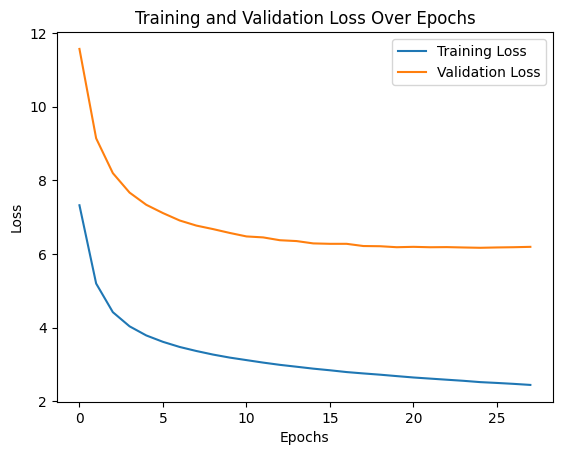

Training loss plot saved at /results/caption_model_training_plot.png
Training history saved at /results/caption_model_training_history.csv


In [62]:
from tensorflow.keras.callbacks import ModelCheckpoint
import csv
import matplotlib.pyplot as plt

# Define checkpoint callback
checkpoint_cb = ModelCheckpoint(
    filepath=f'{tmpx}imgcap_{mdx}', 
    save_weights_only=True, 
    save_best_only=True,
    verbose=1
)

try:
    # Fit the model
    # Train the model and capture the history
    history = caption_model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=valid_dataset,
        callbacks=[early_stopping, checkpoint_cb],
    )

    # Save training history as a CSV
    csv_path = "/results/caption_model_training_history.csv"
    history_data = history.history
    with open(csv_path, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow(["epoch"] + list(history_data.keys()))
        # Write data
        for i in range(len(history_data["loss"])):
            writer.writerow([i + 1] + [history_data[key][i] for key in history_data.keys()])

    # Save and show the loss curves as a plot
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plot_path = "/results/caption_model_training_plot.png"
    plt.savefig(plot_path)
    plt.show()
    plt.close()
    print(f"Training loss plot saved at {plot_path}")
    
    print(f"Training history saved at {csv_path}")
except ValueError as e:
    print(f"ValueError during model fitting: {e}")

Test image path.

In [63]:
# Main loop to process test images
dataset_directory = "/data/test/rxxch9vw59-2/"
test_image_filenames = os.listdir(dataset_directory+"images")

# Random Image Selection and Controlled Display

Generates a caption for a random image among test images.

In [64]:
random_image = np.random.choice(test_image_filenames)

Show Random Image and Caption Without Saving

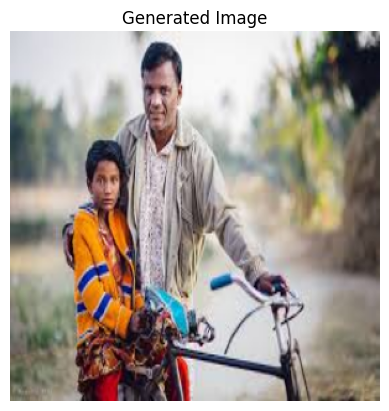


Predicted Caption:  একজন পুরুষ সাইকেল চালিয়ে যাচ্ছে। একজন


'একজন পুরুষ সাইকেল চালিয়ে যাচ্ছে। একজন'

In [65]:
# Generate and display the caption for the selected random image
# print(f"Generating caption for randomly selected image: {random_image}")
# caption = generate_caption(dataset_directory, random_image)

generate_caption(dataset_directory,'1228.png')

Display Only a Few Images Without Saving

In [66]:
# for idx, image_filename in enumerate(test_image_filenames[:5]):  # Process first 5 images
#     generate_caption(dataset_directory, image_filename, display_count=5)

# Generate captions for multiple random images

In [67]:
# # Generate captions for 5 random test images
# num_random_images = 5

# for i in range(num_random_images):
#     random_image = np.random.choice(test_image_filenames)
#     print(f"\nGenerating caption for image {i + 1}: {random_image}")
#     caption = generate_caption(dataset_directory, random_image)
#     # print(f"Generated Caption: {caption}")


Generate captions for all test images.

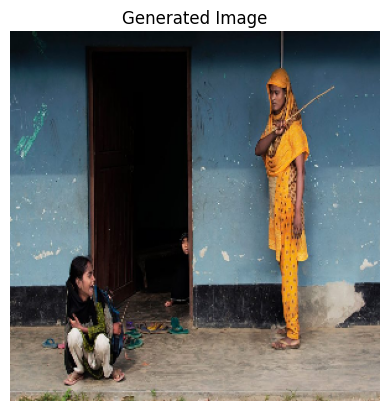


Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।


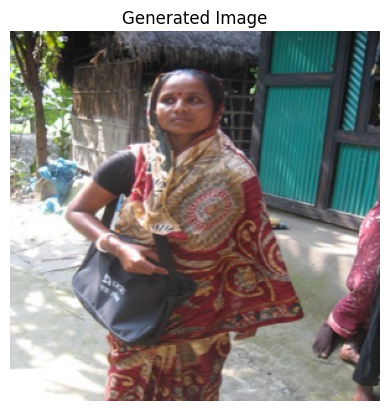


Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।


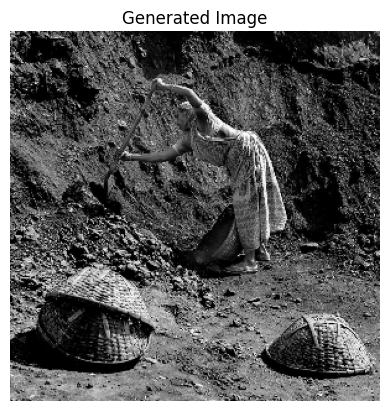


Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।


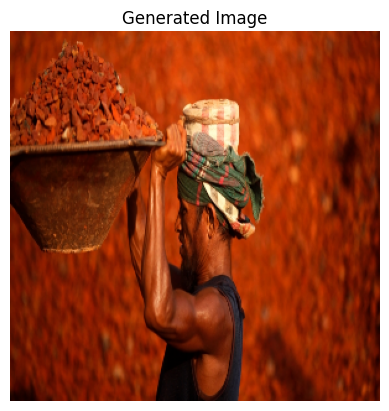


Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:49:11.438642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  কয়েকজন মানুষ আছে।


2024-12-20 09:49:12.034904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো আছে। অনেকগুলো

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন মানুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন মহিলা একটি বাচ্চাকে কোলে নিয়ে দাড়িয়ে

Predicted Caption:  সমুদ্রের পারে অনেকগুলো মানুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী আছে। একটি

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে। নৌকা

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো দাড়িয়ে অনেকগুলো

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু তাকিয়ে আছে। আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে।

Predicted Caption:  

2024-12-20 09:49:24.580154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  সরিষা ক্ষেতের মাঝ দিয়ে একজন মানুষ হেঁটে

Predicted Caption:  সমুদ্রের পারে একজন মানুষ দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন মানুষ বসে আছে।

Predicted Caption:  সরিষা ক্ষেতের মাঝে একজন নারী ও একটি

Predicted Caption:  পানিতে কয়েকজন মানুষ আছে।


2024-12-20 09:49:27.296134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন একজন

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো দাড়িয়ে


2024-12-20 09:49:30.012540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একটি

Predicted Caption:  একজন পুরুষ মাথায় বোঝা নিয়ে হেঁটে যাচ্ছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ মাথায় বোঝা নিয়ে হেঁটে যাচ্ছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  অনেকগুলো পুরুষ ও শিশু আছে। আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:49:36.340202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:49:39.216492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:49:40.844239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ বসে আছে। একজন

Predicted Caption:  একটি শিশু বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  কয়েকজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একটি কুকুর শুয়ে আছে। একটি


2024-12-20 09:49:46.321101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  কয়েকজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একটি

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে।

Predicted Caption:  কয়েকজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু আছে।


2024-12-20 09:49:55.040329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি ছেলে ও একটি মেয়ে দাড়িয়ে আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ হেঁটে যাচ্ছে। গরু গরু

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  অনেকগুলো পুরুষ পাশাপাশি দাড়িয়ে আছে। অনেকগুলো

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  কয়েকজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী বসে আছে। একজন একজন

Predicted Caption:  একজন পুরুষ ও একজন নারী হেঁটে যাচ্ছে।

Predicted Caption:  কয়েকজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:50:04.148365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন নারী বসে আছে। একজন একজন

Predicted Caption:  কয়েকজন নারী ও শিশু আছে। দাড়িয়ে

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  কয়েকজন পুরুষ ও একজন নারী দাড়িয়ে আছে।


2024-12-20 09:50:06.995429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  কয়েকজন পুরুষ ও অনেকগুলো নারী দাড়িয়ে আছে।


2024-12-20 09:50:07.573495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী তাকিয়ে আছে।

Predicted Caption:  কয়েকজন নারী ও পুরুষ আছে। অনেকগুলো


2024-12-20 09:50:08.930101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী তাকিয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।


2024-12-20 09:50:11.809306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ তাকিয়ে আছে। একজন

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:50:13.584959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ হেঁটে আসছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে।

Predicted Caption:  সমুদ্রের পারে কয়েকজন মানুষ আছে। দাড়িয়ে

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী বসে আছে। বসে বসে

Predicted Caption:  একজন পুরুষ বসে আছে। অনেকগুলো অনেকগুলো

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  কয়েকজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। গরু গরু গরু

Predicted Caption:  তিনজন নারী ও একজন পুরুষ পাশাপাশি দাড়িয়ে

2024-12-20 09:50:28.686243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  পানিতে একজন পুরুষ আছে।


2024-12-20 09:50:32.769302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  অনেকগুলো শিশু বসে আছে। বসে বসে


2024-12-20 09:50:35.552572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ তাকিয়ে আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  কয়েকজন নারী ও পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  কয়েকজন পুরুষ ও কয়েকজন নারী আছে।


2024-12-20 09:50:41.849499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী বসে আছে। একটি বসে

Predicted Caption:  একজন নারী বসে আছে। বসে কাজ

Predicted Caption:  কয়েকজন মানুষ আছে।


2024-12-20 09:50:44.065904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন বয়স্ক পুরুষ বসে আছে। একজন

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।


2024-12-20 09:50:47.354149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী দাড়িয়ে আছে।

Predicted Caption:  অনেকগুলো মানুষ দাড়িয়ে আছে। অনেকগুলো অনেকগুলো

Predicted Caption:  অনেকগুলো পুরুষ বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে। আছে।

Predicted Caption:  একটি শিশু দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।


2024-12-20 09:50:52.443416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ ও একজন নারী হেঁটে যাচ্ছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন ছোট ছেলে বসে খাবার খাচ্ছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একটি

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন একজন

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী বসে আছে। একজন একজন

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:51:00.775554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ সাইকেল চালাচ্ছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  কয়েকজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু বসে আছে।


2024-12-20 09:51:05.350520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  কয়েকজন মানুষ বসে আছে।


2024-12-20 09:51:05.904806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ কাজ করছে। একজন একজন

Predicted Caption:  একটি শিশু আছে।


2024-12-20 09:51:07.018168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ তাকিয়ে আছে।

Predicted Caption:  অনেকগুলো পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একটি

Predicted Caption:  একজন বয়স্ক পুরুষ তাকিয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী বসে আছে।


2024-12-20 09:51:11.033053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একটি বসে

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন একজন

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী মাথায় গামছা বেধে আছে।

Predicted Caption:  অনেকগুলো পুরুষ ও পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।


2024-12-20 09:51:20.025492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ তাকিয়ে আছে।

Predicted Caption:  একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।


2024-12-20 09:51:23.957869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একটি শিশু আছে। দাড়িয়ে দাড়িয়ে

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন মানুষ হেঁটে যাচ্ছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন একজন

Predicted Caption:  কয়েকজন পুরুষ দাড়িয়ে আছে।


2024-12-20 09:51:27.189989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:51:27.763344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  অনেকগুলো মানুষ দাড়িয়ে আছে। অনেকগুলো

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  অনেকগুলো মানুষ বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন একজন

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একজন নারী বসে আছে।


2024-12-20 09:51:32.711804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ সাইকেল চালিয়ে যাচ্ছে। একজন

Predicted Caption:  একটি শিশু বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী মাথায় বোঝা নিয়ে আছে।


2024-12-20 09:51:35.968028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন একজন

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  কয়েকজন ছেলে মেয়ে একসাথে দাড়িয়ে আছে আর

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন একজন

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একটি শিশু আছে।


2024-12-20 09:51:41.648955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  কয়েকজন নারী ও পুরুষ আছে। দাড়িয়ে


2024-12-20 09:51:42.218641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  অনেকগুলো মানুষ দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।


2024-12-20 09:51:47.292149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ আছে।


2024-12-20 09:51:47.857855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন মানুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একটি দাড়িয়ে

Predicted Caption:  ৪ জন পুরুষ এবং ১ জন মহিলা

Predicted Caption:  তিনজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ সাইকেল চালিয়ে যাচ্ছে। একজন

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ সাইকেল চালাচ্ছে। একজন একজন

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  কয়েকজন নারী ও পুরুষ দাড়িয়ে আছে।

Predicted Caption:  অনেকগুলো নারী ও অনেকগুলো পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন বয়স্ক পুরুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predict

2024-12-20 09:52:08.820484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। দাড়িয়ে দাড়িয়ে

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ একটি গরু নিয়ে যাচ্ছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো দাড়িয়ে অনেকগুলো

Predicted Caption:  অনেকগুলো পুরুষ দাড়িয়ে আছে। অনেকগুলো দাড়িয়ে

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একটি শিশু আছে।

Predicted Caption:  কয়েকজন ছেলে মেয়ে একসাথে দাড়িয়ে আছে আর

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন না

2024-12-20 09:52:21.304868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।


2024-12-20 09:52:21.878700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন মানুষ হেঁটে যাচ্ছে। উপরে উপরে


2024-12-20 09:52:22.986078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  কয়েকজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ মাথায় গামছা বেধে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী বসে আছে।


2024-12-20 09:52:30.006572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একটি


2024-12-20 09:52:31.279185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি নৌকায় একজন মানুষ আছে। নৌকা

Predicted Caption:  একজন পুরুষ বসে আছে। একজন একজন

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  অনেকগুলো নারী ও পুরুষ দাড়িয়ে আছে।


2024-12-20 09:52:36.524001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ তাকিয়ে আছে। একজন একজন

Predicted Caption:  একজন পুরুষ পানিতে জাল ফেলছে।

Predicted Caption:  একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন একজন

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  কয়েকজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  কয়েকজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একটি শিশু বসে আছে।

Predicted Caption:  একটি নৌকায় কয়েকজন মানুষ আছে। আছে।

Predicted Caption:  একটি শিশু দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। অনেকগুলো নৌকা

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  দুইজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী আছে।

Predicted Capt

2024-12-20 09:52:49.495791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একটি গাছের নিচে বসে আছে একজন পুরুষ

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ হেঁটে যাচ্ছে। একজন একজন

Predicted Caption:  একটি ছেলে সাইকেল চালিয়ে যাচ্ছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন একজন

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো অনেকগুলো আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন

Predicted Caption:  একজন মানুষ দাড়িয়ে আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন একজন

Predicted Caption:  অনেকগুলো পুরুষ ও অনেকগুলো নারী দাড়িয়ে আছে।

Predicted Caption:  অনেকগুলো নারী ও অনেকগুলো পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Cap

2024-12-20 09:53:02.744159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।


2024-12-20 09:53:03.872052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  কয়েকজন পুরুষ আছে।

Predicted Caption:  একজন নারী বসে আছে। একটি বসে


2024-12-20 09:53:04.978213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  অনেকগুলো পুরুষ দাড়িয়ে আছে। দাড়িয়ে অনেকগুলো

Predicted Caption:  একটি গরু ও একটি গরু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।


2024-12-20 09:53:07.676291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ বসে আছে। বসে বসে

Predicted Caption:  একজন পুরুষ কাজ করছে। একজন একজন

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একটি শিশু আছে।


2024-12-20 09:53:10.407531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।

Predicted Caption:  একটি শিশু আছে। নৌকা আছে।

Predicted Caption:  একটি শিশু আছে।


2024-12-20 09:53:13.207953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।


2024-12-20 09:53:15.927166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি শিশু দাড়িয়ে আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী হেঁটে যাচ্ছে।

Predicted Caption:  একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। অনেকগুলো

Predicted Caption:  একজন পুরুষ হেঁটে যাচ্ছে। একজন রাস্তা

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ পাশাপাশি দাড়িয়ে

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:53:24.161010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। দেয়ালে দেয়ালে

Predicted Caption:  একজন নারী ও একজন নারী দাড়িয়ে আছে।


2024-12-20 09:53:25.783042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ তাকিয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে। আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  কয়েকজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ মাথায় গামছা বেধে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন অনেকগুলো

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন নারী ও পুরুষ আছে। অনেকগুলো

Predicted Caption:  কয়েকজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একটি শিশু বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।


2024-12-20 09:53:37.375991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ কাজ করছে। একজন

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একটি শিশু আছে।


2024-12-20 09:53:41.234423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী বসে আছে। বসে বসে

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন একজন

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন একজন

Predicted Caption:  কয়ে

2024-12-20 09:53:55.197575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন নারী ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একটি

Predicted Caption:  একজন বয়স্ক পুরুষ বসে আছে। একজন

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  কয়েকজন মানুষ দাড়িয়ে আছে। অনেকগুলো দাড়িয়ে

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  অনেকগুলো মানুষ দাড়িয়ে আছে। দাড়িয়ে দাড়িয়ে

Predicted Caption:  একজন পুরুষ ও একজন নারী হেঁটে যাচ্ছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  সমুদ্রের পারে অনেকগুলো মানুষ আছে। আছে।


2024-12-20 09:54:05.743458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী তাকিয়ে আছে।


2024-12-20 09:54:06.295268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  কয়েকজন ছেলে মেয়ে শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  অনেকগুলো শিশু আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন নারী দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  নদীতে একটি নৌকা চলছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ তাকিয়ে আছে।

Predicted Caption:  একটি শিশু বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।


2024-12-20 09:54:17.830546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী মাথায় গামছা বেধে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একটি দাড়িয়ে

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ মাথায় গামছা বেধে তাকিয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। অনেকগুলো

Predicted Caption:  একজন পুরুষ বসে আছে। একজন একজন

Predicted Caption:  একটি

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  অনেকগুলো পুরুষ ও অনেকগুলো নারী বসে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী হেঁটে যাচ্ছে।

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  তিনজন পুরুষ বসে আছে। বসে বসে

Predicted Caption:  কয়েকজন নারী ও শিশু আছে। দাড়িয়ে

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো দাড়িয়ে

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন

Predicted Caption:  অনেকগুলো পুরুষ বসে আছে।

Predicted Caption:  একজন মানুষ একটি গরু নিয়ে যাচ্ছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো দাড়িয়ে অনেকগুল

2024-12-20 09:54:34.365888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  অনেকগুলো পুরুষ দাড়িয়ে আছে। অনেকগুলো

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন


2024-12-20 09:54:37.809504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  চারজন পুরুষ বসে আছে। একটি বসে

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  অনেকগুলো পুরুষ দাড়িয়ে আছে।


2024-12-20 09:54:40.055667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  কয়েকজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একটি

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।


2024-12-20 09:54:46.718199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  কয়েকজন ছেলে মেয়ে শিশু বসে আছে।


2024-12-20 09:54:47.318406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ বসে আছে। একটি

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একজন পুরুষ খালি শরীরে রঙ মেখে আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে। আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  কয়েকজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।


2024-12-20 09:54:51.153455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী বসে আছে। একজন

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  অনেকগুলো ভবন আছে। আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী বসে আছে। একটি দাড়িয়ে

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  সমুদ্রের পারে একজন মানুষ আছে। দাড়িয়ে


2024-12-20 09:54:56.311043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  কয়েকজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  অনেকগুলো পুরুষ বসে আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো অনেকগুলো আছে।

Predicted Caption:  অনেকগুলো নারী ও পুরুষ আছে। অনেকগুলো

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  অনেকগুলো পুরুষ বসে আছে। অনেকগুলো দাড়িয়ে


2024-12-20 09:55:02.749966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:55:03.892482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে।

Predicted Caption:  একজন নারী দাড়িয়ে আছে।


2024-12-20 09:55:08.892968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ বসে আছে। একটি

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একজন নারী দাড়িয়ে আছে। একজন

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো অনেকগুলো বসে

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  কয়েকজন পুরুষ আছে।


2024-12-20 09:55:13.943589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ সাইকেল চালাচ্ছে।

Predicted Caption:  কয়েকজন মানুষ আছে। অনেকগুলো আছে। অনেকগুলো

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একটি মেয়ে শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একটি শিশু বসে আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ একটি গরু নিয়ে যাচ্ছে।


2024-12-20 09:55:20.417850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  অনেকগুলো পুরুষ দাড়িয়ে আছে। অনেকগুলো দাড়িয়ে

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  অনেকগুলো পুরুষ ও অনেকগুলো নারী আছে।

Predicted Caption:  কয়েকজন ছেলে একসাথে বসে আছে আর তার

Predicted Caption:  একজন পুরুষ বসে আছে। একজন

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একটি শিশু আছে।


2024-12-20 09:55:25.043545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি নৌকায় একজন মানুষ আছে। আছে।


2024-12-20 09:55:25.597265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG



Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একটি


2024-12-20 09:55:26.697587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একজন নারী হেঁটে যাচ্ছে। সাইকেল সাইকেল

Predicted Caption:  একজন নারী বসে আছে। দাড়িয়ে দাড়িয়ে

Predicted Caption:  অনেকগুলো শিশু বসে আছে। বসে দাড়িয়ে

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  অনেকগুলো পুরুষ ও অনেকগুলো নারী বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একটি শিশু বসে আছে। বসে বসে

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  পানিতে একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ পাশাপাশি দাড়িয়ে

Predicted Caption:  একজন নারী তাকিয়ে আছে।

Predicted Caption:  অনেকগুলো শিশু আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Cap

2024-12-20 09:55:40.598551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  অনেকগুলো মানুষ আছে।

Predicted Caption:  কয়েকজন ছেলে মেয়ে একসাথে দাড়িয়ে আছে আর

Predicted Caption:  একজন পুরুষ বসে আছে।


2024-12-20 09:55:42.310475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:55:42.857630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  কয়েকজন পুরুষ পাশাপাশি দাড়িয়ে আছে। অনেকগুলো

Predicted Caption:  একজন নারী তাকিয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একটি ফলের দোকানে বসে আছে একজন পুরুষ

Predicted Caption:  একজন পুরুষ একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  অনেকগুলো মানুষ দাড়িয়ে আছে।


2024-12-20 09:55:46.236125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  কয়েকজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন একজন


2024-12-20 09:55:48.379335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি রাস্তা দিয়ে রিক্সা ও গাড়ি চলাচল


2024-12-20 09:55:48.911186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  কয়েকজন নারী ও অনেকগুলো পুরুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী বসে আছে। বসে বসে

Predicted Caption:  একজন পুরুষ একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।


2024-12-20 09:55:52.310404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী দাড়িয়ে আছে। একজন

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:55:53.412318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী দাড়িয়ে আছে। একজন একজন


2024-12-20 09:55:54.571610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ বসে আছে। একটি

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী হেঁটে যাচ্ছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী বসে আছে। একজন একজন

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একটি

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একটি

Predicted Caption:  একটি শিশু দাড়িয়ে আছে।

Predicted Caption:  রাস্তা দিয়ে কয়েকজন মানুষ হেঁটে যাচ্ছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছ

2024-12-20 09:56:14.045162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ সাইকেল চালিয়ে যাচ্ছে। সাইকেল

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন পুরুষ ও কয়েকজন নারী আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  ৪ জন ছেলে এবং ১ জন মেয়ে

Predicted Caption:  একজন নারী আছে।


2024-12-20 09:56:19.933411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।

Predicted Caption:  তিনজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন একজন

Predicted Caption:  কয়েকজন মানুষ আছে।


2024-12-20 09:56:24.350938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  কয়েকজন পুরুষ ও কয়েকজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  কয়েকজন পুরুষ ও অনেকগুলো নারী আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ পানিতে জাল নিয়ে আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে।

Predicted Caption:  একটি শিশু বই পড়ছে। বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:56:31.967363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ তাকিয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ তাকিয়ে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একটি শিশু আছে।

Predicted Caption:  অনেকগুলো মানুষ দাড়িয়ে আছে। অনেকগুলো অনেকগুলো

Predicted Caption:  একজন পুরুষ হেঁটে যাচ্ছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ তাকিয়ে আছে।

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একজন ছোট মেয়ে একটি শিশু কোলে নিয়ে

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:56:41.451412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন একজন

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একটি

Predicted Caption:  একজন পুরুষ হেঁটে আসছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:56:48.347570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি শিশু আছে।


2024-12-20 09:56:48.989183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  কয়েকজন নারী ও পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  অনেকগুলো শিশু বসে আছে। বসে বসে

Predicted Caption:  একটি শিশু আছে।


2024-12-20 09:56:53.224692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। অনেকগুলো দাড়িয়ে

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ মাথায় বোঝা নিয়ে হেঁটে যাচ্ছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একটি শিশু বসে আছে। বসে বসে

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  কয়েকজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  তিনজন পুরুষ ও একজন নারী আছে।

P

2024-12-20 09:57:13.846521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  দুইজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী বসে আছে। বসে বসে

Predicted Caption:  একজন নারী বসে আছে। একজন একজন

Predicted Caption:  একজন পুরুষ বসে আছে।


2024-12-20 09:57:16.795818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ বসে আছে। একজন

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন


2024-12-20 09:57:18.550586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।


2024-12-20 09:57:19.152186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।


2024-12-20 09:57:20.497811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একটি নৌকায় কয়েকজন মানুষ আছে। আছে।


2024-12-20 09:57:23.440831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী বসে আছে। একটি

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  অনেকগুলো নারী ও অনেকগুলো পুরুষ আছে।

Predicted Caption:  একটি শিশু বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো দাড়িয়ে অনেকগুলো

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  কয়েকজন নারী ও পুরুষ আছে। অনেকগুলো

Predicted Caption:  একটি গরু আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে।

Predicted Caption:  একটি শিশু বসে আছে।


2024-12-20 09:57:32.096331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  কয়েকজন মানুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একটি শিশু বসে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।


2024-12-20 09:57:34.455289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন একজন

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ রাস্তা দিয়ে হেঁটে যাচ্ছে।

Predicted Caption:  একটি শিশু হেঁটে যাচ্ছে। অনেকগুলো অনেকগুলো

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ সাইকেল চালিয়ে যাচ্ছে। সাইকেল

Predicted Caption:  একজন নারী বসে আছে। একজন একজন

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  অনেকগুলো মানুষ কাজ করছে। অনেকগুলো অনেকগুলো

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন


2024-12-20 09:57:45.630906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একটি

Predicted Caption:  একজন পুরুষ সাইকেল চালিয়ে যাচ্ছে। সাইকেল

Predicted Caption:  একজন নারী বসে আছে। বসে বসে

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  অনেকগুলো মানুষ দাড়িয়ে আছে। অনেকগুলো দাড়িয়ে

Predicted Caption:  একটি বড় বড় বড় বড় বড় একটি

Predicted Caption:  একটি জলাশয় আছে। আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন একজন

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে। আছে।

Predicted Caption:  এ

2024-12-20 09:58:03.980180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ বক্তৃতা দিচ্ছে। পাশে একজন নারী

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে।

Predicted Caption:  অনেকগুলো পুরুষ দাড়িয়ে আছে।


2024-12-20 09:58:08.108561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন ছোট মেয়ে একটি শিশু তাকিয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ মাথায় গামছা বেধে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  অনেকগুলো পুরুষ পাশাপাশি দাড়িয়ে আছে। দাড়িয়ে

Predicted Caption:  একজন পুরুষ মাথায় গামছা বেধে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একটি বসে

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ মাথায় বস্তা নিয়ে হেঁটে যাচ্ছে।


2024-12-20 09:58:13.981387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী বসে আছে। একটি

Predicted Caption:  একজন পুরুষ বসে আছে। একজন একজন

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন নারী ও শিশু আছে। দাড়িয়ে

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একটি

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ পানিতে লাফ দিয়েছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন একজন

Predicted Caption:  অনেকগুলো পুরুষ বসে আছে। বসে বসে

Predicted Caption:  কয়েকজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ সাইকেল চালিয়ে আসছে। একজন

Predicted Caption:  একটি গাছের ডালে একটি পাখি আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  পানিতে একজন পুরু

2024-12-20 09:58:26.402524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী তাকিয়ে আছে।

Predicted Caption:  একজন নারী তাকিয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  কয়েকজন পুরুষ ও নারী আছে। অনেকগুলো


2024-12-20 09:58:29.301880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন মানুষ হেঁটে যাচ্ছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  অনেকগুলো পুরুষ দাড়িয়ে আছে। অনেকগুলো দাড়িয়ে

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।


2024-12-20 09:58:40.442207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ বসে আছে। একটি দাড়িয়ে

Predicted Caption:  একজন নারী ও একজন নারী আছে।

Predicted Caption:  কয়েকজন পুরুষ বসে আছে। বসে বসে

Predicted Caption:  একজন পুরুষ বসে আছে। একটি দাড়িয়ে

Predicted Caption:  একজন পুরুষ আছে।


2024-12-20 09:58:43.460060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ বসে আছে। একটি

Predicted Caption:  একজন নারী তাকিয়ে আছে।

Predicted Caption:  অনেকগুলো পুরুষ ও অনেকগুলো নারী দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 09:58:46.407011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন একজন

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একটি শিশু বসে আছে।

Predicted Caption:  একজন পুরুষ সাইকেল চালিয়ে আসছে। সাইকেল

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন বয়স্ক পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একটি মেয়ে শিশু আছে।

Predicted Caption:  একটি নৌকায় কয়েকজন মানুষ আছে। আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু হেঁটে যাচ্ছে।

Predi

2024-12-20 09:59:01.051111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ তাকিয়ে আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন মানুষ দাড়িয়ে আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে। আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো বসে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ হেঁটে যাচ্ছে।

Predicted Caption:  কয়েকজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  অনেকগুলো মানুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ হাতে বই নিয়ে দাড়িয়ে আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো অনেকগুলো অনেকগুলো

Predicted Caption:  কয়েকজন পুরুষ বসে আছে। বসে বসে

Predicted Caption:  একটি নৌকায় কয়েকজন মানুষ আছে। আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predi

2024-12-20 09:59:20.088032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ সাইকেল চালাচ্ছে।

Predicted Caption:  একটি নৌকায় কয়েকজন মানুষ আছে। আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একজন মানুষ আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ সাইকেল চালিয়ে যাচ্ছে। সাইকেল

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একটি শিশু বসে আছে।

Predicted Caption:  একজন পুরুষ মাথায় বস্তা নিয়ে হেঁটে যাচ্ছে।

Predicted Caption:  কয়েকজন মানুষ দেখা যাচ্ছে।

Predicted Caption:  একটি নৌকায় একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে। দাড়িয়ে

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:

2024-12-20 09:59:51.084339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একটি শিশু বসে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী আছে।


2024-12-20 09:59:53.605428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  অনেকগুলো মানুষ বসে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন পুরুষ মাথায় টুপি পরে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।


2024-12-20 10:00:01.708358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  অনেকগুলো মানুষ আছে।

Predicted Caption:  অনেকগুলো মানুষ দাড়িয়ে আছে। অনেকগুলো অনেকগুলো

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন মানুষ হেঁটে যাচ্ছে। গাছ

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন ছেলে একসাথে দাড়িয়ে আছে আর তার

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একজন

Predicted Caption:  অনেকগুলো মানুষ বসে আছে। নৌকা আছে।

Predicted Caption:  একটি শিশু আছে।


2024-12-20 10:00:11.824066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি নৌকায় কয়েকজন মানুষ আছে। আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো আছে। আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন একজন

Predicted Caption:  একজন পুরুষ বসে আছে। একজন

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  কয়েকজন পুরুষ পাশাপাশি দাড়িয়ে আছে। কয়েকজন

Predicted Caption:  একটি নৌকায় কয়েকজন মানুষ আছে। আছে।


2024-12-20 10:00:17.438459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  অনেকগুলো শিশু বসে আছে। অনেকগুলো আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন পুরুষ বসে আছে। বসে বসে

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একটি সাইকেল আছে।

Predicted Caption:  অনেকগুলো মানুষ বসে আছে। অনেকগুলো

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন বয়স্ক পুরুষ তাকিয়ে আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো

Predicted Caption:  একটি নৌকায় কয়েকজন মানুষ আছে। দাড়িয়ে

Predicted Caption:  একজন নারী দাড়িয়ে আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো অনেকগুলো দাড়িয়ে

Predicted Caption:  একটি শিশু আছে

2024-12-20 10:00:39.370545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ সাইকেল চালিয়ে আসছে।

Predicted Caption:  অনেকগুলো মানুষ আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  অনেকগুলো মানুষ একসাথে বসে আছে। অনেকগুলো

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।

Predicted Caption:  একটি

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একটি শিশু আছে।


2024-12-20 10:00:48.841782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে। আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন পুরুষ ও অনেকগুলো নারী আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একটি মঞ্চে দাড়িয়ে আছে একজন পুরুষ একটি

Predicted Caption:  একজন পুরুষ সাইকেল চালাচ্ছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-20 10:00:53.279188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  অনেকগুলো মানুষ আছে।

Predicted Caption:  সমুদ্রের পারে একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ হেঁটে আসছে।


2024-12-20 10:00:55.474862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  অনেকগুলো মানুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ বসে আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী বসে আছে। একজন একজন

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একজন মহিলা একটি বাচ্চা কোলে নিয়ে বসে

Predicted Caption:  একজন নারী বসে আছে। একটি

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে।

Predicted Caption:  একজন পুরুষ একটি নৌকা চালাচ্ছে।

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একজন পুরুষ তাকিয়ে আছে।

Predicted Caption:  একটি রেল লাইন ধরে রাস্তা দিয়ে হেটে

Predicted Caption:  একটি লোক নদীতে গোসল করছে।

Predicted Caption:  পানিতে একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একটি পাখি আছে।

Predicted Caption:  কয়েকজন মানুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Capt

2024-12-20 10:01:30.311056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো দাড়িয়ে অনেকগুলো

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ হেঁটে যাচ্ছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী হেঁটে যাচ্ছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একটি দাড়িয়ে

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ মাথায় বস্তা নিয়ে হেঁটে যাচ্ছে।


2024-12-20 10:01:38.065704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী বসে আছে।

Predicted Caption:  অনেকগুলো মানুষ বসে আছে। অনেকগুলো অনেকগুলো

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন নারী একটি শিশু কোলে নিয়ে আছে।

Predicted Caption:  একজন পুরুষ হেঁটে আসছে। একজন একজন

Predicted Caption:  একজন নারী দাড়িয়ে আছে। একজন একজন

Predicted Caption:  একটি শিশু তাকিয়ে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।


2024-12-20 10:01:47.116069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  অনেকগুলো মানুষ বসে আছে। অনেকগুলো

Predicted Caption:  একজন পুরুষ বসে আছে। একটি দাড়িয়ে

Predicted Caption:  একজন পুরুষ রাস্তা দিয়ে হেঁটে যাচ্ছে।


2024-12-20 10:01:48.755115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  অনেকগুলো নারী ও পুরুষ আছে। অনেকগুলো

Predicted Caption:  একজন পুরুষ আছে।


2024-12-20 10:01:49.851961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।

Predicted Caption:  একজন পুরুষ তাকিয়ে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে। আছে।

Predicted Caption:  একটি নৌকায় কয়েকজন মানুষ আছে। আছে।

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন মানুষ হেঁটে যাচ্ছে।

Predicted Caption:  অনেকগুলো মানুষ আছে। অনেকগুলো অনেকগুলো আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন একজন

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption: 

2024-12-20 10:02:29.234102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Predicted Caption:  অনেকগুলো পুরুষ বসে আছে। অনেকগুলো

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন একজন

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একজন মানুষ হেঁটে যাচ্ছে।

Predicted Caption:  কয়েকজন মানুষ আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে। একজন একজন

Predicted Caption:  একজন পুরুষ আছে।

Predicted Caption:  একজন পুরুষ তাকিয়ে আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী ও একজন পুরুষ দাড়িয়ে আছে।

Predicted Caption:  একজন নারী আছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  একজন পুরুষ বসে আছে। একটি

Predicted Caption:  একজন মানুষ একটি নৌকা চালাচ্ছে।

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।

Predicted Caption:  পাশাপাশি তিনজন পুরুষ আছে। অনেকগুলো আছে।

Predicted Caption:  একজন নারী বসে আছে।

Predicted Caption:  একটি শিশু আছে।

Predicted Caption:  একজন পুরুষ বসে আছে।

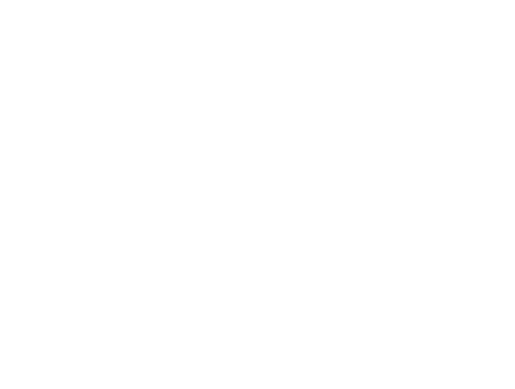

In [68]:
for idx, image_filename in enumerate(test_image_filenames):
    generate_caption(dataset_directory, image_filename, save_dir=output_dir, save_idx=f"test_{idx+1}", display_count=5)

In [69]:
# Finalize and save HTML report only if images and captions were added
if "<div>" in html_content or saved_image_count > 0:  # Check if any image-caption pair was added
    html_content += "</body></html>"
    with open(html_report_path, "w", encoding="utf-8") as f:
        f.write(html_content)
    print(f"HTML report saved at: {html_report_path}")
else:
    print("No images or captions were saved. HTML report was not created.")

HTML report saved at: /results/generated_captions_report.html


Save the weights of the trained model.

In [70]:
# After training the model, save the weights
caption_model.save_weights(f'{tmpx}imgcap_{mdx}', save_format='tf')

Dump the vectorised vocabulary.

In [71]:
# Define the directory path
directory = f'/results/Vocab/{mdx}'

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Save the vocabulary using pickle
with open(f'{directory}/vocab_{mdx}', 'wb') as f:
    pickle.dump(vocab, f)